In [8]:
# en = args.encoder_layers
# de= args.decoder_layers
# random.seed(3000)
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf


mgh = pathlib.Path('fetus_label_map')
mgh_files = list(mgh.glob('*.nii.gz'))
label_maps = [np.uint8(sf.load_volume(str(file_path)).resize([1,1,1],method='nearest').reshape([192,192,192]).data) for file_path in mgh_files]


labels = np.unique(label_maps)
in_shape = label_maps[0].shape



num_labels=8
# labels_in = range(max(labels) + num_labels + 1)
labels_in = np.unique(label_maps) # change this for feta

feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_3d')
feta_files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
feta = pathlib.Path('feta_scaled')
feta_files = list(feta.glob('*.nii.gz'))
# feta = pathlib.Path('feta_resized_192')
# feta_files = list(feta.glob('*.nii.gz'))

# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
# feta_label_maps = [np.uint8(sf.load_volume(str(f)).resize([1,1,1],method='nearest').reshape([256,256,256]).data) for f in feta_files]


feta_label_maps = [np.float32(sf.load_volume(str(f)).resize([1,1,1],method='nearest').reshape([192,192,192]).data) for f in feta_files]
labels = np.unique(feta_label_maps)
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
print(len(feta_label_maps))
print(feta_label_maps[0].shape)


40
(192, 192, 192)


# Build New Dataset

(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)
(192, 192, 192)


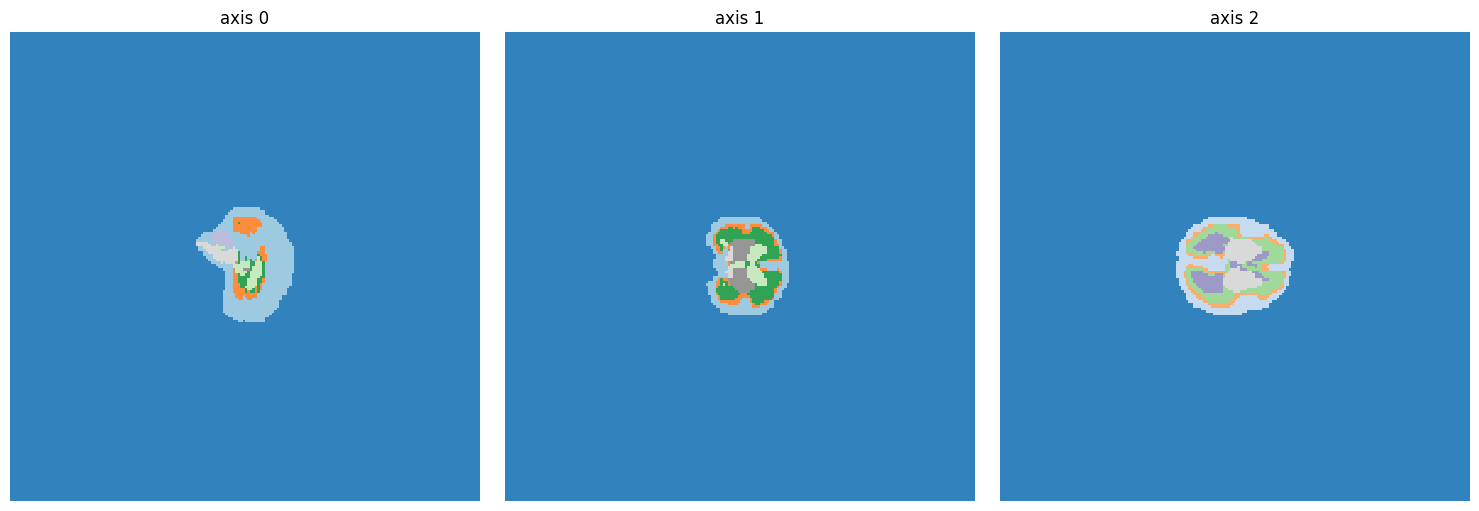

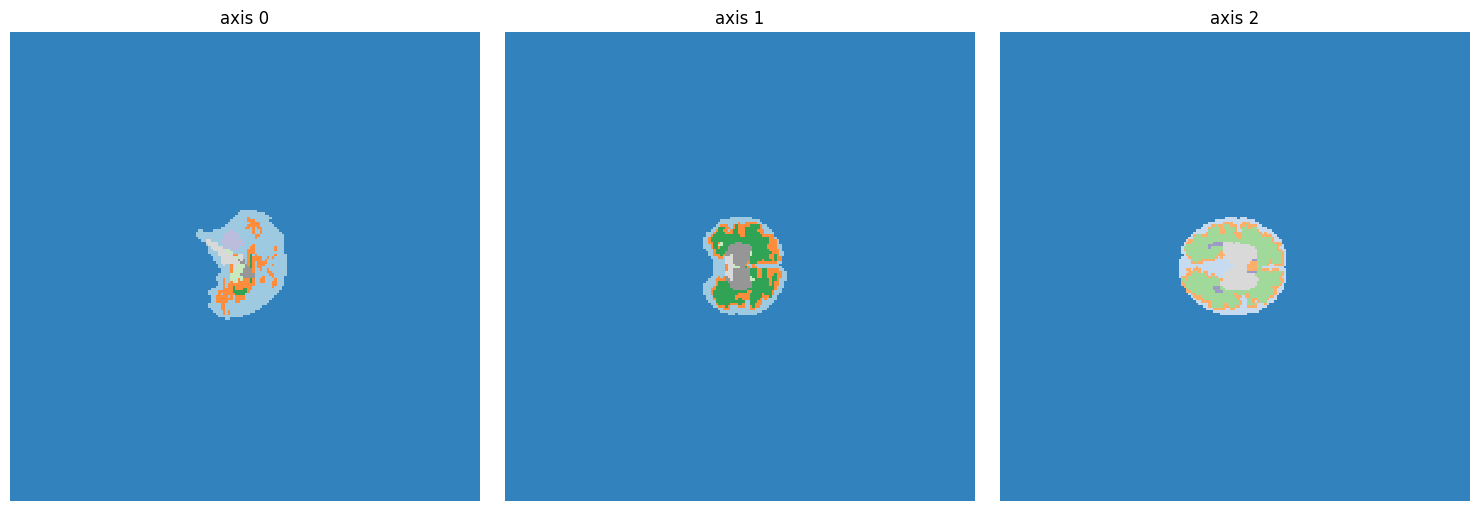

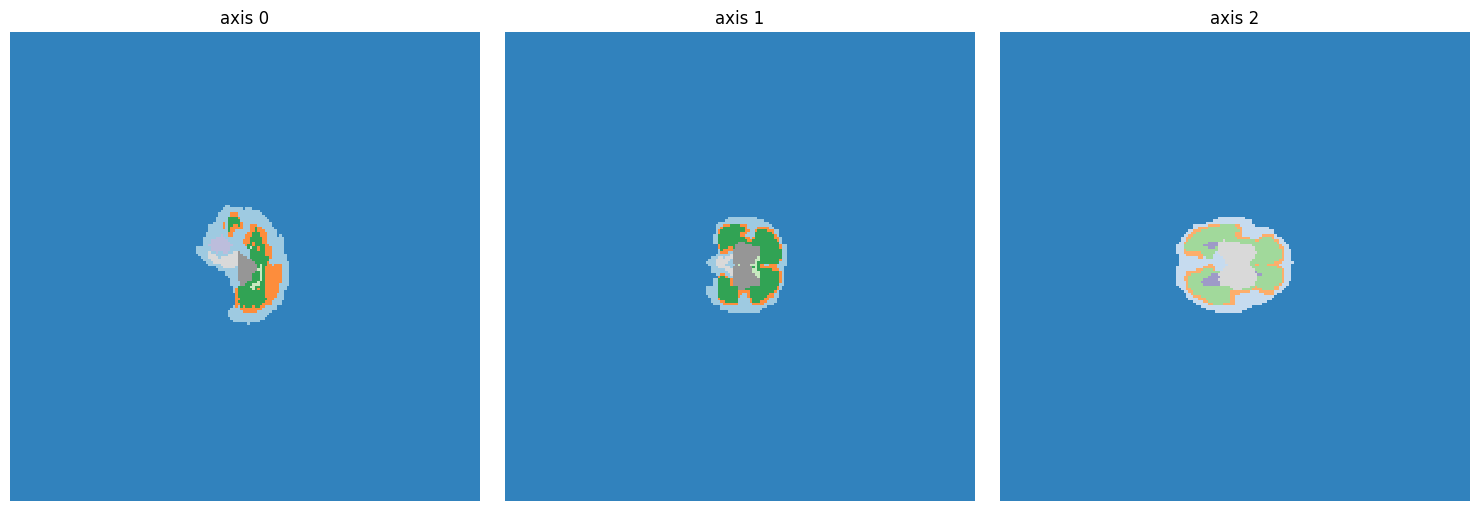

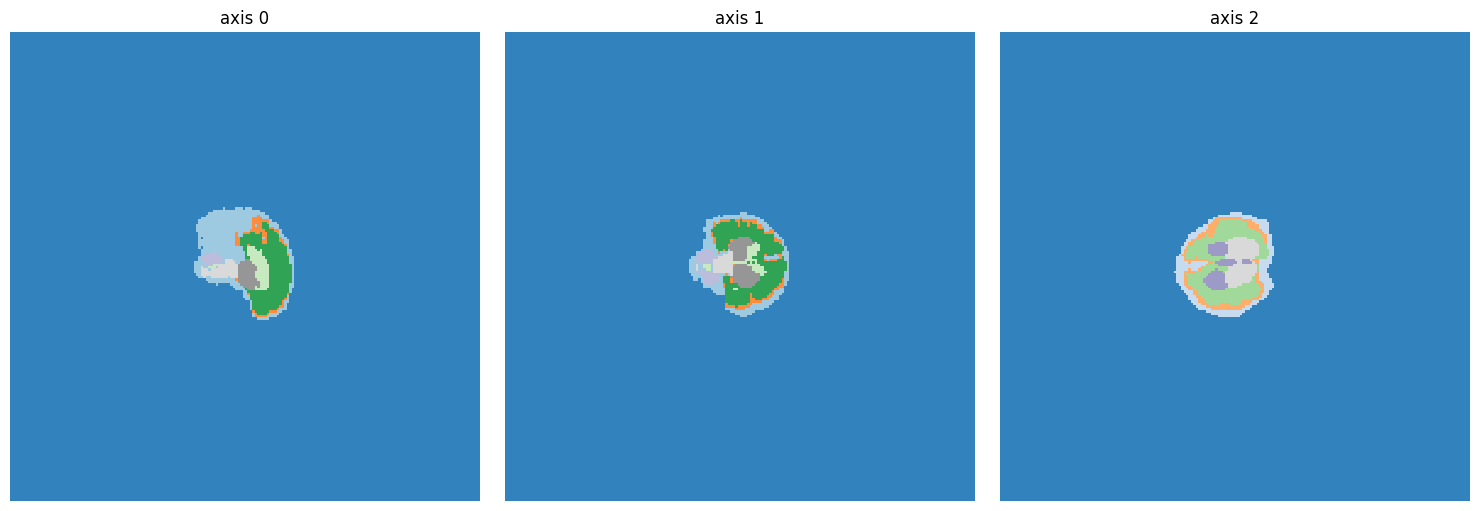

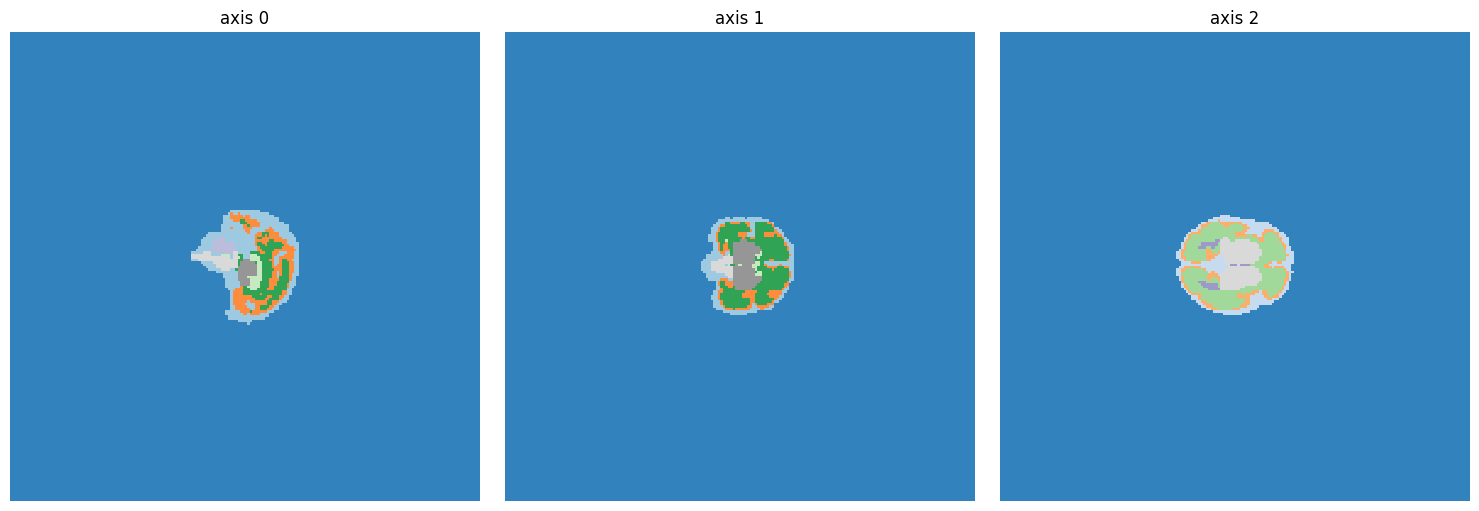

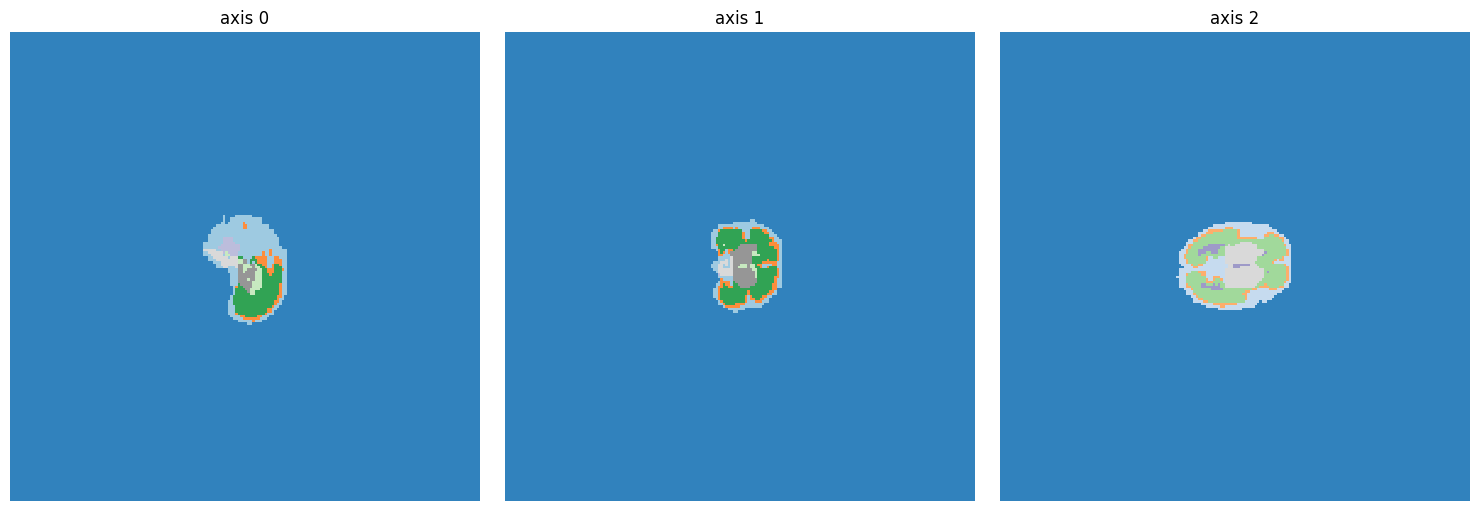

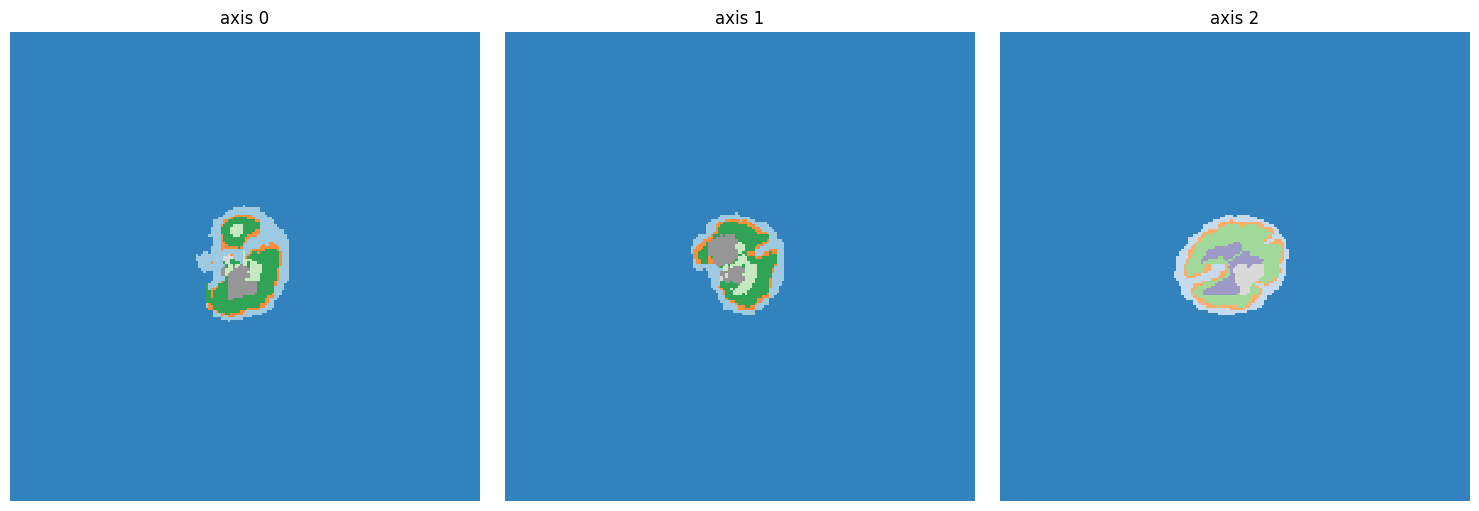

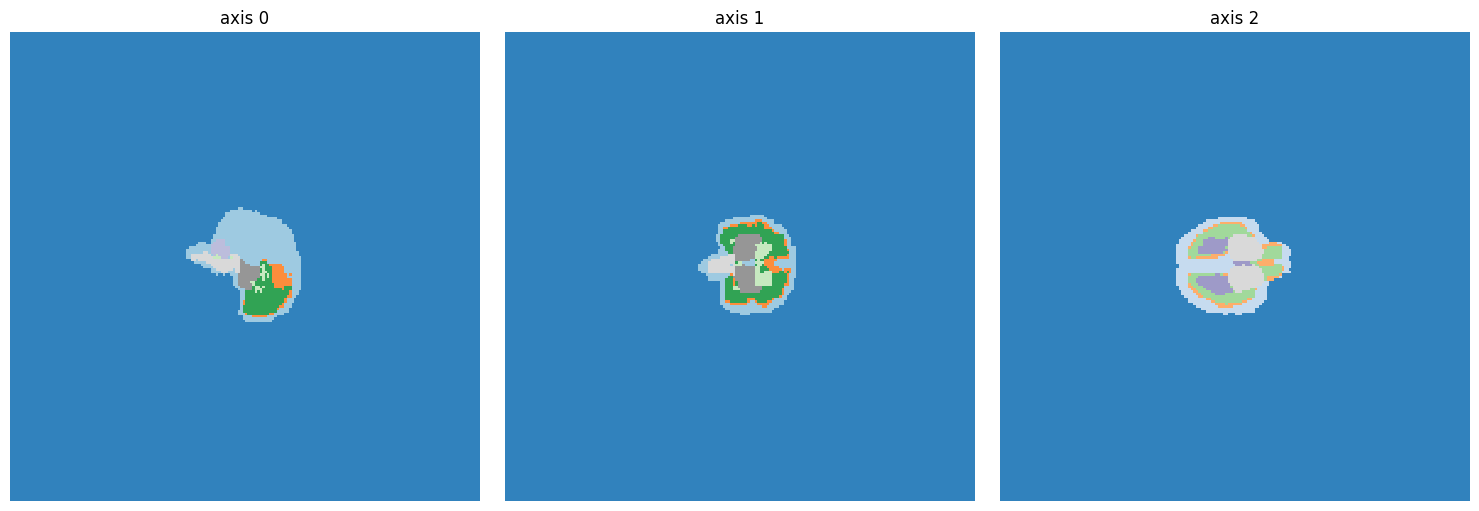

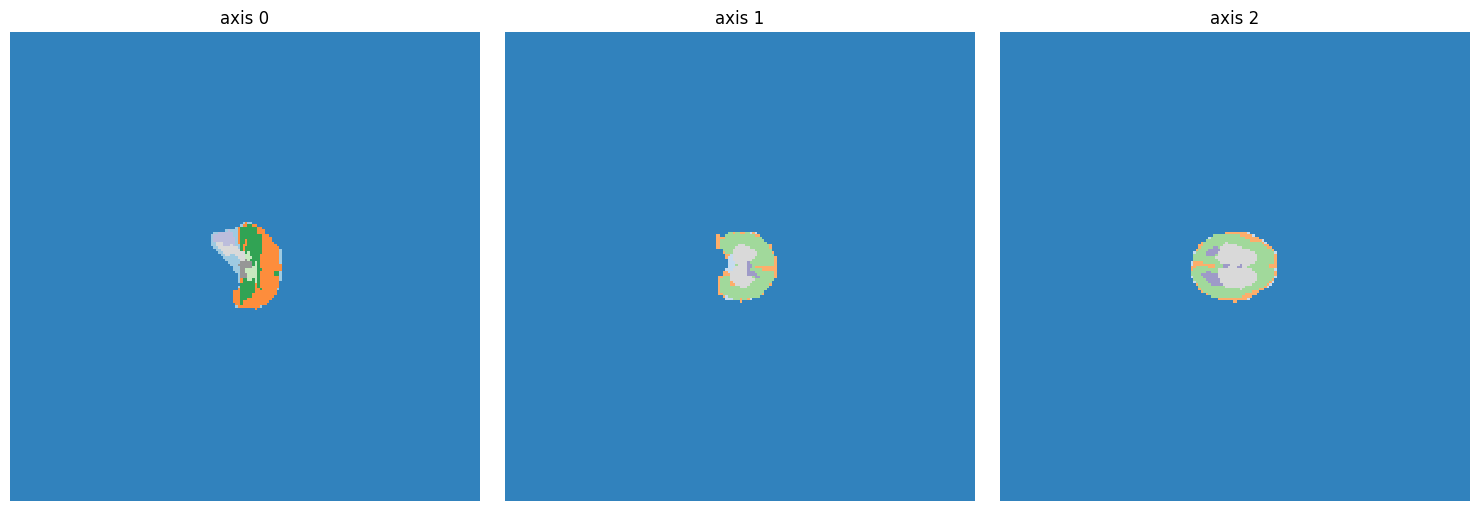

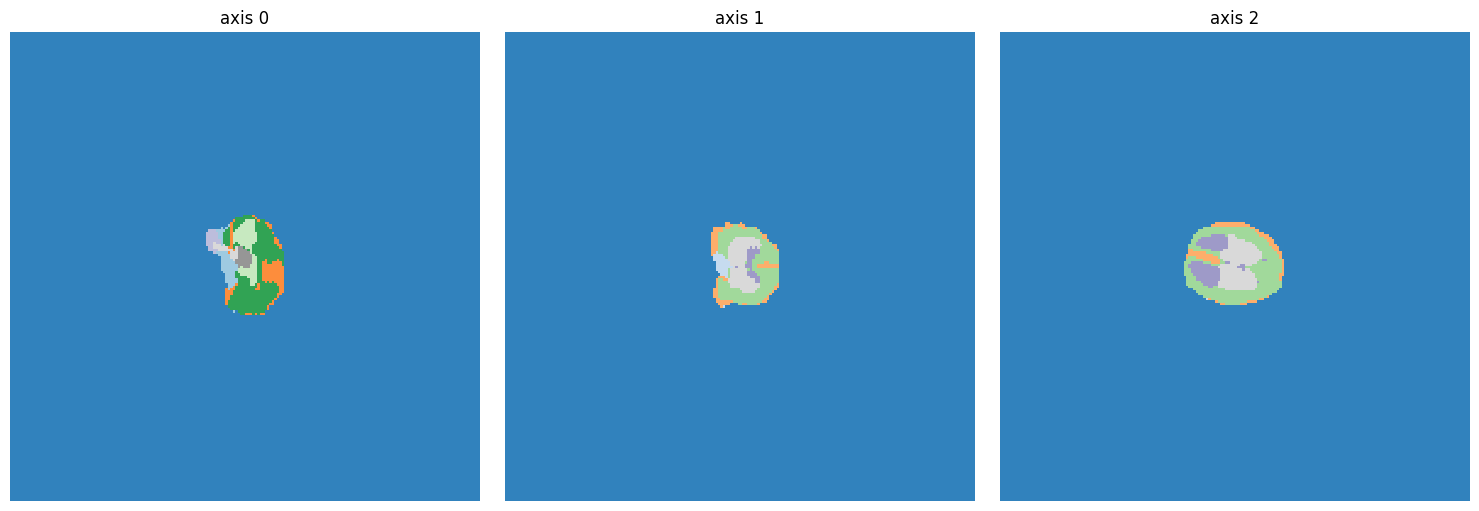

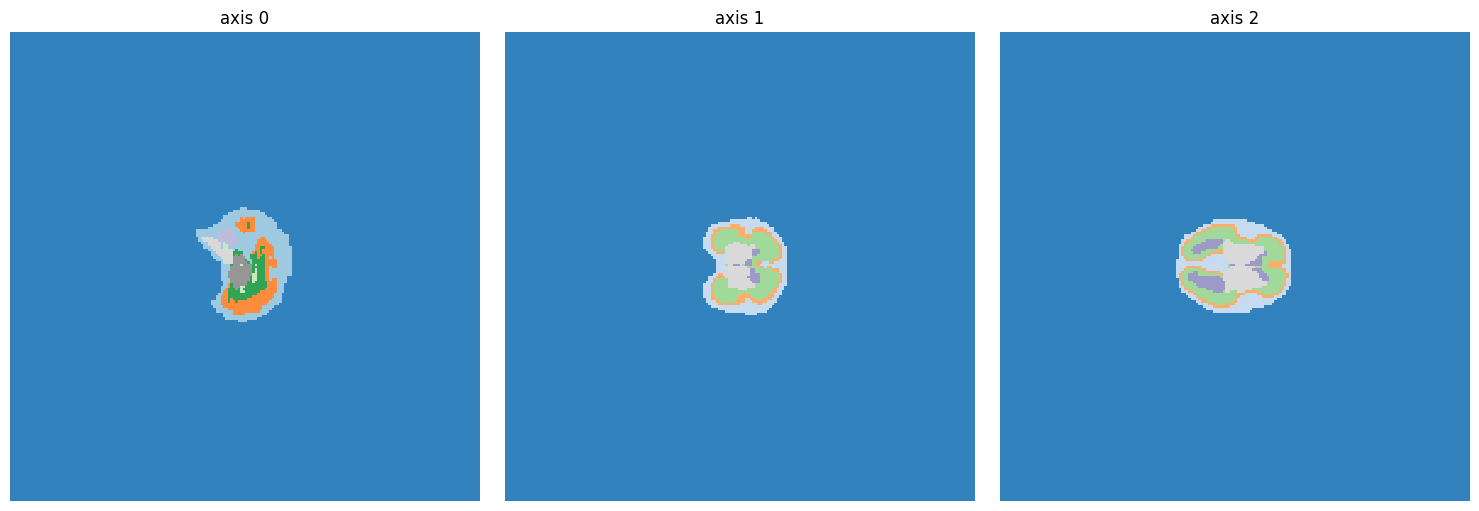

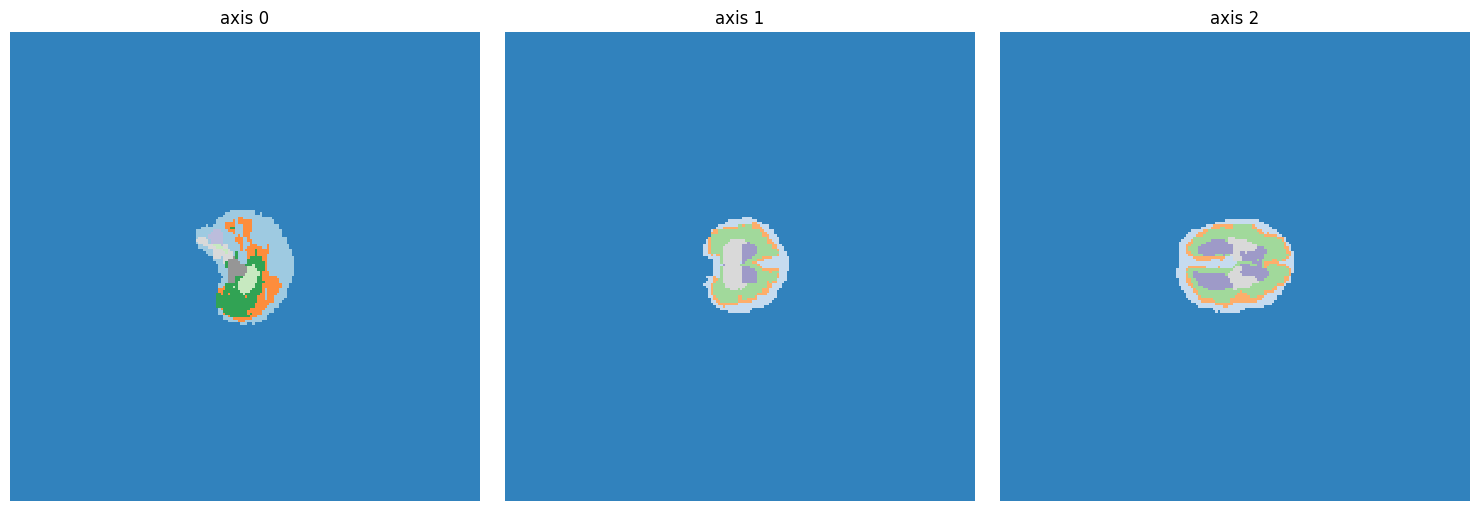

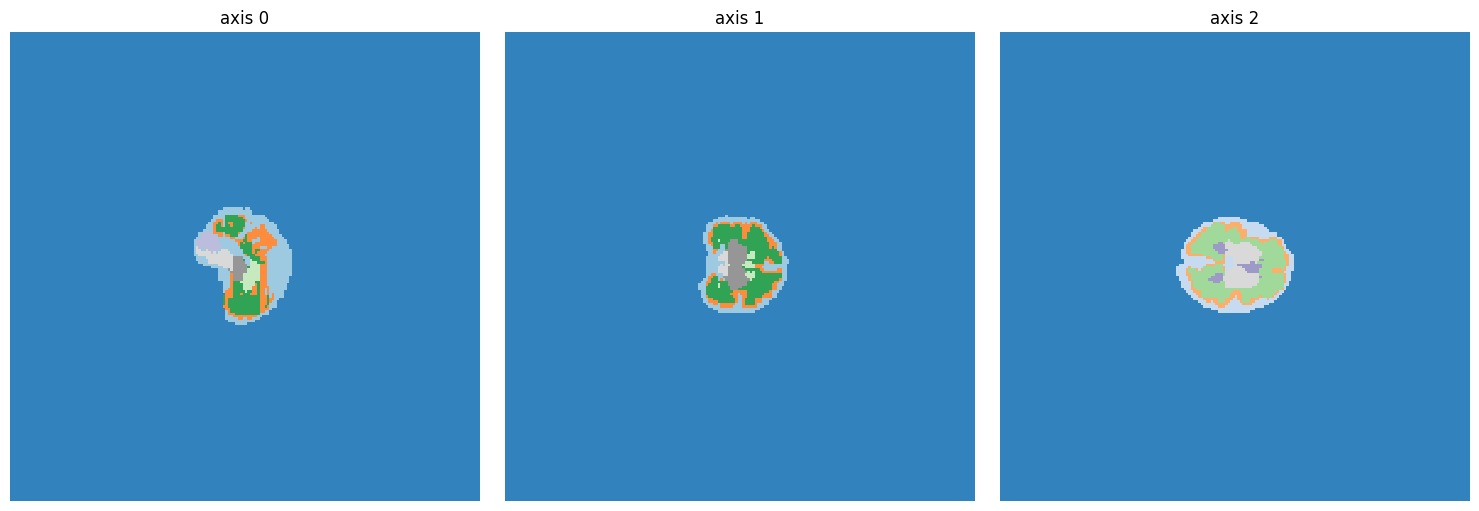

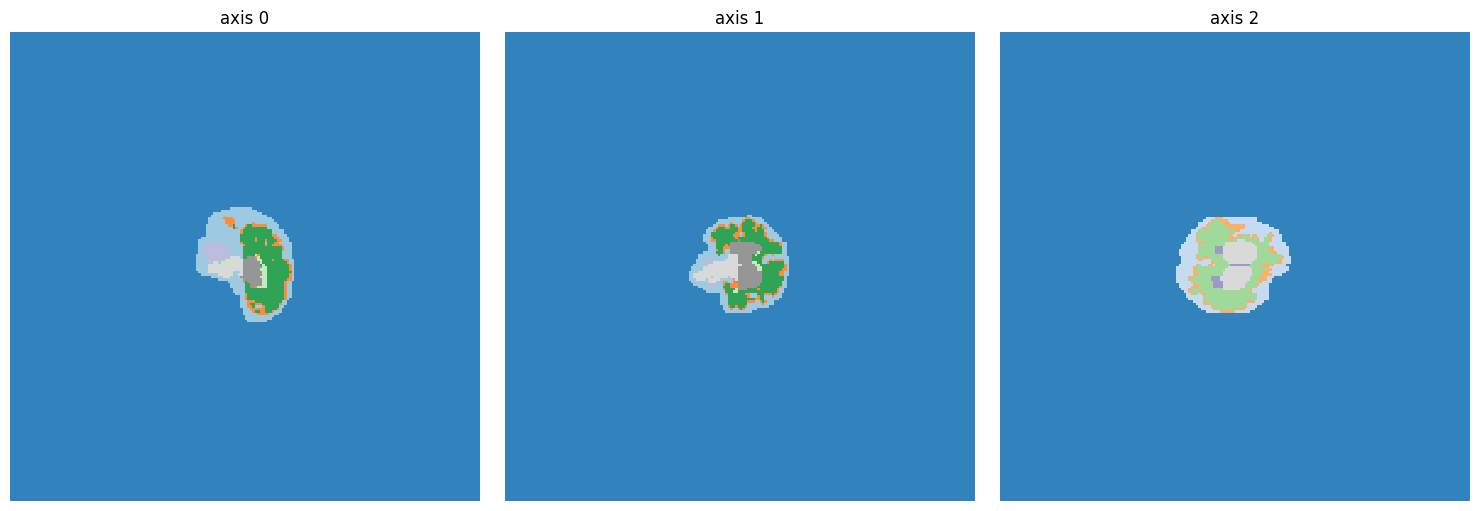

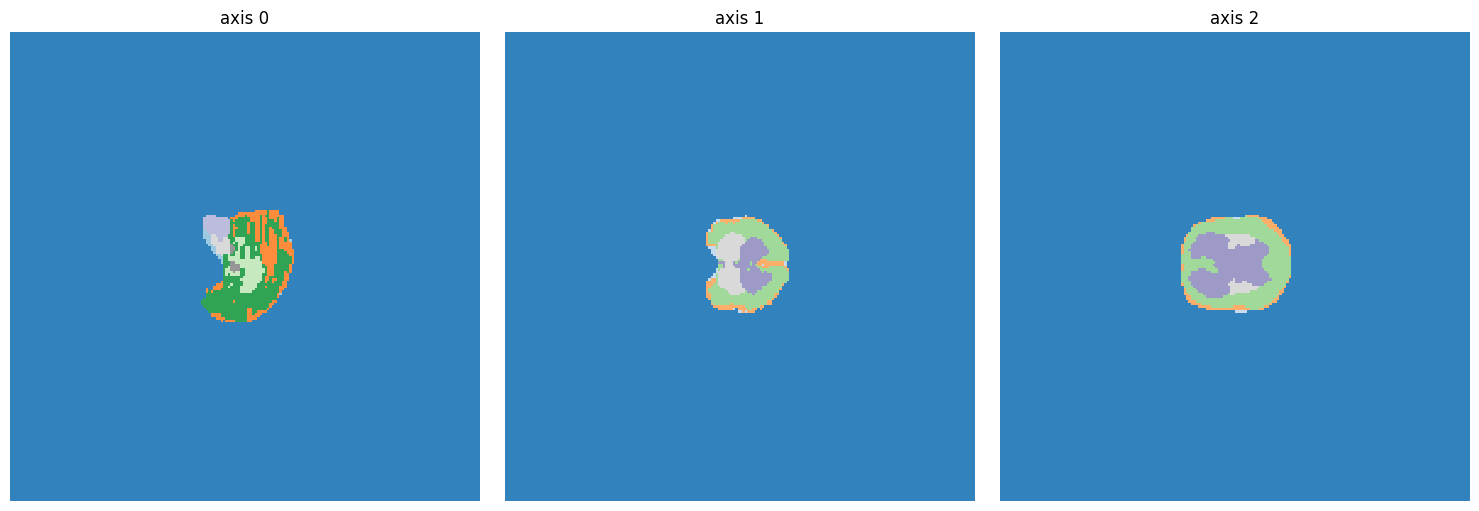

In [13]:

# from scipy.ndimage import zoom
from scipy.ndimage import find_objects, zoom, center_of_mass
def scale_down_brain(label_map, scale_factor=10):
    scaled_label_map = zoom(label_map, 1/scale_factor, order=0, mode='constant', cval=0)
    pad_amount = np.floor((np.array(label_map.shape) - np.array(scaled_label_map.shape)) / 2).astype(int)
    padded_label_map = np.pad(scaled_label_map, (
        (pad_amount[0], label_map.shape[0] - scaled_label_map.shape[0] - pad_amount[0]),
        (pad_amount[1], label_map.shape[1] - scaled_label_map.shape[1] - pad_amount[1]),
        (pad_amount[2], label_map.shape[2] - scaled_label_map.shape[2] - pad_amount[2])
    ), mode='constant', constant_values=0)

    return padded_label_map

def find_center_of_mass(ref):
    # ref = (ref > 0.5).astype(np.uint8)

    # print(ref.shape,"refshape")
    x = int(np.sum(np.arange(ref.shape[0]) * np.mean(ref, axis=(1, 2))) / np.sum(np.mean(ref, axis=(1, 2))))
    y = int(np.sum(np.arange(ref.shape[1]) * np.mean(ref, axis=(0, 2))) / np.sum(np.mean(ref, axis=(0, 2))))
    z = int(np.sum(np.arange(ref.shape[2]) * np.mean(ref, axis=(0, 1))) / np.sum(np.mean(ref, axis=(0, 1))))    
    return x, y, z
    
import numpy as np
from scipy.ndimage import zoom




def resize_to_max_fraction(array, max_fraction=0.25):
    # Calculate the extent of non-zero elements along each dimension
    non_zero_indices = np.nonzero(array)
    min_indices = np.min(non_zero_indices, axis=1)
    max_indices = np.max(non_zero_indices, axis=1)
    extents = max_indices - min_indices + 1
    
    # Calculate the maximum extent allowed based on 25% of the dimension size
    max_extent_allowed = int(192 * max_fraction)

    # Check if any dimension exceeds the maximum allowed extent
    if np.any(extents > max_extent_allowed):
        # Calculate the scaling factor for the entire brain
        scale_factor = max_extent_allowed / np.max(extents)
        
        # Perform zooming to resize the entire brain
        resized_array = zoom(array, zoom=scale_factor, order=0)
        
        # Ensure the resized array has the same dimensionality as (192, 192, 192)
        padded_array = np.zeros((192, 192, 192), dtype=array.dtype)
        
        # Calculate the starting indices to place the resized array in the center
        start_indices = ((192 - resized_array.shape[0]) // 2,
                         (192 - resized_array.shape[1]) // 2,
                         (192 - resized_array.shape[2]) // 2)
        
        # Calculate the ending indices
        end_indices = (start_indices[0] + resized_array.shape[0],
                       start_indices[1] + resized_array.shape[1],
                       start_indices[2] + resized_array.shape[2])
        
        # Assign the resized array to the padded array at the calculated indices
        padded_array[start_indices[0]:end_indices[0],
                     start_indices[1]:end_indices[1],
                     start_indices[2]:end_indices[2]] = resized_array
        
        return padded_array
    else:
        return array
        
# def shift_brain_to_center(label_map, center_coordinates):
#     binary_label_map = (label_map > 0.5).astype(np.uint8)
#     x,y,z = find_center_of_mass(binary_label_map)
#     original_center = (x,y,z)
#     shift_amount = np.array(center_coordinates) - original_center
#     shifted_label_map = np.roll(label_map, shift_amount, axis=(0, 1, 2))
#     shifted_label_map[shift_amount[0]:, shift_amount[1]:, shift_amount[2]:] = 0  # Set background for the shifted region
#     return shifted_label_map

def shift_brain_to_center(array, center):
    # Calculate the shift required for each dimension
    shift = np.array(center) - np.array(array.shape) // 2

    # Pad the array with zeros to accommodate the shift
    padded_array = np.pad(array, [(max(0, s), max(0, -s)) for s in shift], mode='constant')

    # Crop the padded array to the original shape with non-zero elements centered
    cropped_slices = [slice(max(0, -s), dim + max(0, s)) for dim, s in zip(array.shape, shift)]
    cropped_array = padded_array[cropped_slices]

    return cropped_array

# def resize_to_max_fraction(array, max_fraction=0.25, id=11):
#     # Calculate the extent of non-zero elements along each dimension
#     # non_zero_indices = np.nonzero(array)
#     non_zero_indices = np.nonzero(array)
#     min_indices = np.min(non_zero_indices, axis=1)
#     max_indices = np.max(non_zero_indices, axis=1)
#     extents = max_indices - min_indices + 1
    
#     # Calculate the maximum extent allowed based on 25% of the dimension size
#     target_width = 192
#     max_extent_allowed = int(target_width * max_fraction)

#     # Calculate the resizing factor based on the extent of non-zero elements
#     resizing_factor = max_extent_allowed / np.max(extents)
#     resizing_factor = np.min((resizing_factor,1.0))

#     if np.max(extents) > 46:
#         resizing_factor *= np.max(extents) / 46.0
#     elif np.max(extents) < 46:
#         resizing_factor *= 46.0 / np.max(extents)
#     # resizing_factor = np.min((resizing_factor,1.0))
#     if id ==8 or id == 9 :
#         resizing_factor = 0.8
#     print(extents,resizing_factor)
#     target_width = 192
#     a = sf.Volume(array)
#     # fov = np.multiply(a.shape, a.geom.voxsize)

#     # new_voxsize = fov / target_width
#     # print(new_voxsize)

#     a = a.resize([resizing_factor,resizing_factor,resizing_factor]).reshape([192,192,192])
#     return a
        
def locate_and_center_brain(array, desired_center=(95,95,95)):
    # Find the bounding box around non-zero elements
    non_zero_indices = np.nonzero(array)
    min_indices = np.min(non_zero_indices, axis=1)
    max_indices = np.max(non_zero_indices, axis=1)

    # Calculate dimensions of the bounding box
    bounding_box_dimensions = max_indices - min_indices + 1

    # Calculate the center of the bounding box
    center_of_bounding_box = (min_indices + max_indices) // 2

    # Calculate the desired shift to achieve the desired center
    shift = np.array(desired_center) - center_of_bounding_box

    # Create an empty array of the same size as the input array
    centered_array = np.zeros_like(array)

    # Calculate the region to place the brain in the centered array
    start_indices = min_indices + shift
    end_indices = start_indices + bounding_box_dimensions

    # Place the brain in the middle of the centered array
    centered_array[
        start_indices[0]:end_indices[0],
        start_indices[1]:end_indices[1],
        start_indices[2]:end_indices[2]
    ] = array[
        min_indices[0]:max_indices[0]+1,
        min_indices[1]:max_indices[1]+1,
        min_indices[2]:max_indices[2]+1
    ]

    return centered_array



def shift_brain_right(label_map, shift_amount=50):
    shifted_label_map = np.roll(label_map, shift_amount, axis=2)
    shifted_label_map[:, :, :shift_amount] = 0  # Set background for the shifted slices
    return shifted_label_map
    
ref=label_maps[0]  
binary_ref = (ref > 0.5).astype(np.uint8)
x,y,z = find_center_of_mass(binary_ref)
desired_width=64
new_label_maps = []
for i in range(len(feta_label_maps)):
    fet = feta_label_maps[i]

    # fet = resize_brain_to_width(fet, desired_width)


    # print(x,y,z)
    fet = locate_and_center_brain(fet)
    fet = resize_to_max_fraction(fet, max_fraction=0.25)
    # (max_fraction=0.25, id=i,fet)

    # binary_fet = (fet > 0.5).astype(np.uint8)
    # x,y,z = find_center_of_mass(fet)

    # x,y,z = find_center_of_mass((fet > 0.5).astype(np.uint8))
    # print(x,y,z)

    new_label_maps.append(fet)
    print(fet.shape)
    nib.save(nib.Nifti1Image(fet.astype(np.int32), np.eye(4), header=None), f"feta_resized_192/sub_{i}.nii.gz")

# feta_label_maps=new_label_maps
for i in range(15):
    ne.plot.volume3D(new_label_maps[i], cmaps=['tab20c'])

In [14]:
np.unique(new_label_maps[0])

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)

2024-03-15 11:49:45.309211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0


(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)


2024-03-15 11:50:08.686269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


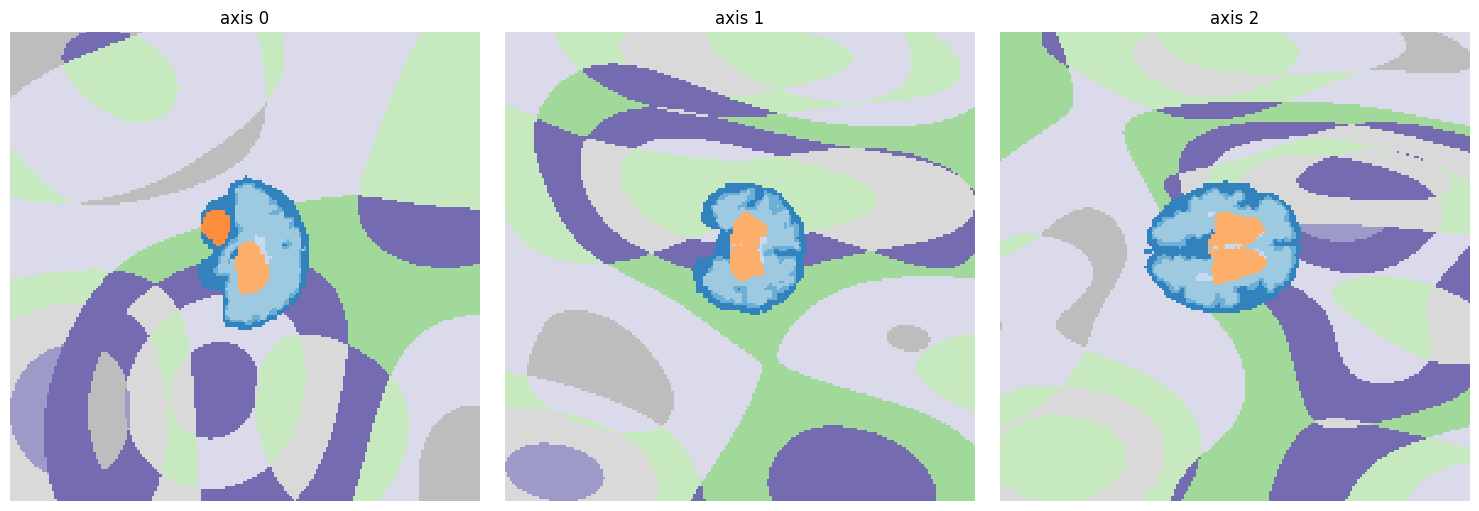

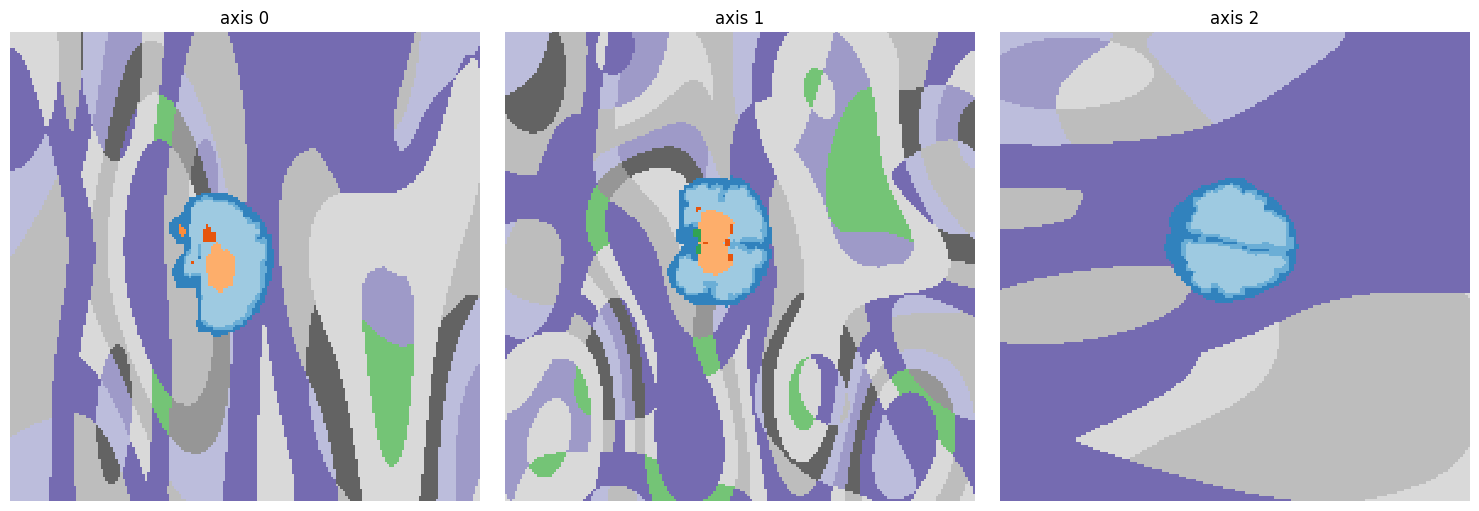

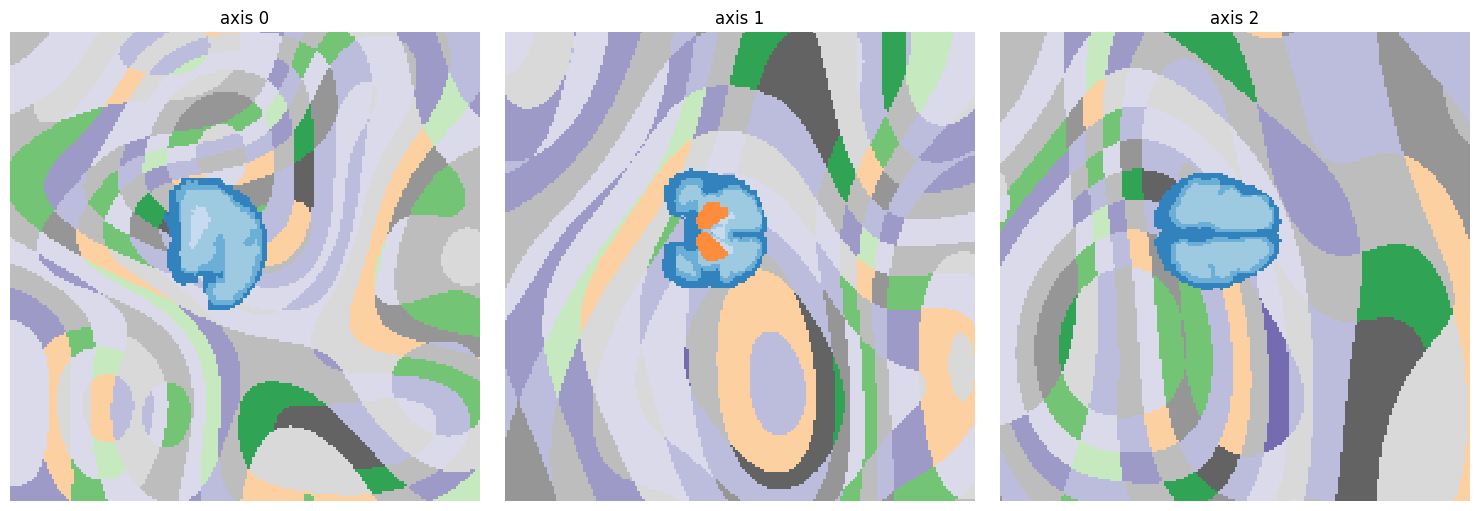

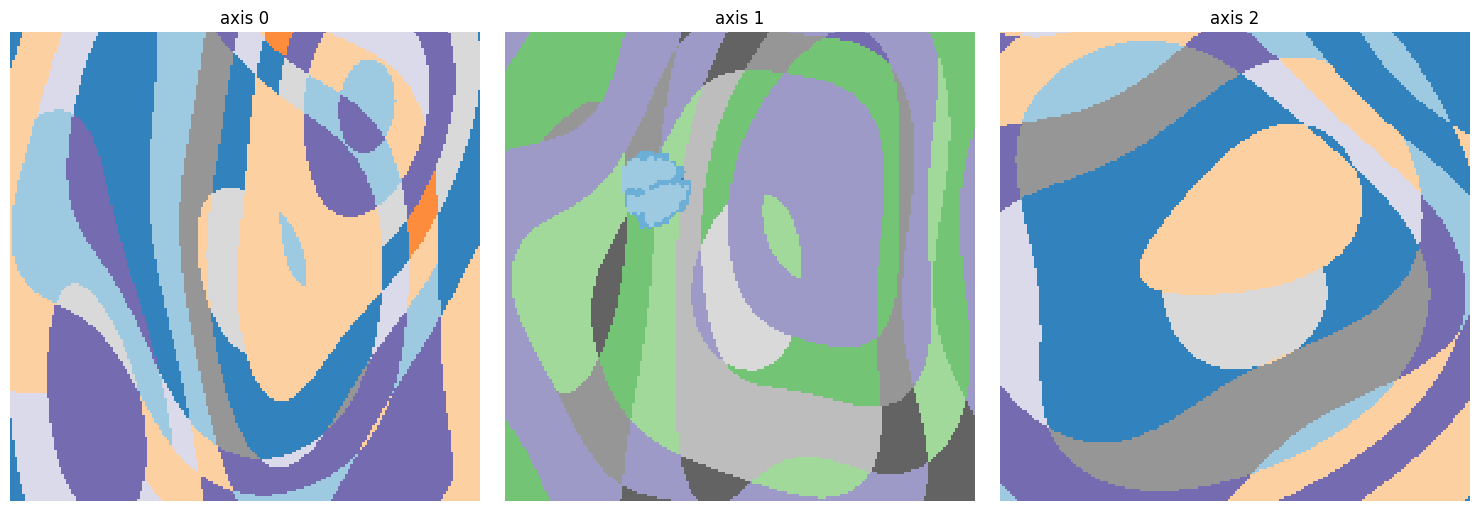

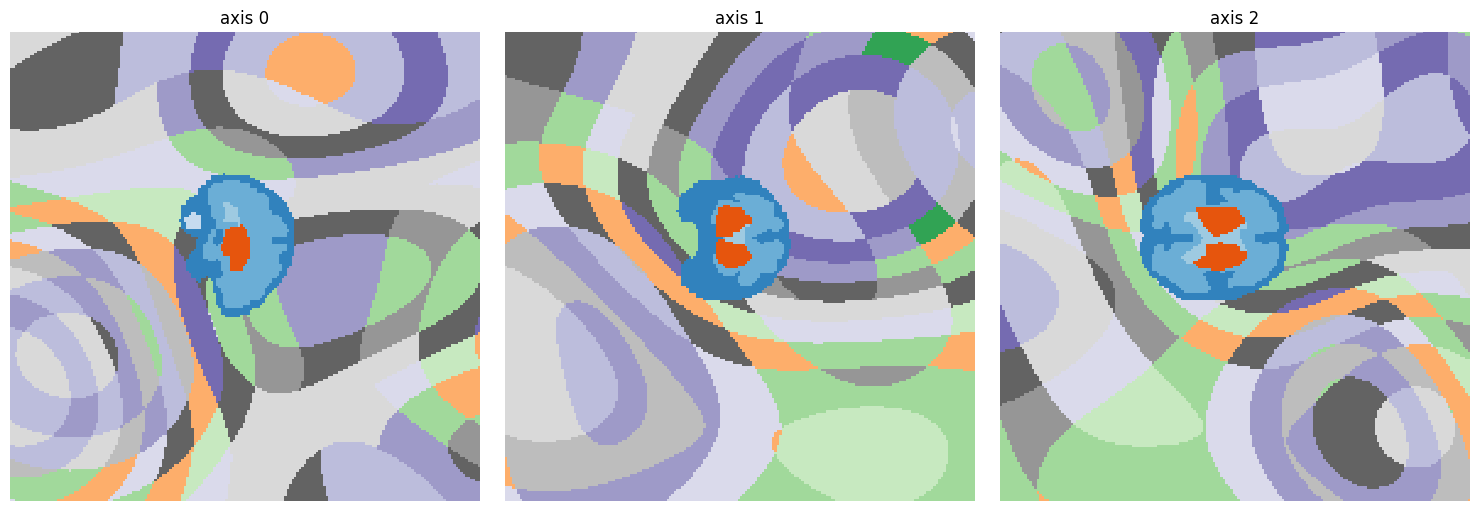

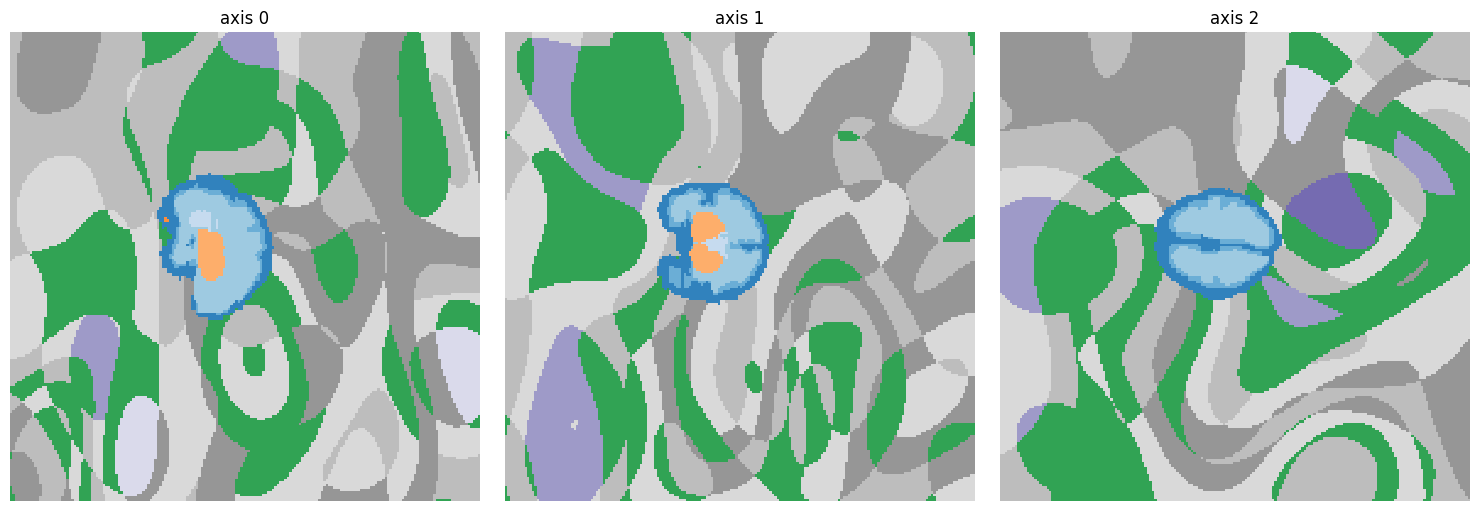

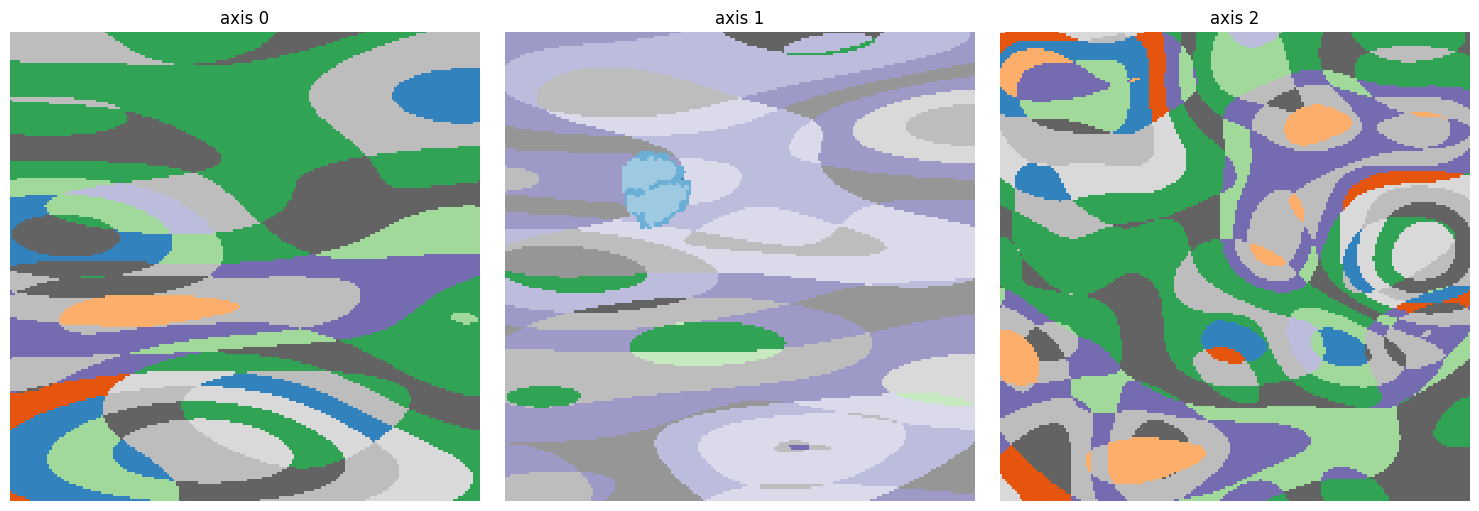

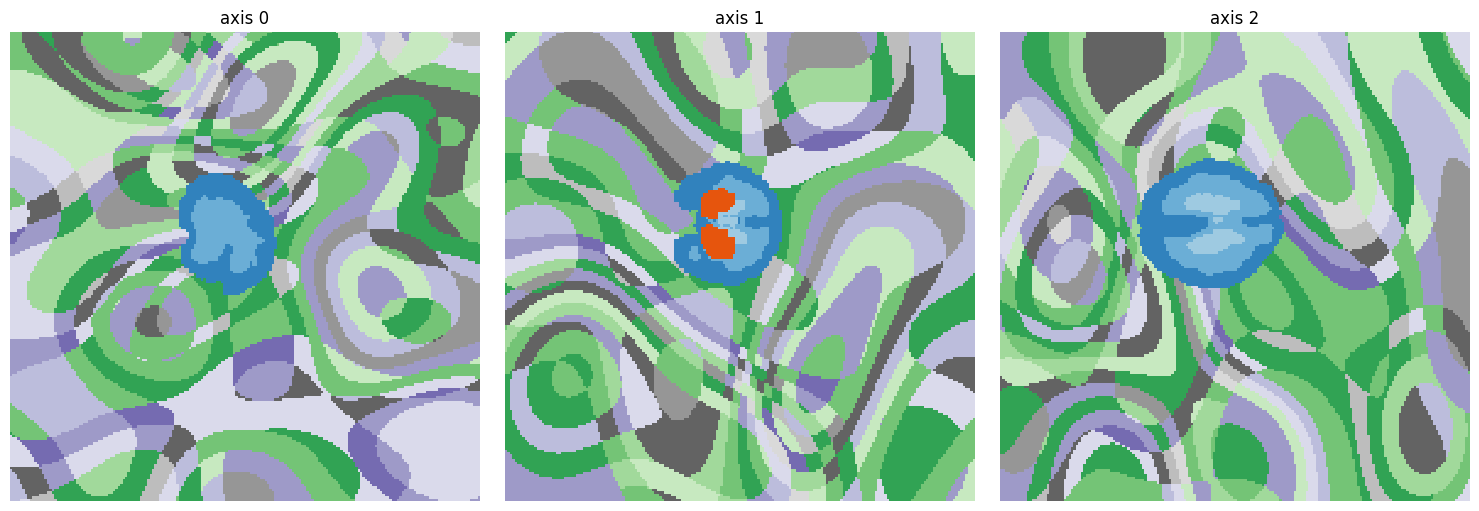

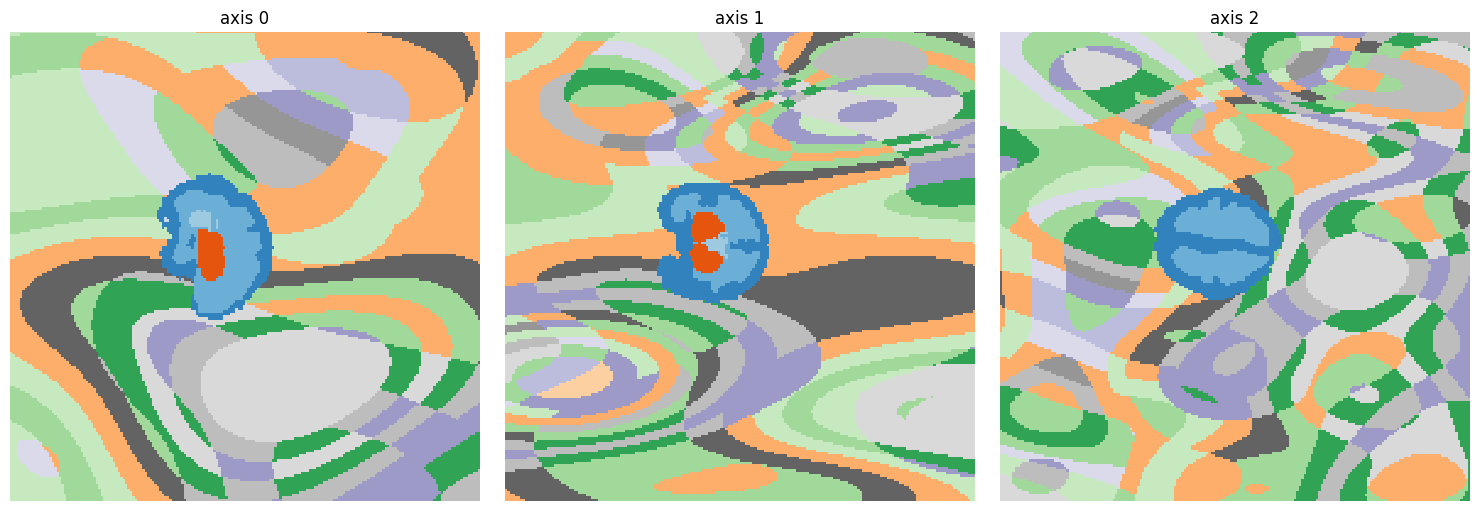

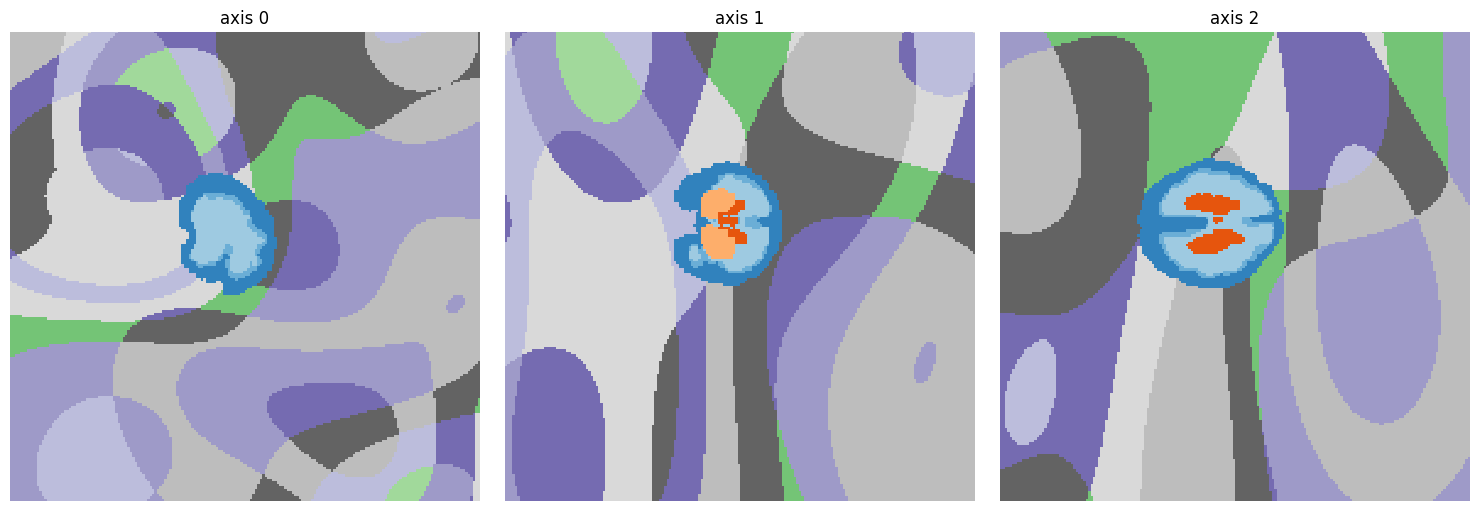

In [2]:
# from scipy.ndimage import binary_erosion
# from scipy.ndimage import binary_dilation

# def create_model(model_config):
#     # print(model_config)
#     return ne.models.labels_to_image_new(**model_config)
    
import json

with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

# Access the configuration

# model3_config = config["labels_to_image_model_with_shapes"]

# # Convert labels_out keys to integers for all models

# model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

# # Now you have the modified configuration

# model3 = create_model(model3_config)


# Access the configuration
model1_config = config["brain"]
model2_config = config["body"]
model_shapes_config = config["shapes"]

model3_config = config["labels_to_image_model"]
model4_config = config["labels_to_image_model_with_shapes_24"]

# Convert labels_out keys to integers for all models
model1_config["labels_out"] = {int(key): value for key, value in model1_config["labels_out"].items()}
model2_config["labels_out"] = {int(key): value for key, value in model2_config["labels_out"].items()}
model_shapes_config["labels_out"] = {int(key): value for key, value in model_shapes_config["labels_out"].items()}

model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

model4_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
# Now you have the modified configuration
# Brain
model1 = create_model(model1_config)
# Body
model2 = create_model(model2_config)

#shapes
model_shapes = create_model(model_shapes_config)


# Model
labels_to_image_model = create_model(model3_config)

labels_to_image_model_with_shapes = create_model(model4_config)

#brain
model1 = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={i: i if i in (1, 2, 3, 4, 5, 6, 7) else 0 for i in labels_in},
    warp_min=0.1,  # Adjust this value for a small warping change
    warp_max=0.2,  # Adjust this value for a small warping change
    one_hot=False,
    aff_rotate=20,
    aff_shift=0,
    up_scale=False,
    aff_scale=0.0

)

#body
model2 = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={i: 0 if i in (1, 2, 3, 4, 5, 6, 7) else i for i in labels_in},
    aff_rotate=5,
    aff_shear=0.0,
    aff_shift=1,
    blur_max=1,
    warp_min=0.1,  # Adjust this value for a small warping change
    warp_max=1,  # Adjust this value for a small warping change
    slice_prob=1,
    one_hot=False,
    crop_prob=1,
    aff_scale=1

)

#both
model3 = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={f: 1 if f in (1, 2, 3, 4, 5, 6, 7) else 0 for f in labels_in},
    warp_min=0.01,  # Adjust this value for a small warping change
    warp_max=2,  # Adjust this value for a small warping change
    blur_max=1,
    noise_min=0.0,
    noise_max=0.1,
    one_hot=True,
    zero_background=0.2,
    aff_scale=0.5,
    mean_min=[0.2 if f in (1, 2, 3, 4, 5, 6, 7) else 0.0 for f in labels_in],
    mean_max=[1.0 if f in (1, 2, 3, 4, 5, 6, 7) else 0.8 for f in labels_in]

)

in_shape = model3_config["in_shape"]
num_gen = 10
output_labels = []
num_shapes=2
brain_maps = feta_label_maps#get_brain(label_maps)
shapes=[]
for i in range(num_gen):
    def deform(s):
        num_sets = 8
        ind = tf.random.uniform(shape=(num_sets,), maxval=num_sets, dtype=tf.int32)
        ind = tf.cast(ind, dtype=tf.uint8)
        s = tf.cast(s, dtype=tf.int32)  # Convert s to int32
        return tf.gather(ind, indices=s)
    shapes = [ draw_shapes_easy(shape = (192,)*3)  for i in range(10)]      
    shapes = [tf.squeeze(s,axis=-1)+8 for s in shapes]
    # shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
    # shapes = map(np.squeeze, shapes)
    # shapes = map(np.uint8, shapes)

    # shapes2 = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
    # shapes2 = map(np.squeeze, shapes2)
    # shapes2 = map(np.uint8, shapes2)

    # shapes = [deform(s) for s in shapes]
    # shapes2 = [deform(s)+deform(s2) for s in shapes for s2 in shapes2]

    # shapes = [f + 7 + 1 for f in shapes2]
    # shapes = tf.squeeze(shapes,axis=-1)
    gen = generator(brain_maps, shapes)

    # brain_maps = feta_label_maps#get_brain(label_maps)
    # shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
    # shapes = map(np.squeeze, shapes)
    # shapes = map(np.uint8, shapes)
    # shapes = [f for f in shapes]
    # gen = generator_shapes(shapes)

    output_label = next(gen)
    output_labels.append(output_label)
    nib.save(nib.Nifti1Image(np.squeeze(output_label, axis=(0, -1)).astype(np.int32), np.eye(4), header=None), f"samples/feta_shapes_label_map_{i}.nii.gz")
    ne.plot.volume3D(np.squeeze(output_label, axis=(0, -1)), cmaps=['tab20c'])

            


In [3]:
print(output_label.shape)

(1, 192, 192, 192, 1)


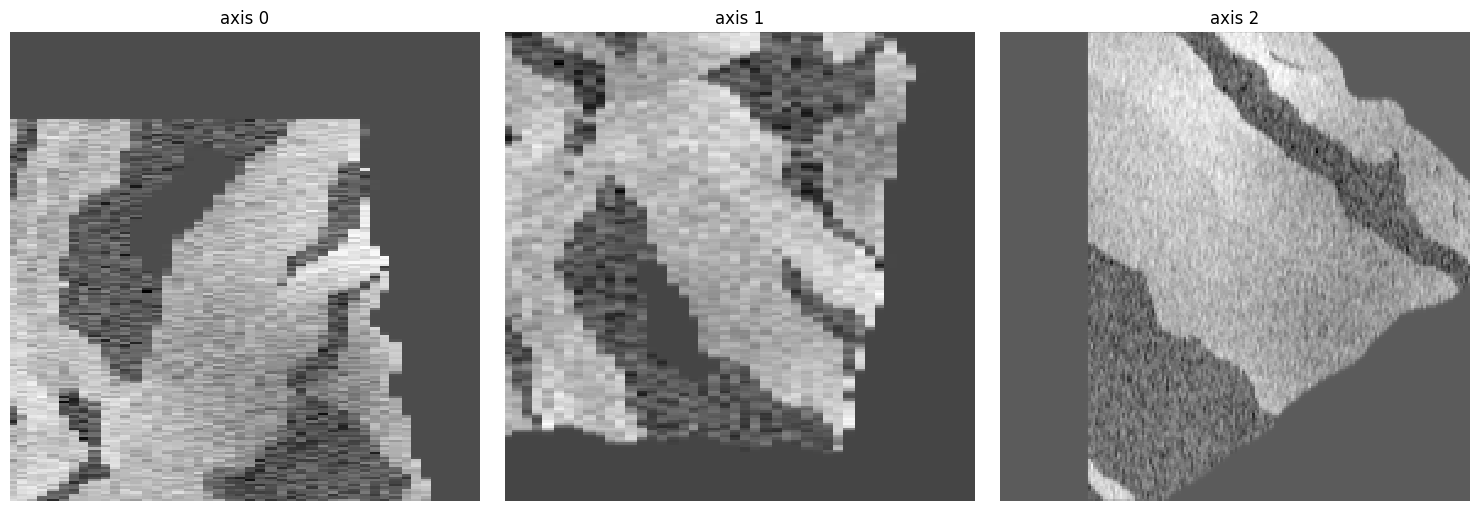

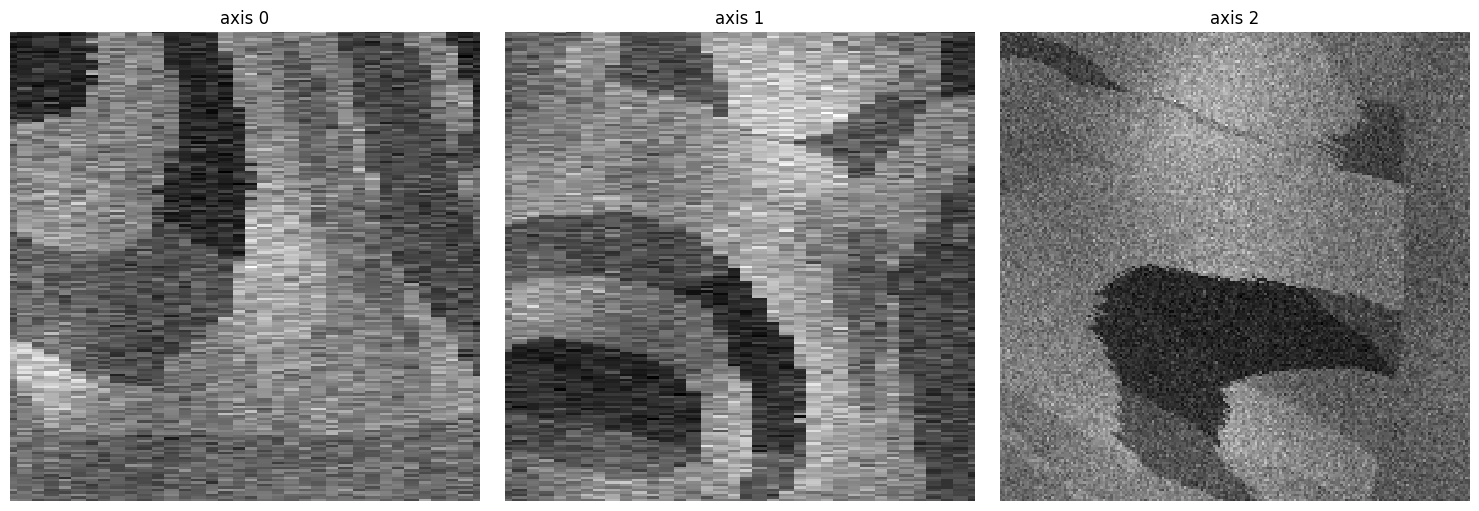

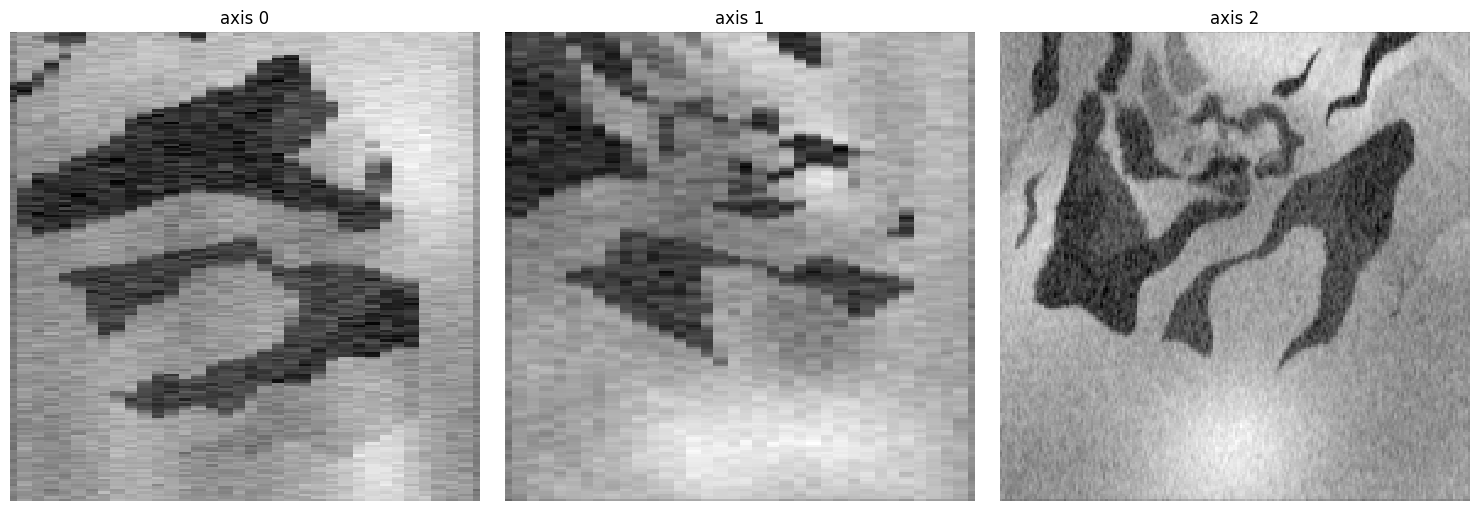

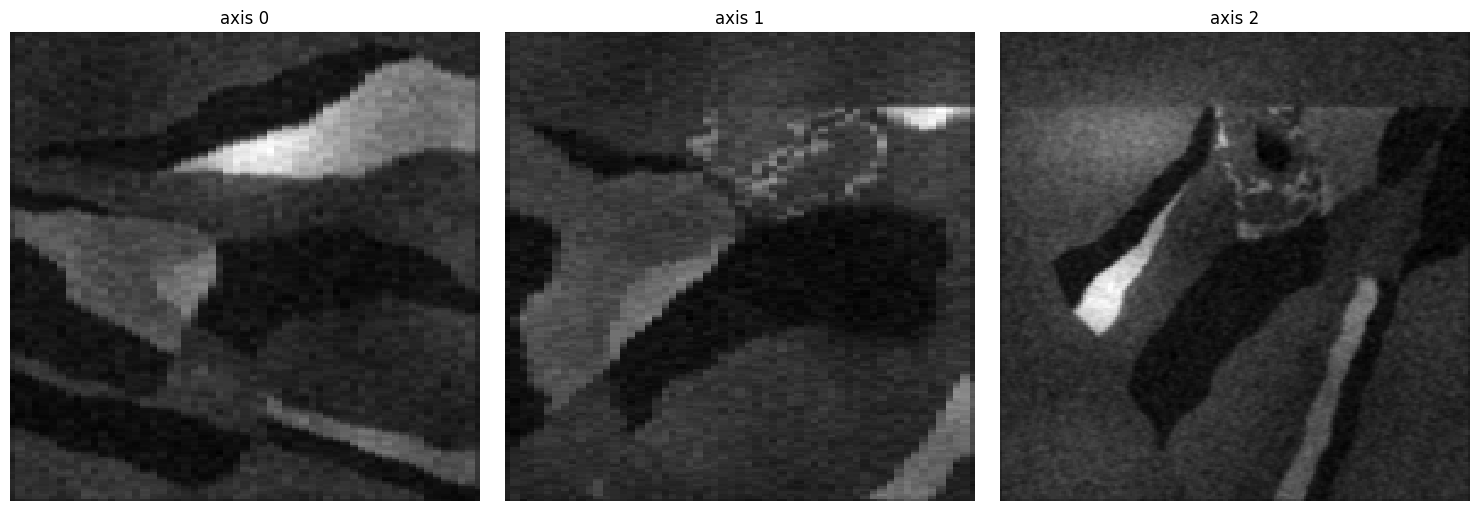

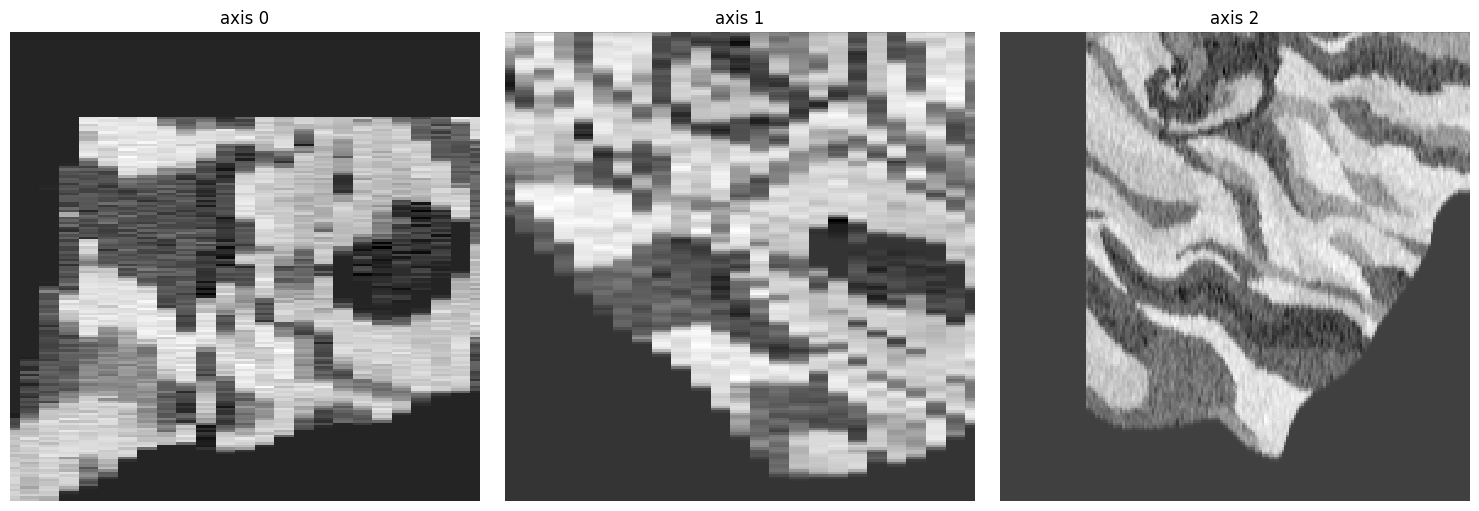

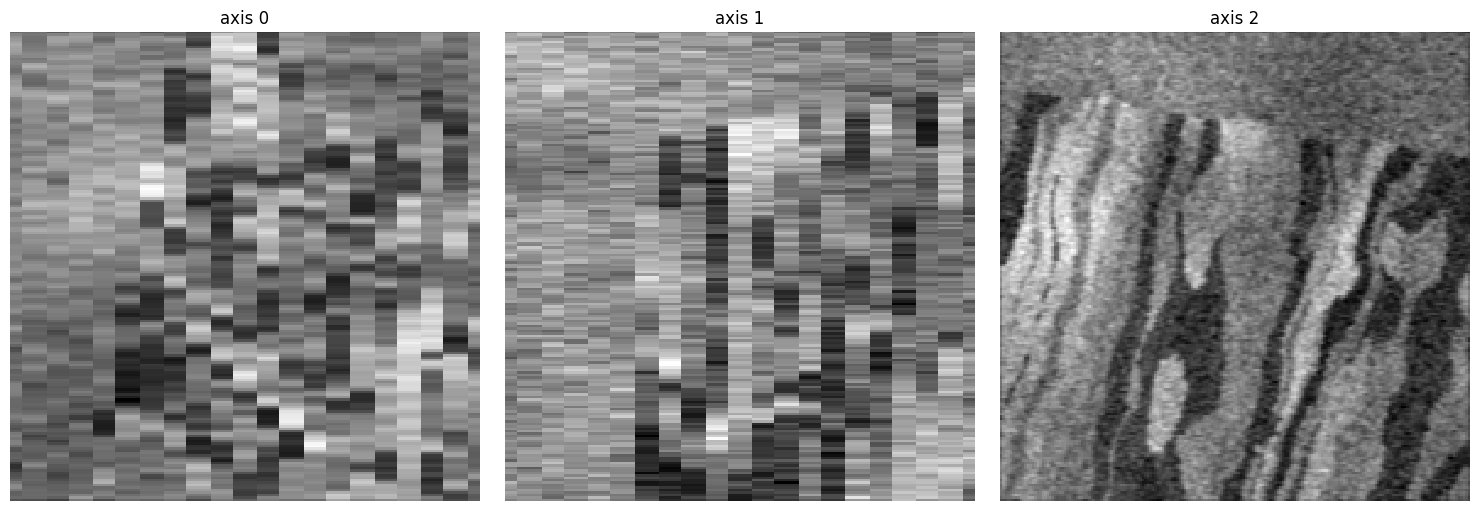

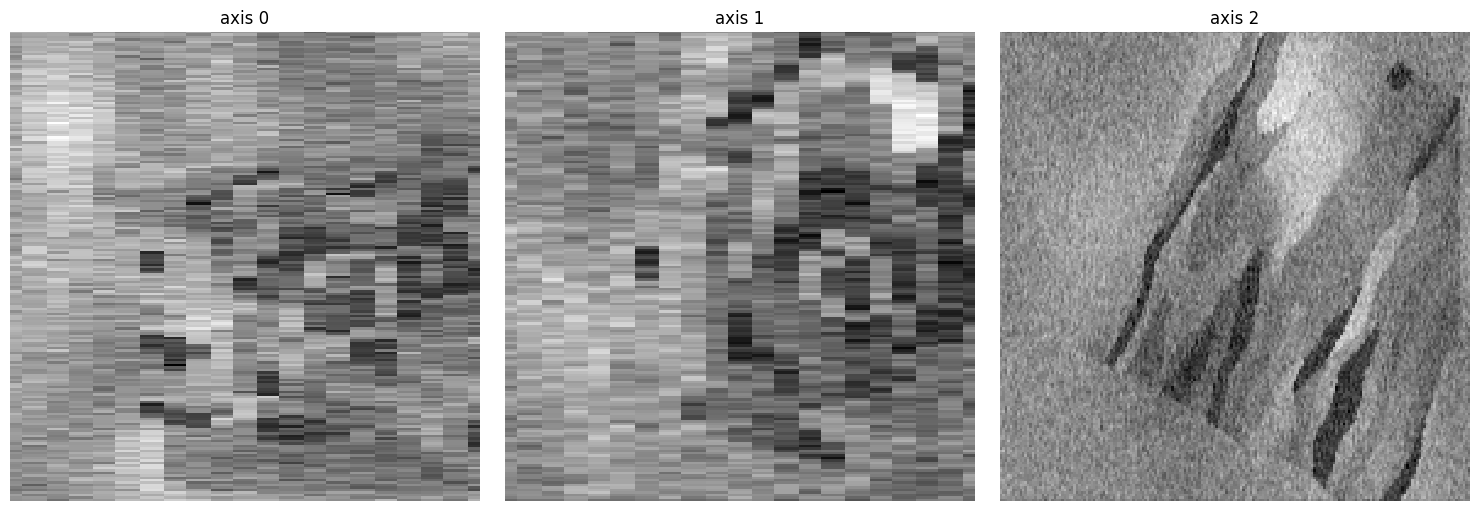

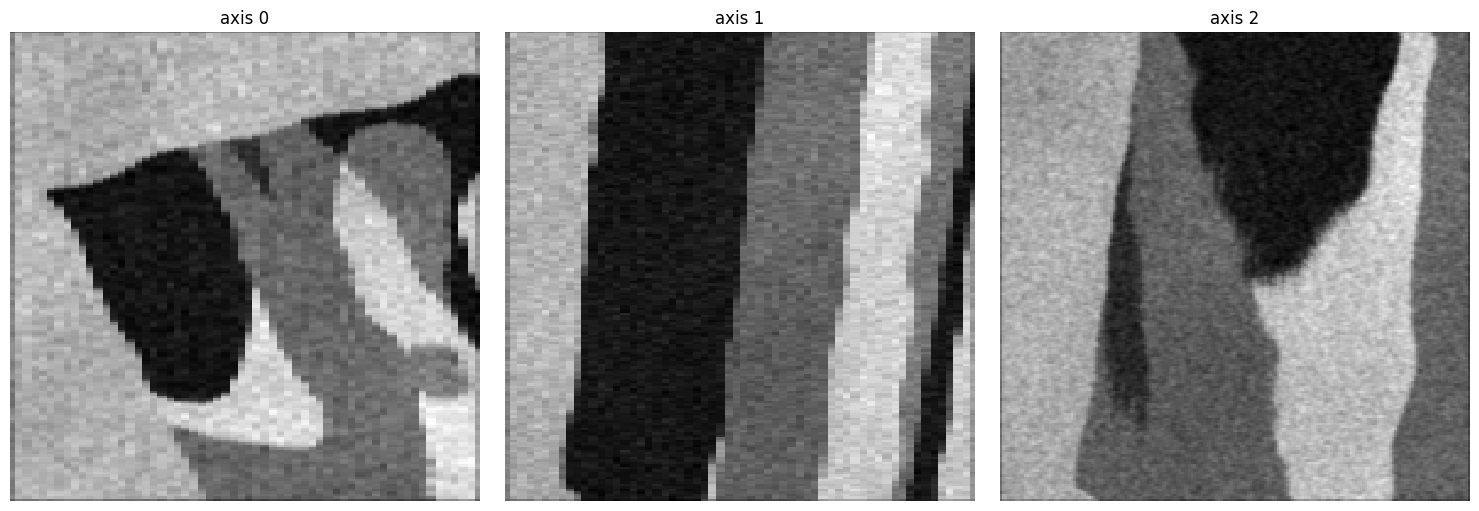

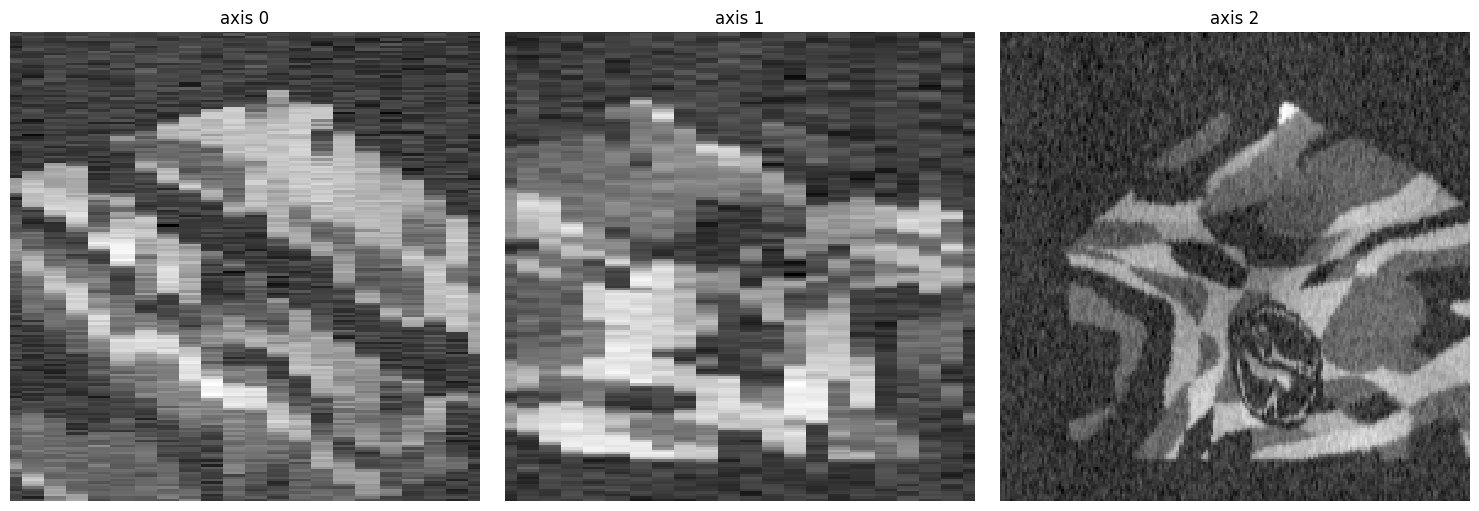

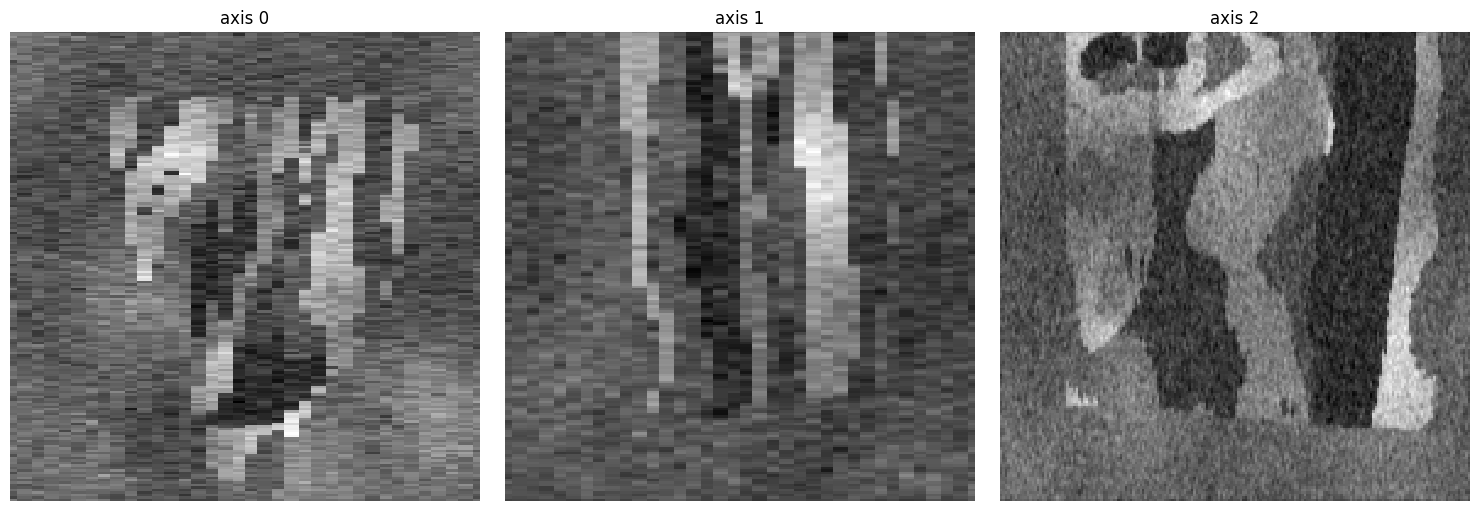

In [5]:
# print(output_brain.shape)
images = []
one_hots = []
slices_at_com = []
images_at_com = []
main_folder = "validation_synth"
import numpy as np
from scipy.ndimage import label

    
for i in range(num_gen):
    a = output_labels[i]
    # subfolder_path = os.path.join(main_folder, f"image_{i}")

    generated_img, y = labels_to_image_model_with_shapes(a)
    generated_img = np.squeeze(generated_img,axis=(0,-1))
    
    # print(generated_img.shape,mask.shape)
    # mask1 = np.squeeze(np.argmax(y,axis=-1),axis=0)

    ne.plot.volume3D(generated_img,cmaps=['gray'])
    # mask = fit_bounding_rect_box(y)
    # print(y.shape)

    y = tf.argmax(y, axis=-1, output_type=tf.int32)
    y = np.squeeze(y,axis=0)

    # print(y.shape)

    # ne.plot.volume3D(y,cmaps=['gray'])

    # print("shape after box",mask.shape)
    # mask = np.argmax(mask,axis=-1)
    # mask = np.squeeze(mask,axis=0)

    
    # ne.plot.volume3D(mask,cmaps=['gray'])


2024-03-14 14:26:31.855291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0


(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)


2024-03-14 14:26:49.649539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


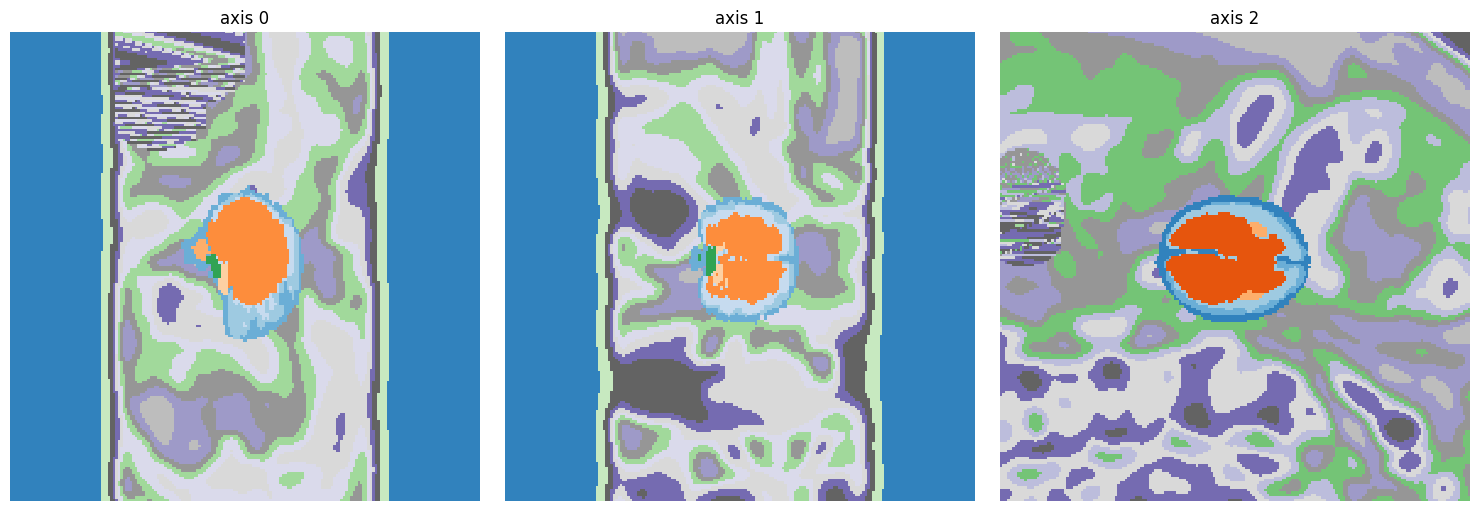

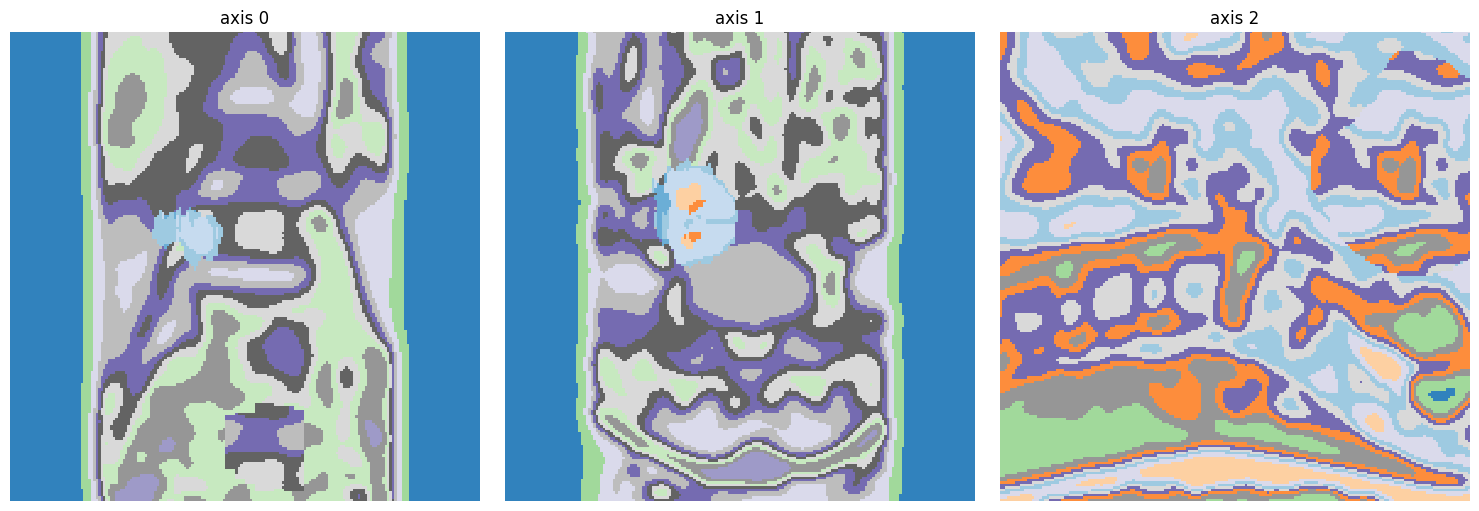

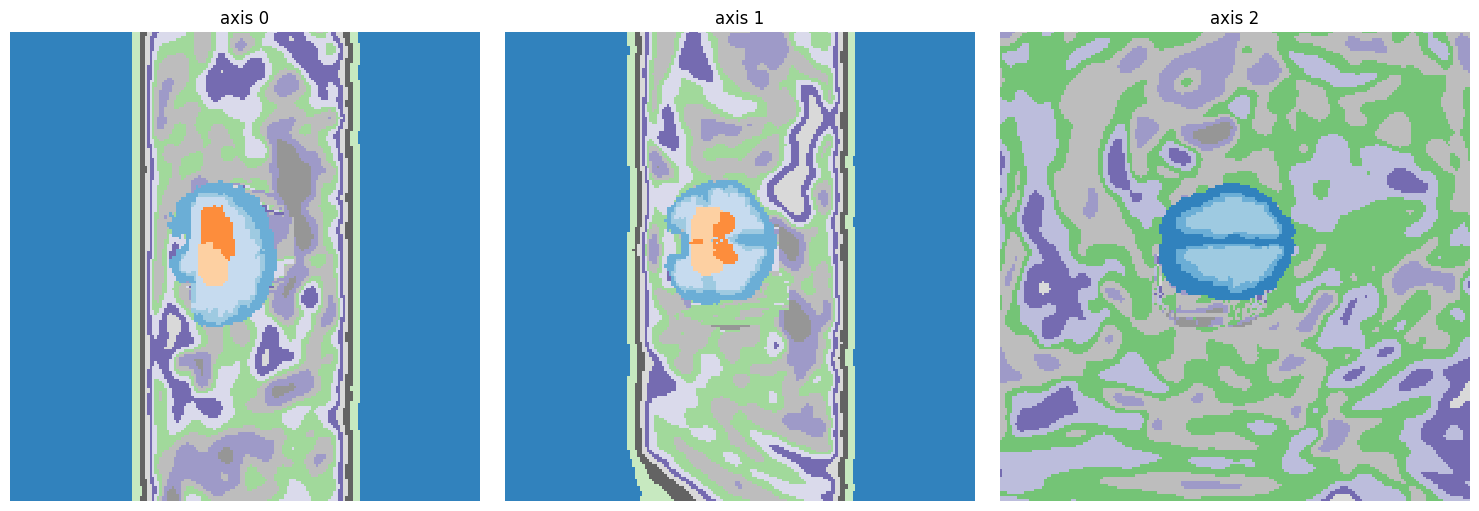

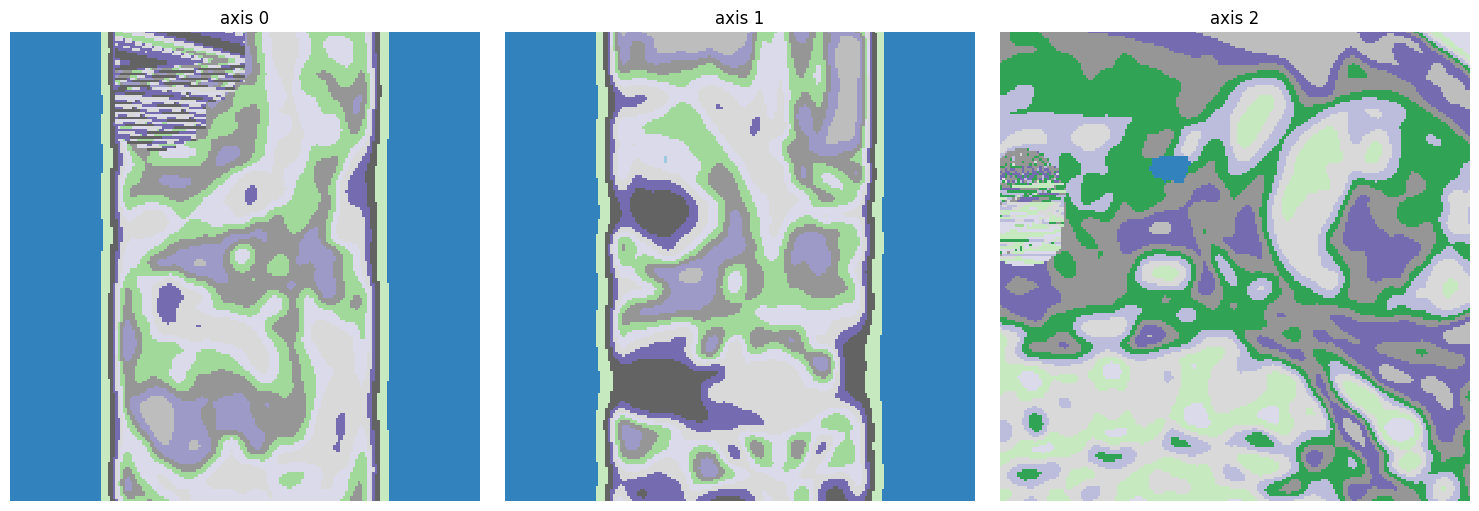

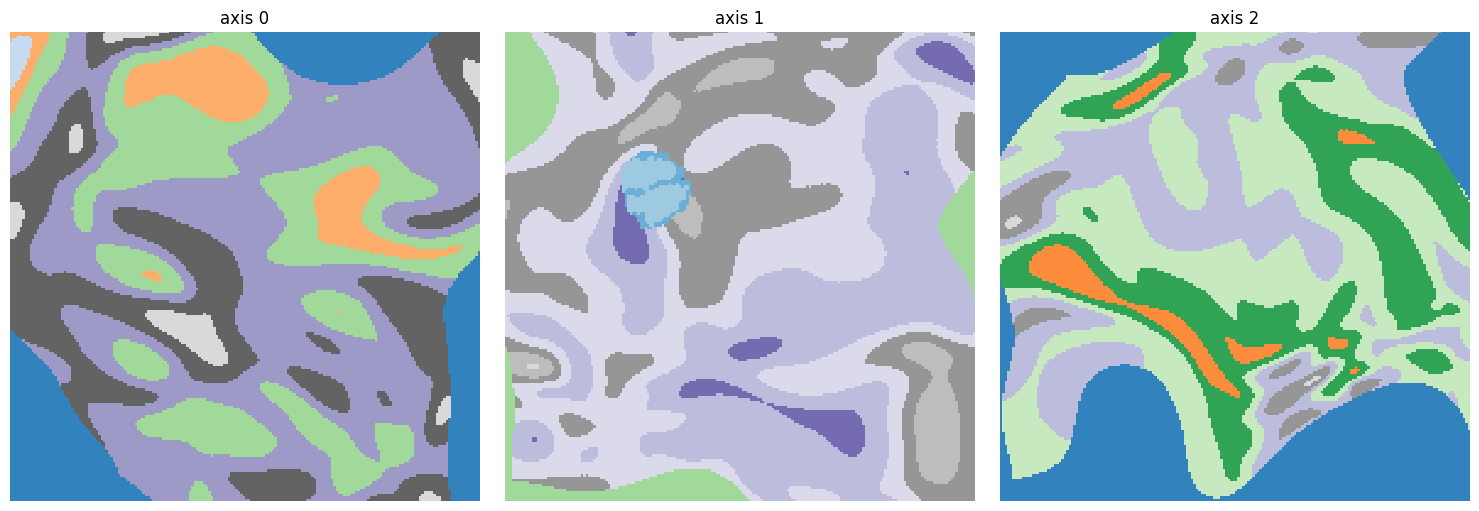

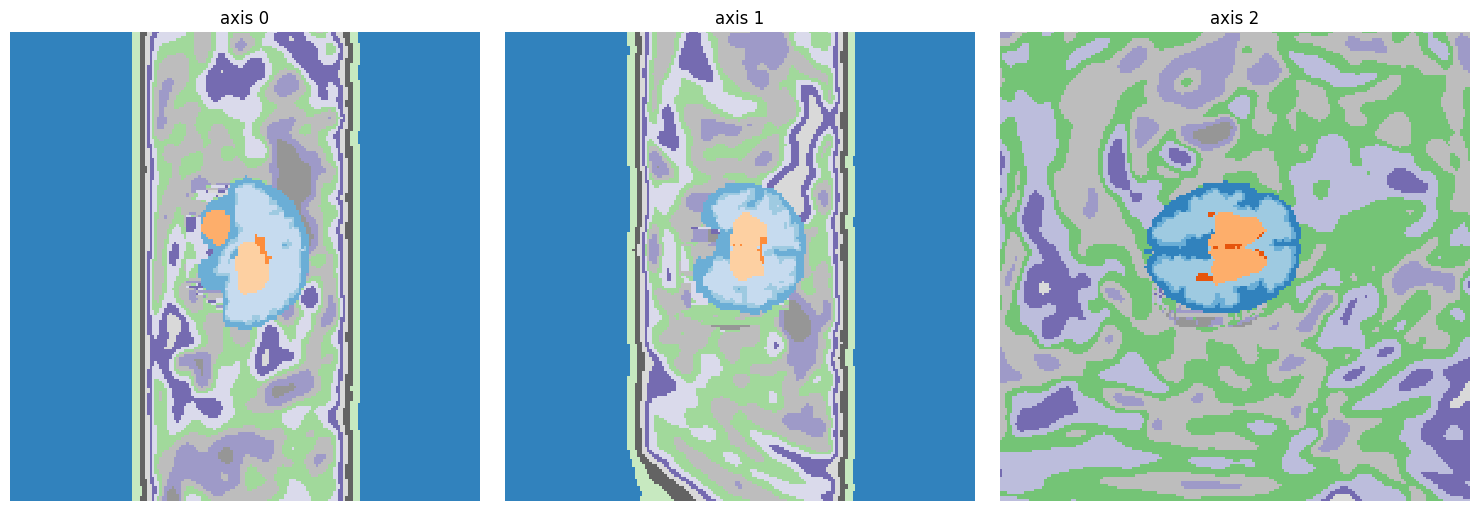

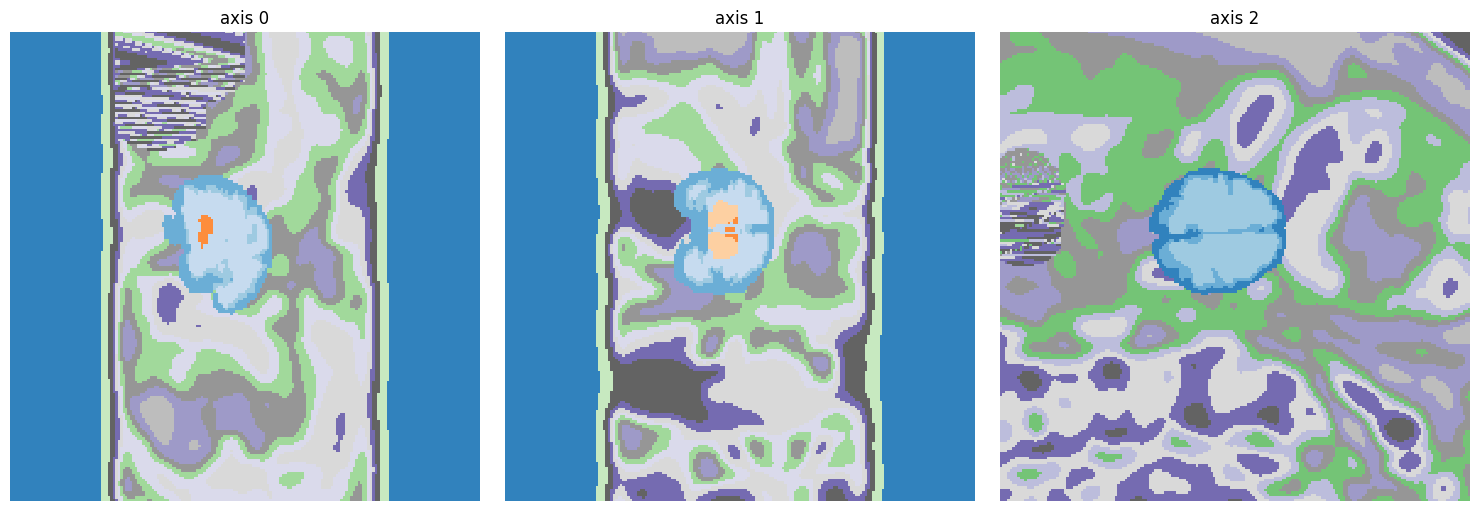

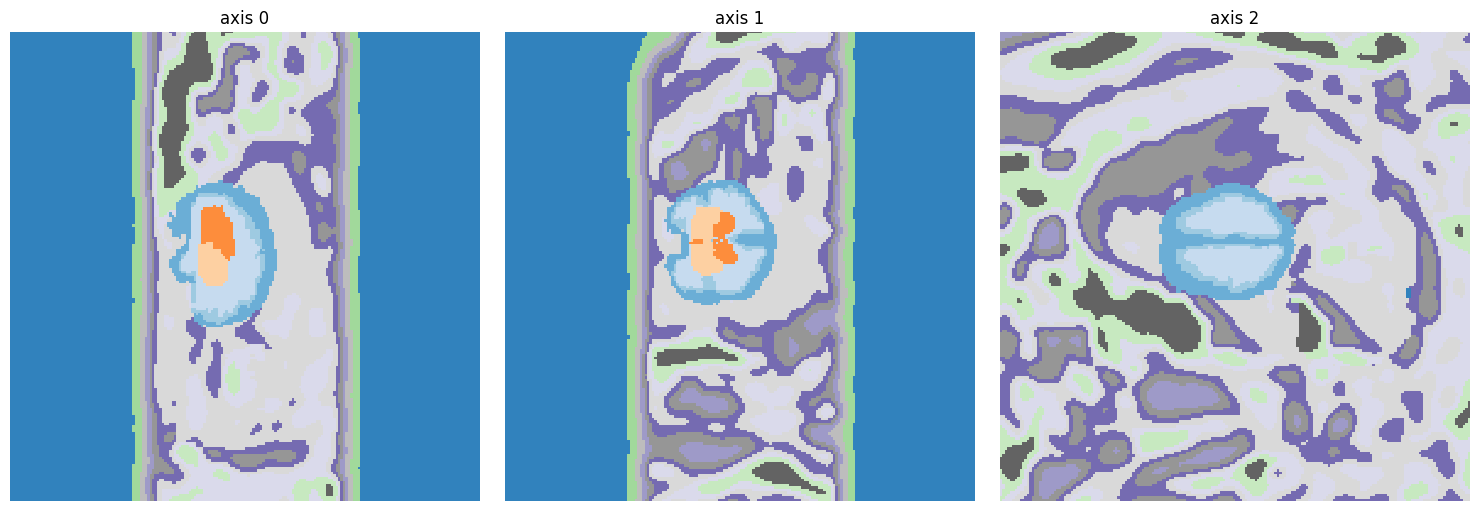

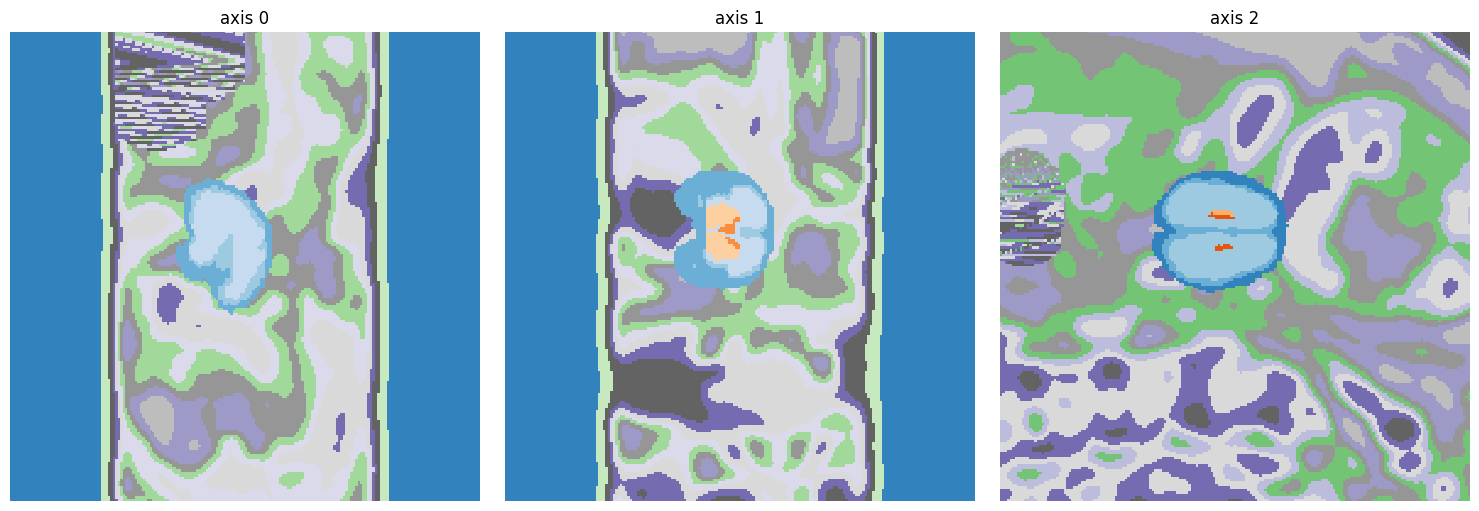

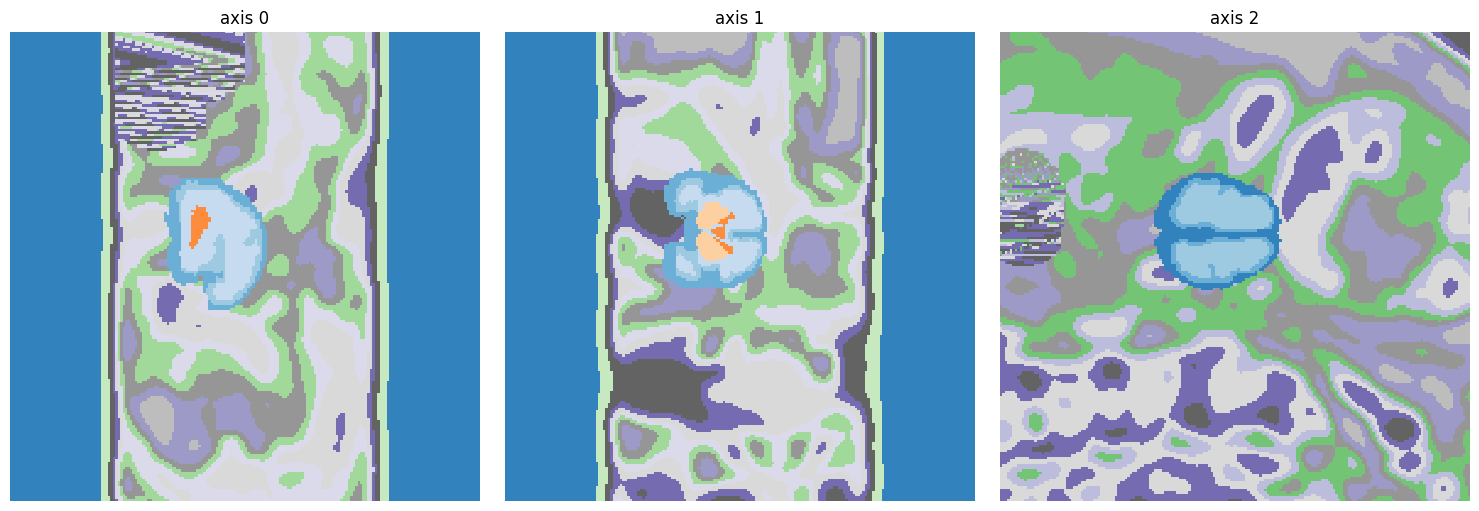

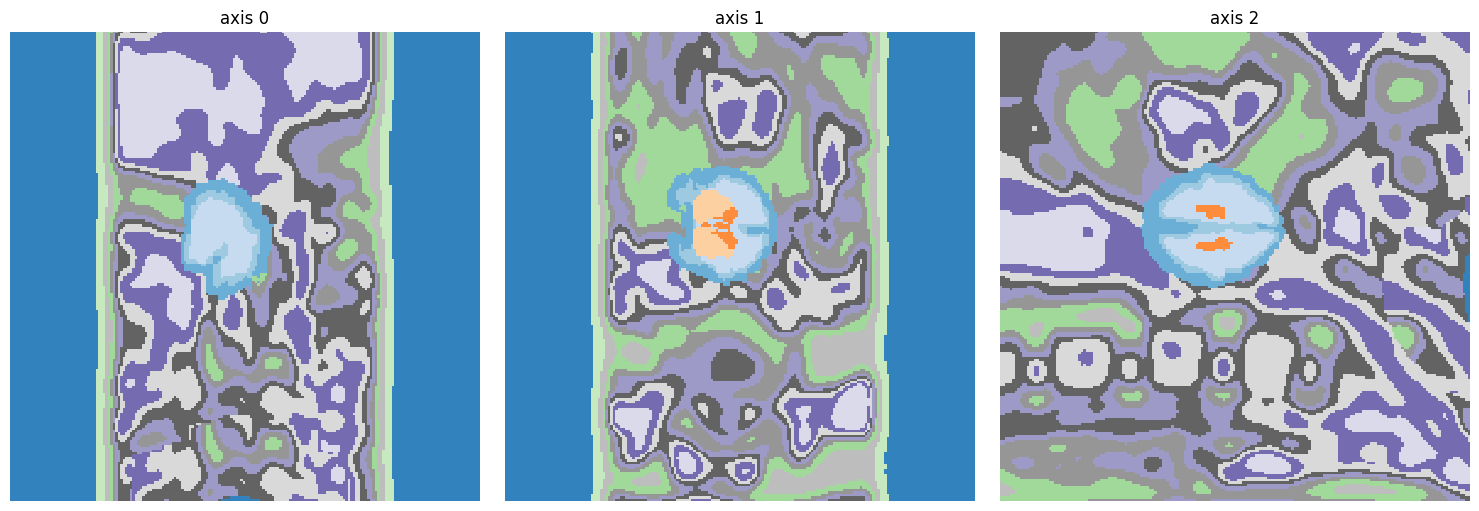

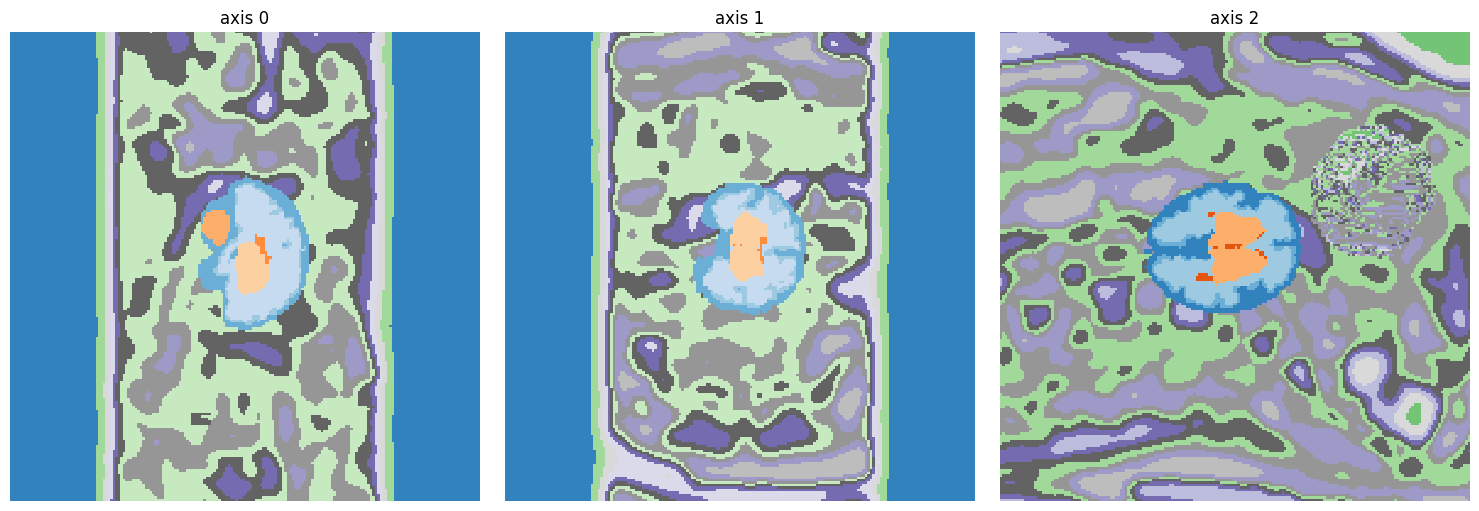

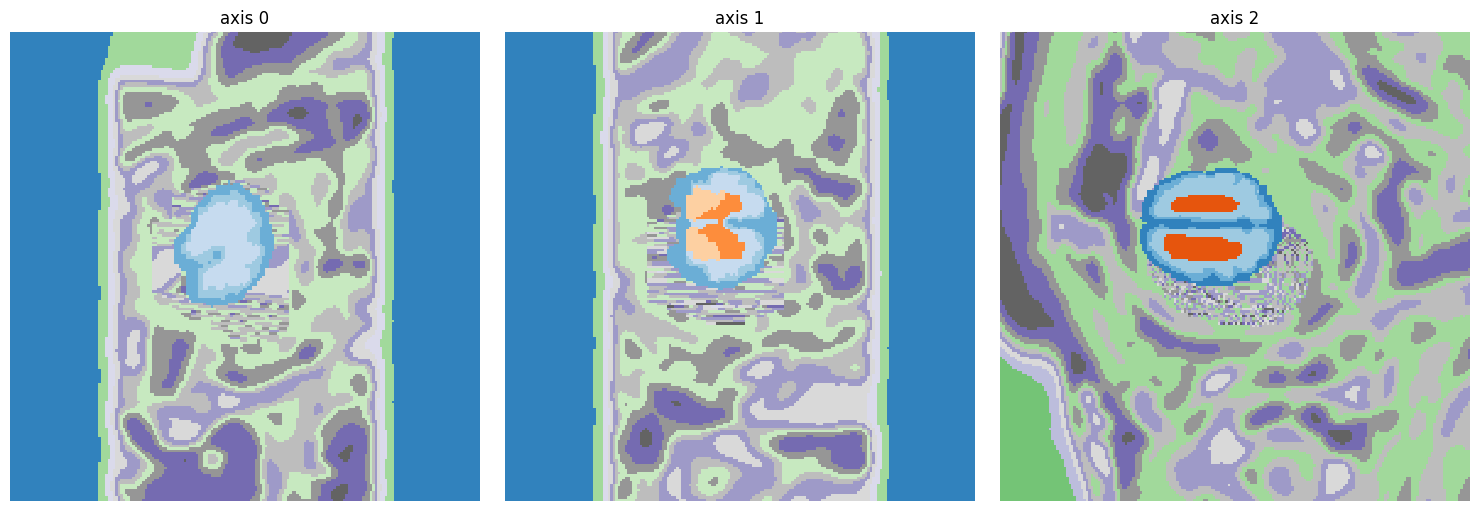

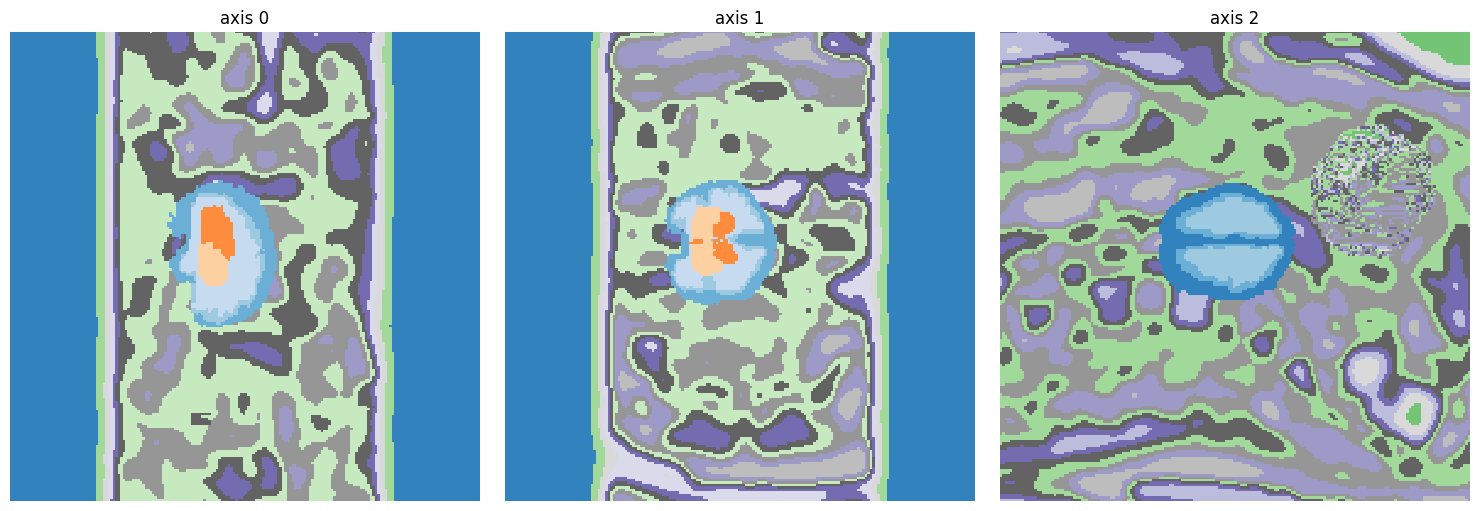

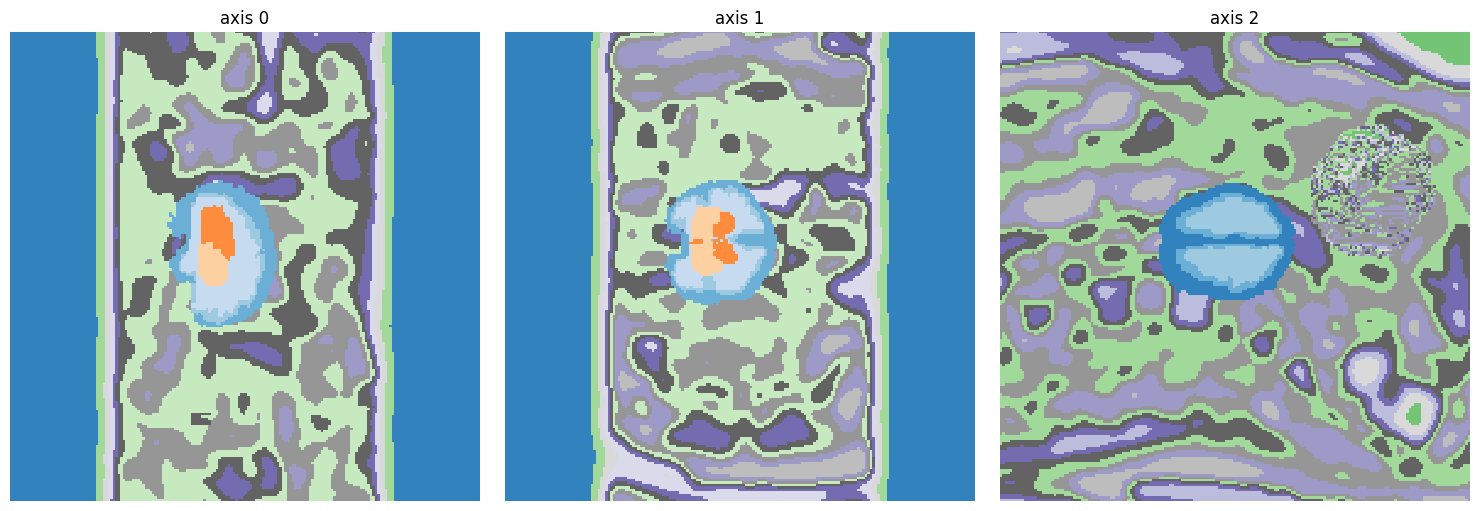

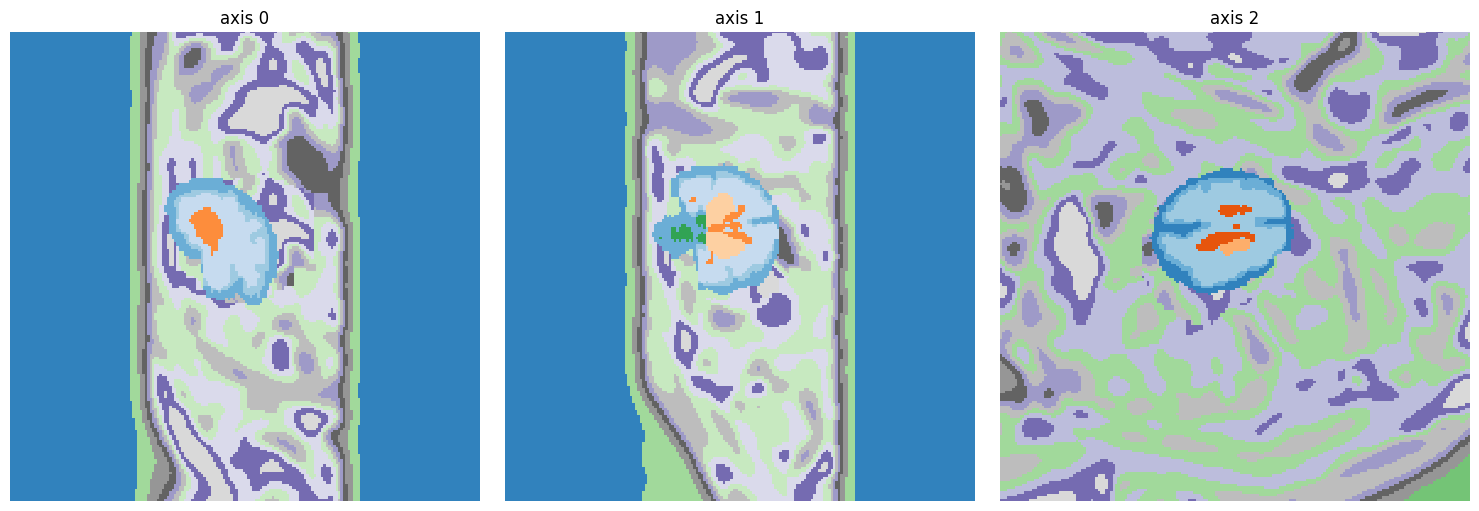

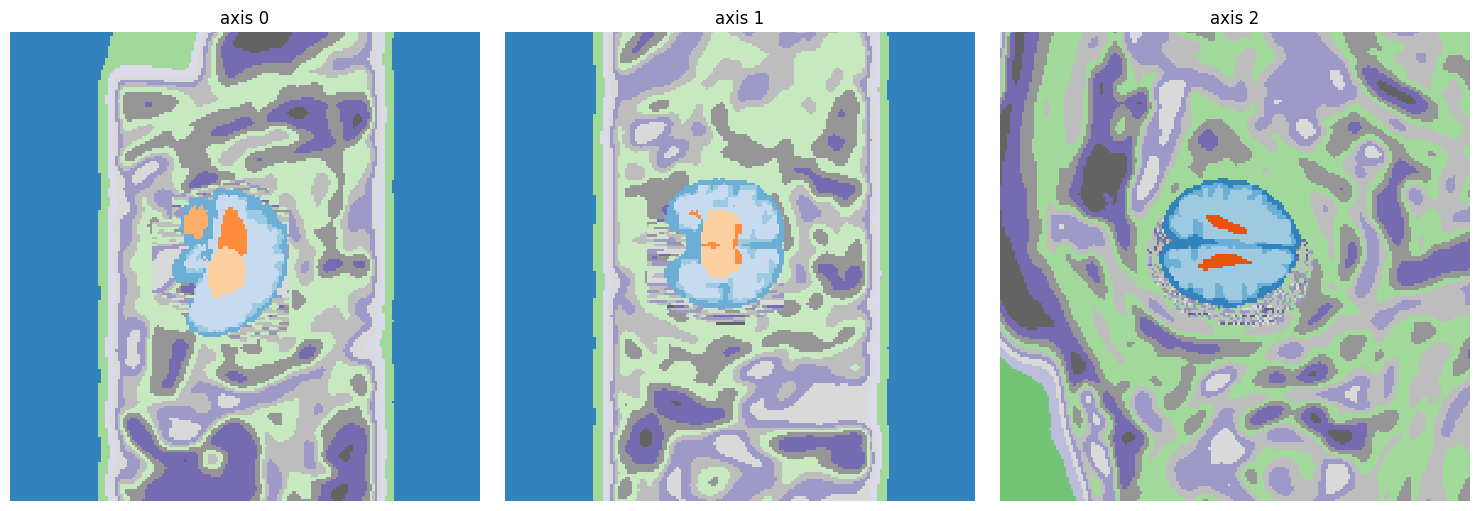

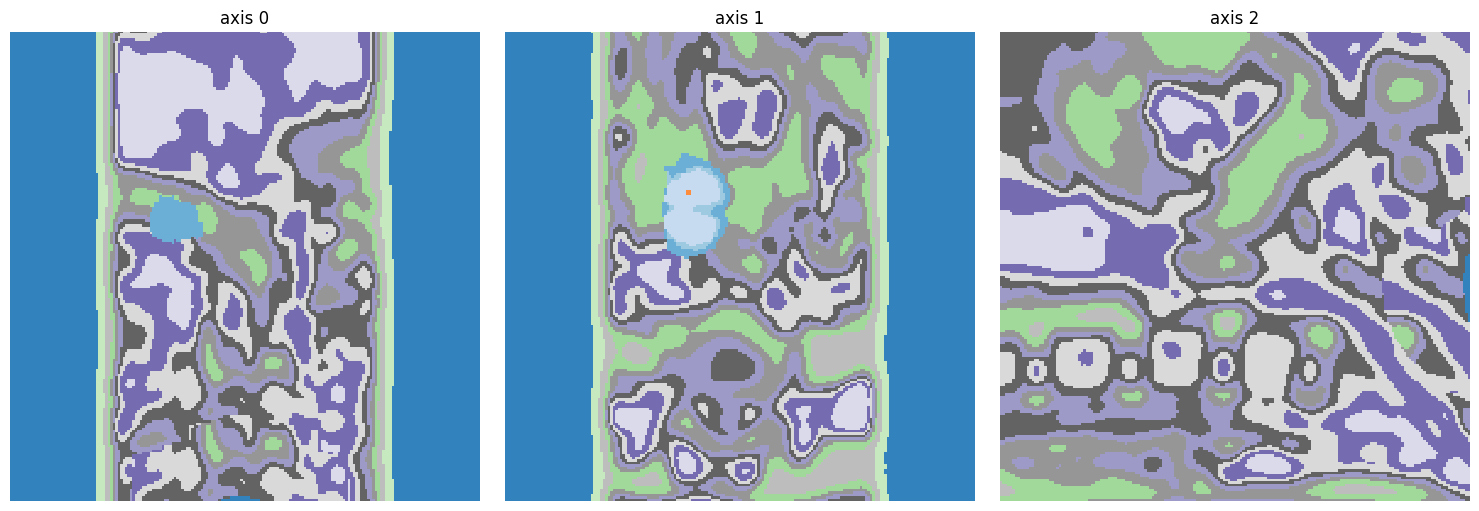

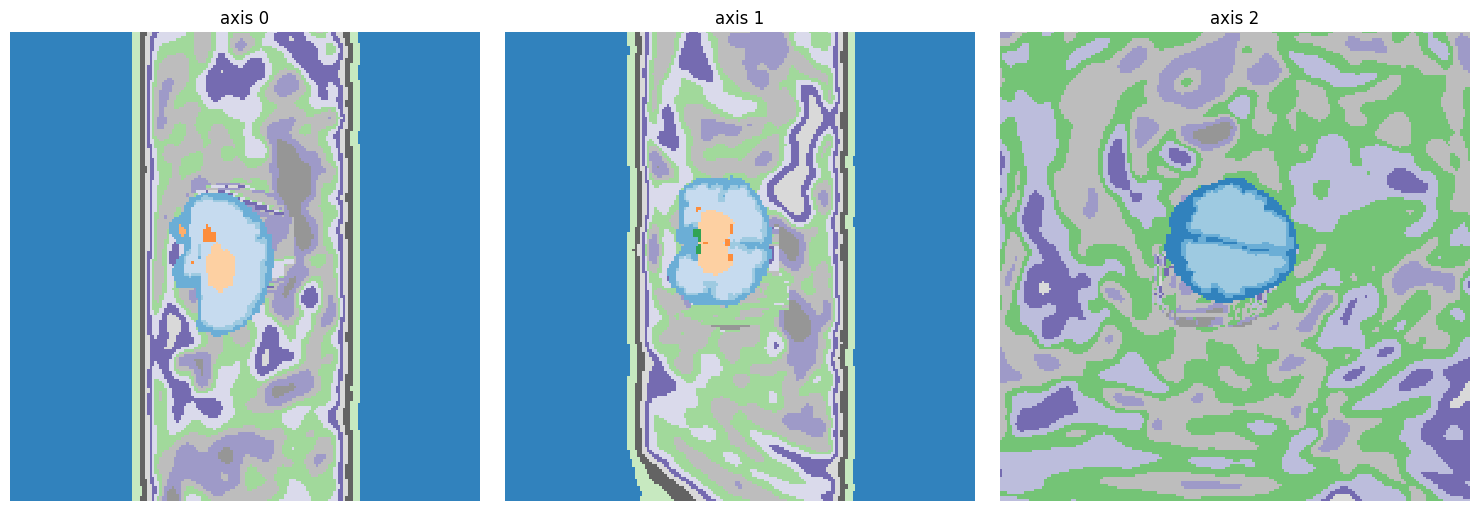

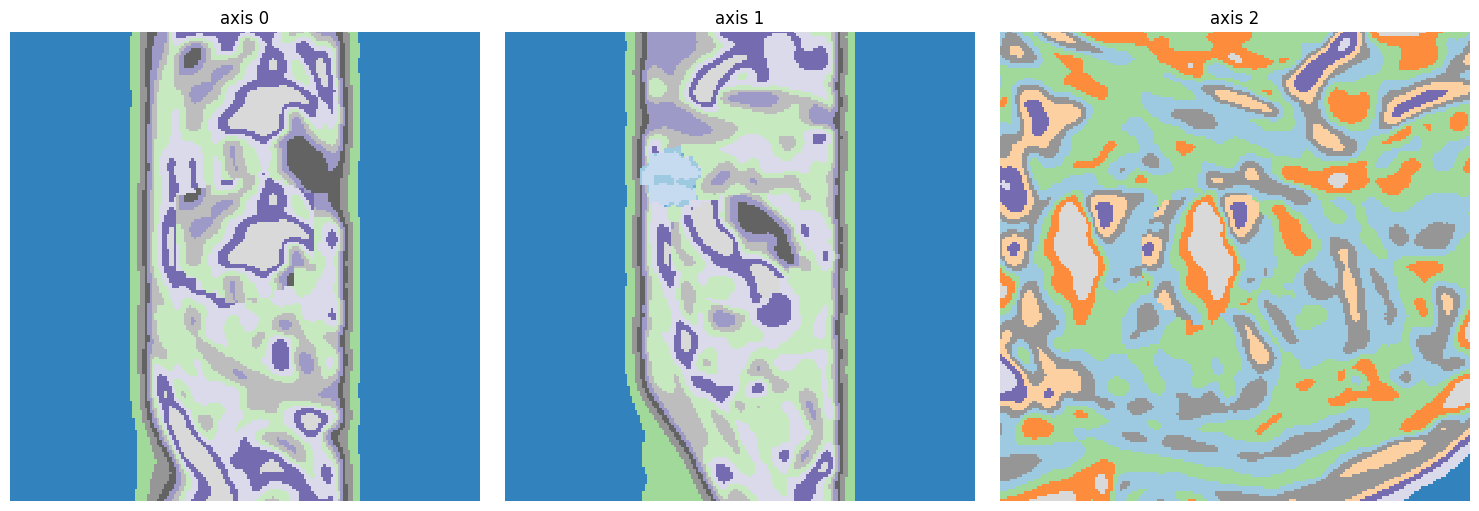

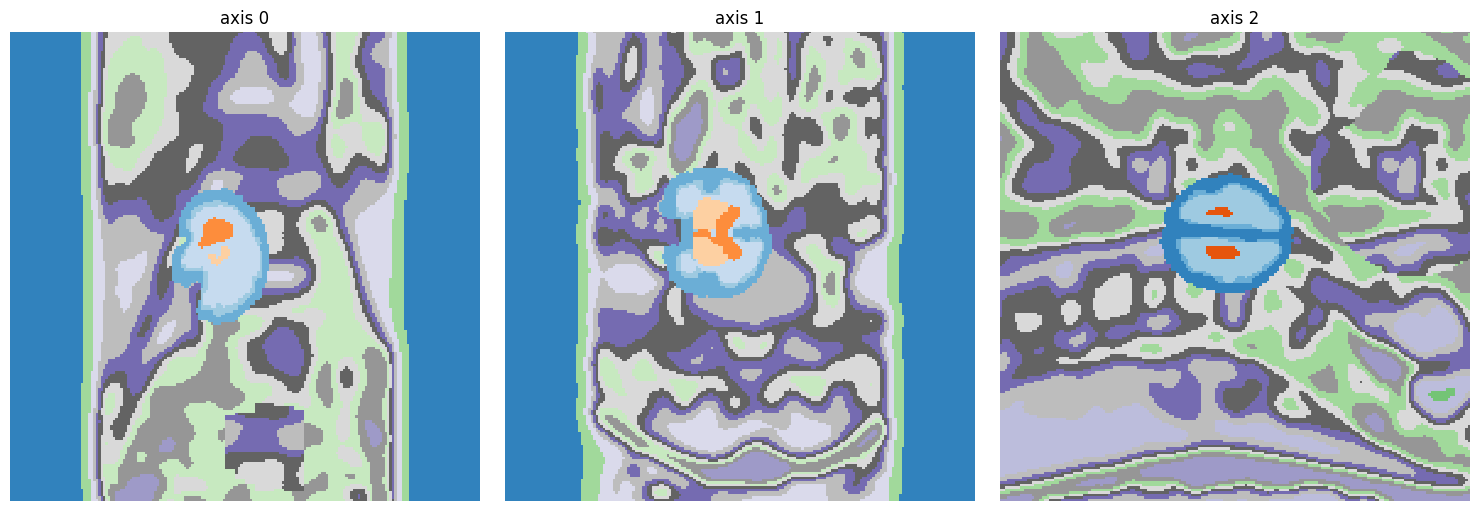

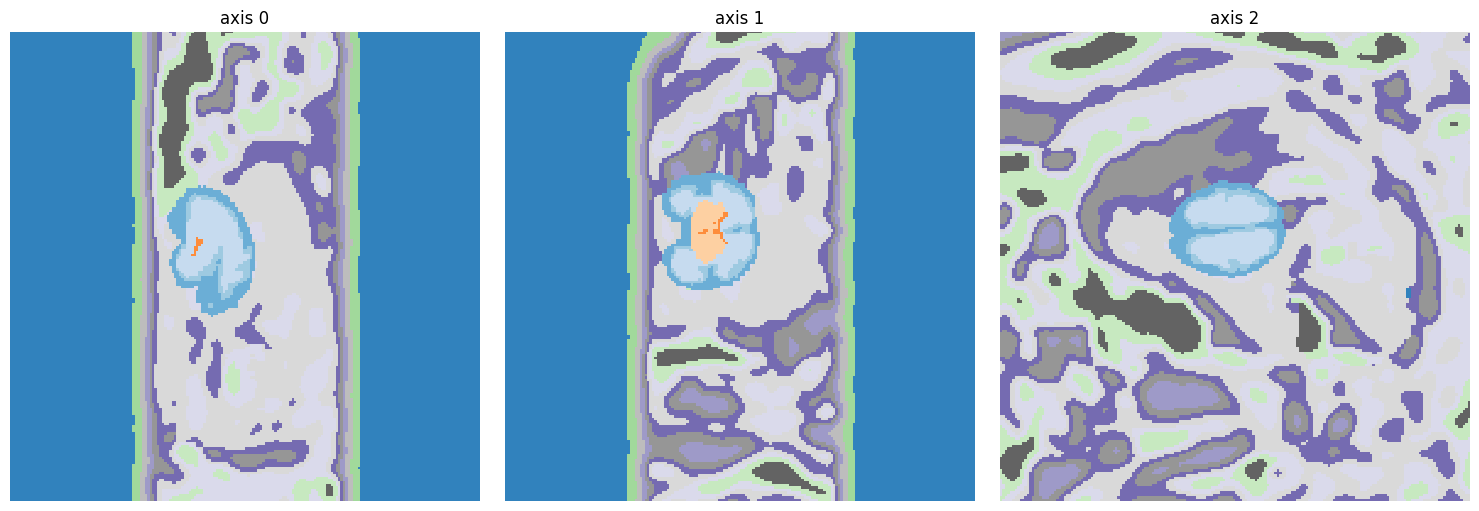

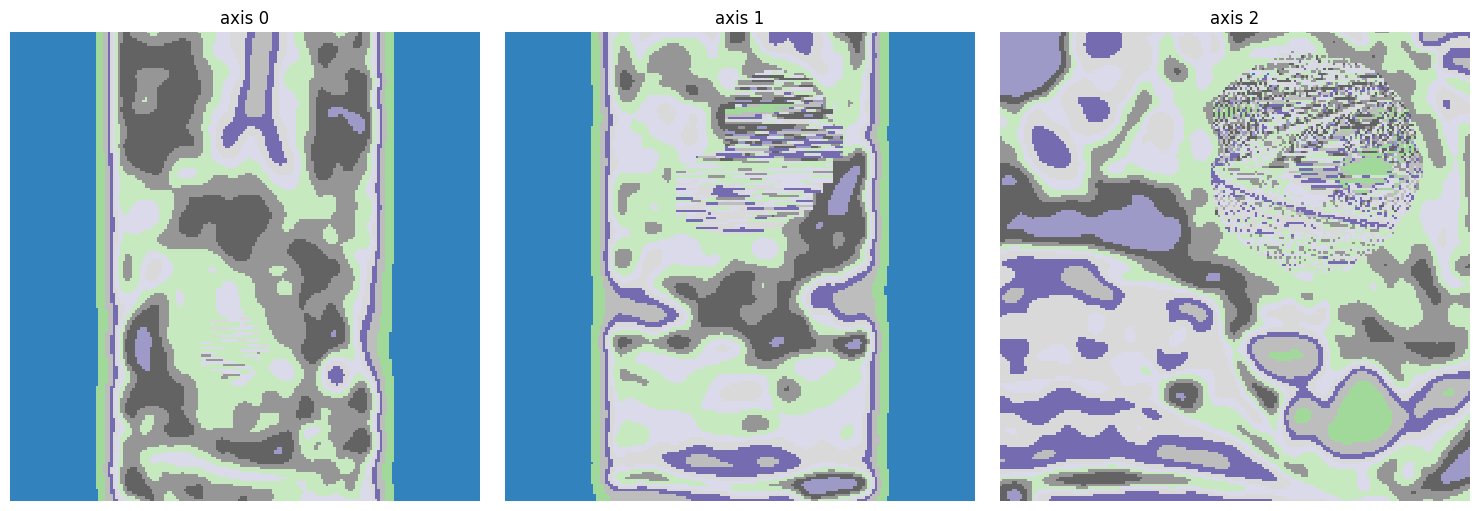

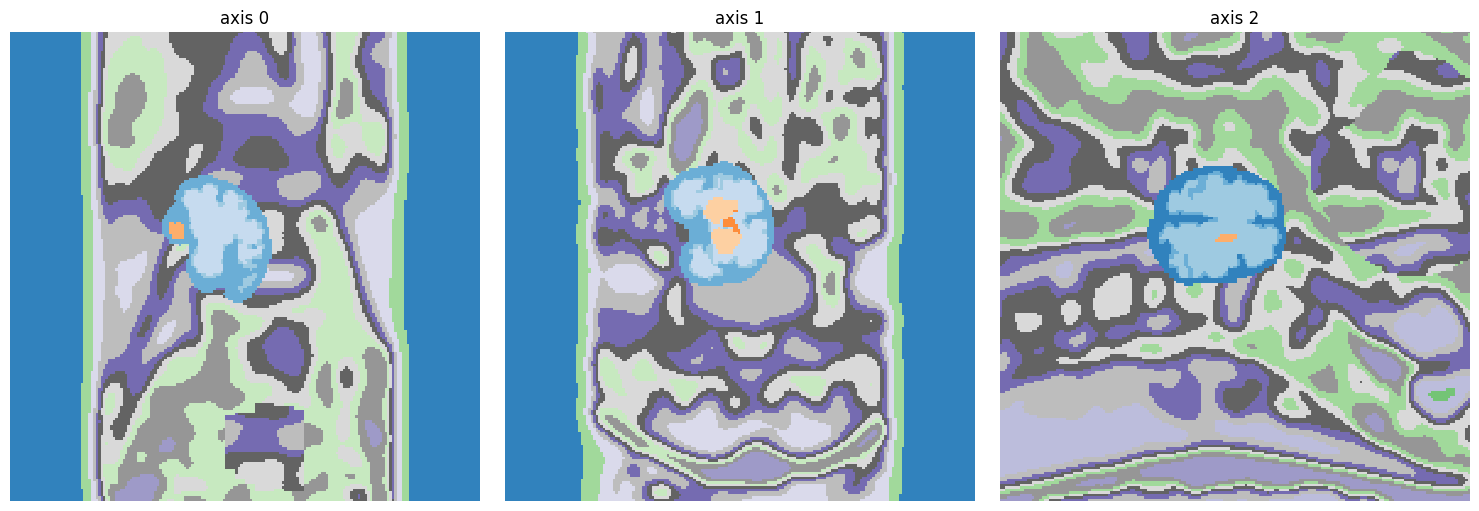

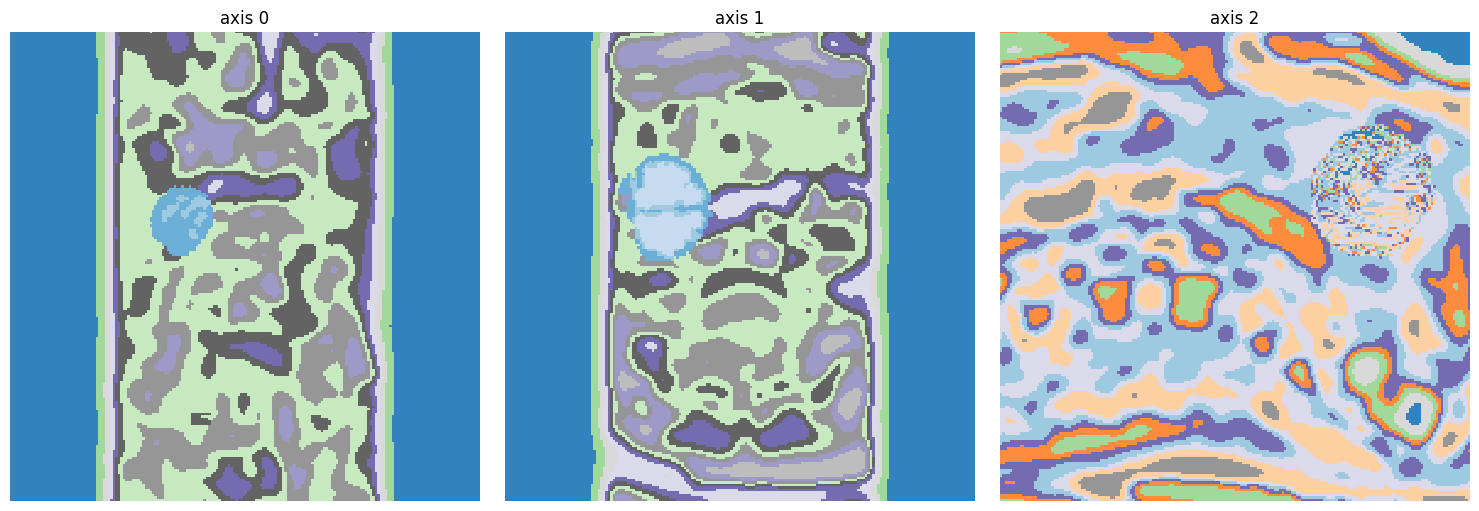

In [2]:
def create_model(model_config):
    # print(model_config)
    return ne.models.labels_to_image_new(**model_config)
    
import json

with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

model1_config = config["brain"]
model2_config = config["body"]
model_shapes_config = config["shapes"]
model_feta_config = config["feta"]

model3_config = config["labels_to_image_model"]
model4_config = config["labels_to_image_model_with_shapes_24"]
model_feta_config["labels_out"] = {int(key): value for key, value in model_feta_config["labels_out"].items()}

# Convert labels_out keys to integers for all models
model1_config["labels_out"] = {int(key): value for key, value in model1_config["labels_out"].items()}
model2_config["labels_out"] = {int(key): value for key, value in model2_config["labels_out"].items()}
model_shapes_config["labels_out"] = {int(key): value for key, value in model_shapes_config["labels_out"].items()}

model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

model4_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
# Brain
model1 = create_model(model1_config)
# Body
model2 = create_model(model2_config)
#Feta
model_feta = create_model(model_feta_config)

#shapes
model_shapes = create_model(model_shapes_config)

# Model
labels_to_image_model = create_model(model3_config)

labels_to_image_model_with_shapes = create_model(model4_config)


in_shape = model3_config["in_shape"]
num_gen = 25
output_labels = []
num_shapes=2
brain_maps = feta_label_maps#get_brain(label_maps)

shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
shapes = map(np.squeeze, shapes)
shapes = map(np.uint8, shapes)
shapes = [f + 7 + 1 for f in shapes]

fov_maps = get_fov(label_maps)
# print(fov_maps)
shapes = np.concatenate((shapes, fov_maps), axis=0)
# _, y_brain = model_feta(brain_maps)

gen = generator(brain_maps, shapes)

for i in range(num_gen):


    # brain_maps = feta_label_maps#get_brain(label_maps)
    # shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
    # shapes = map(np.squeeze, shapes)
    # shapes = map(np.uint8, shapes)
    # shapes = [f for f in shapes]
    # gen = generator_shapes(shapes)

    output_label = next(gen)
    output_labels.append(output_label)
    nib.save(nib.Nifti1Image(np.squeeze(output_label, axis=(0, -1)).astype(np.int32), np.eye(4), header=None), f"samples/feta_shapes_label_map_{i}.nii.gz")
    ne.plot.volume3D(np.squeeze(output_label, axis=(0, -1)), cmaps=['tab20c'])


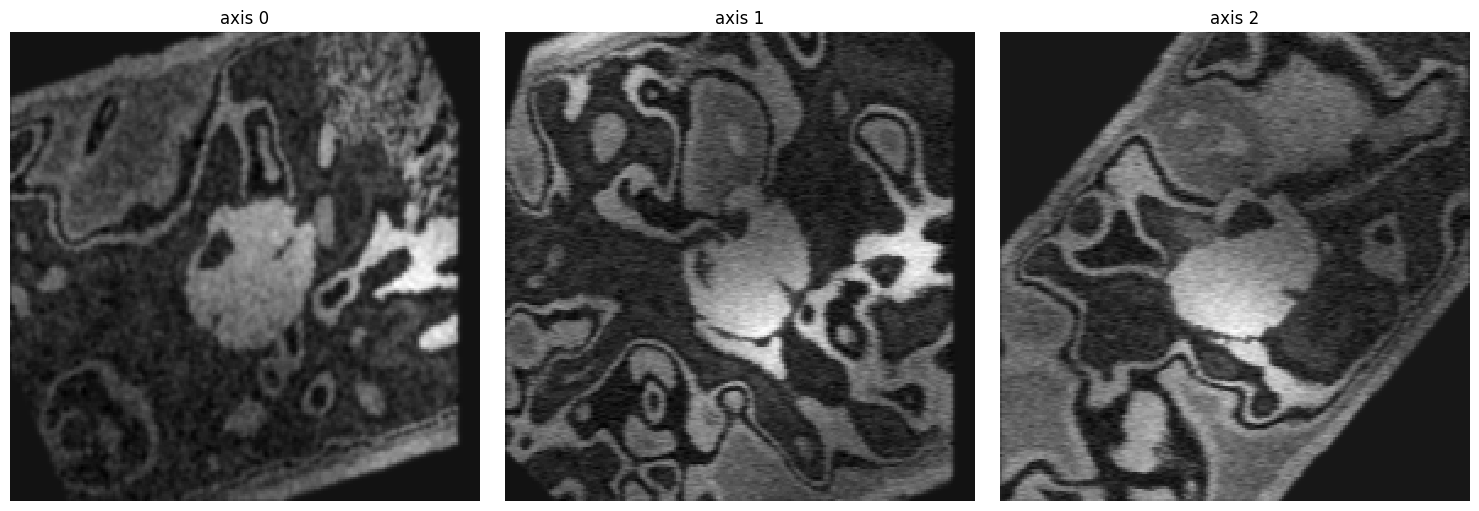

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([11 11 19], shape=(3,), dtype=int64) tf.Tensor([179 184 178], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.08096119, shape=(), dtype=float32)
(192, 192, 192)


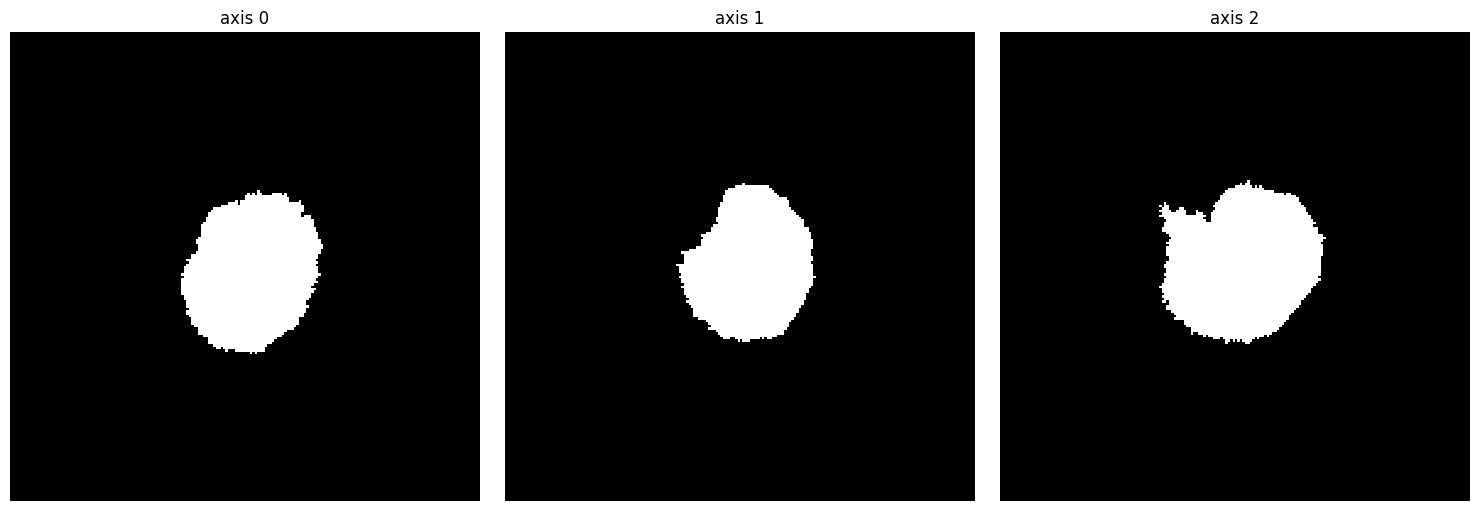

shape after box (1, 192, 192, 192, 2)


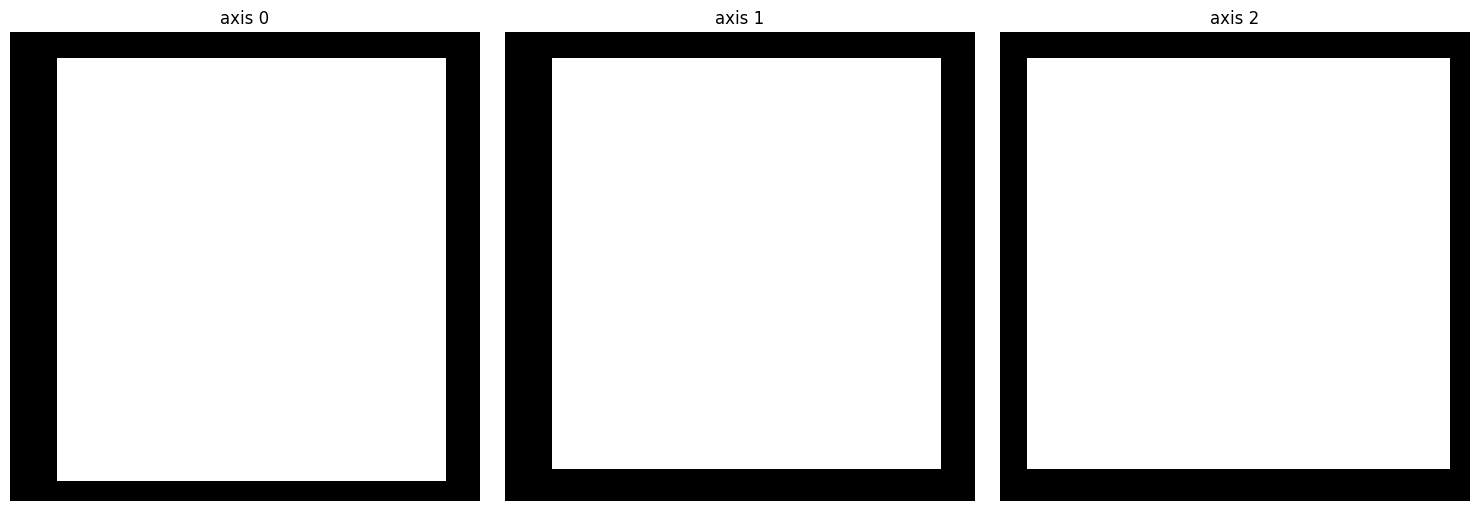

validation_synth/image_0
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


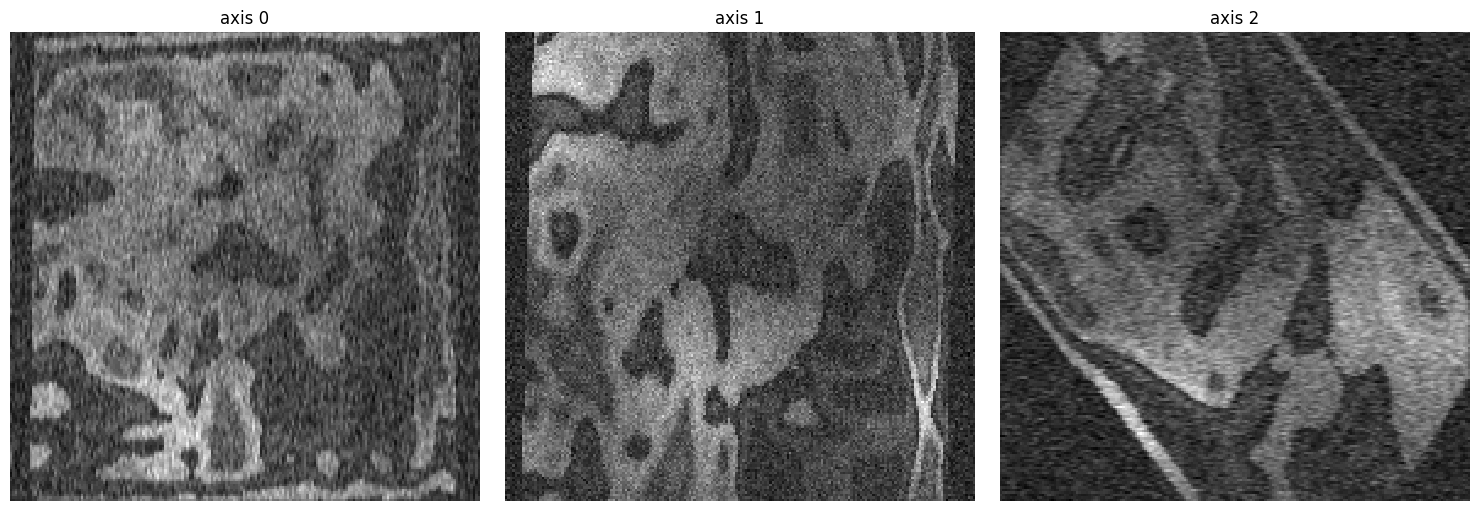

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 0 42  3], shape=(3,), dtype=int64) tf.Tensor([170 191 150], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.053098388, shape=(), dtype=float32)
(192, 192, 192)


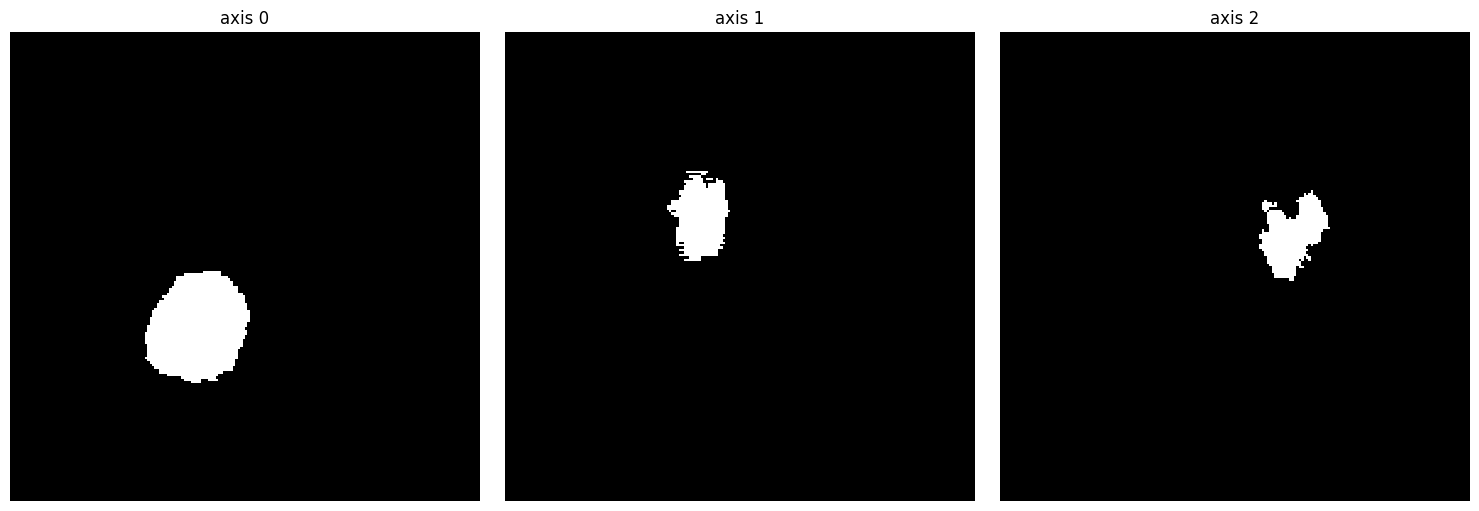

shape after box (1, 192, 192, 192, 2)


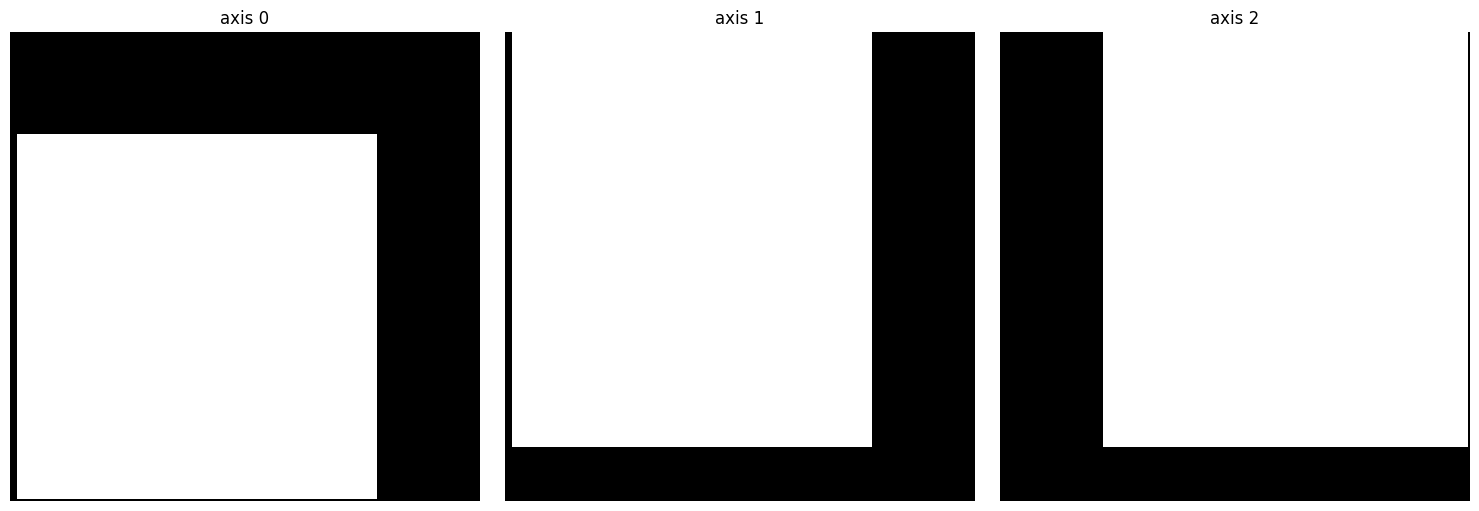

validation_synth/image_1
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


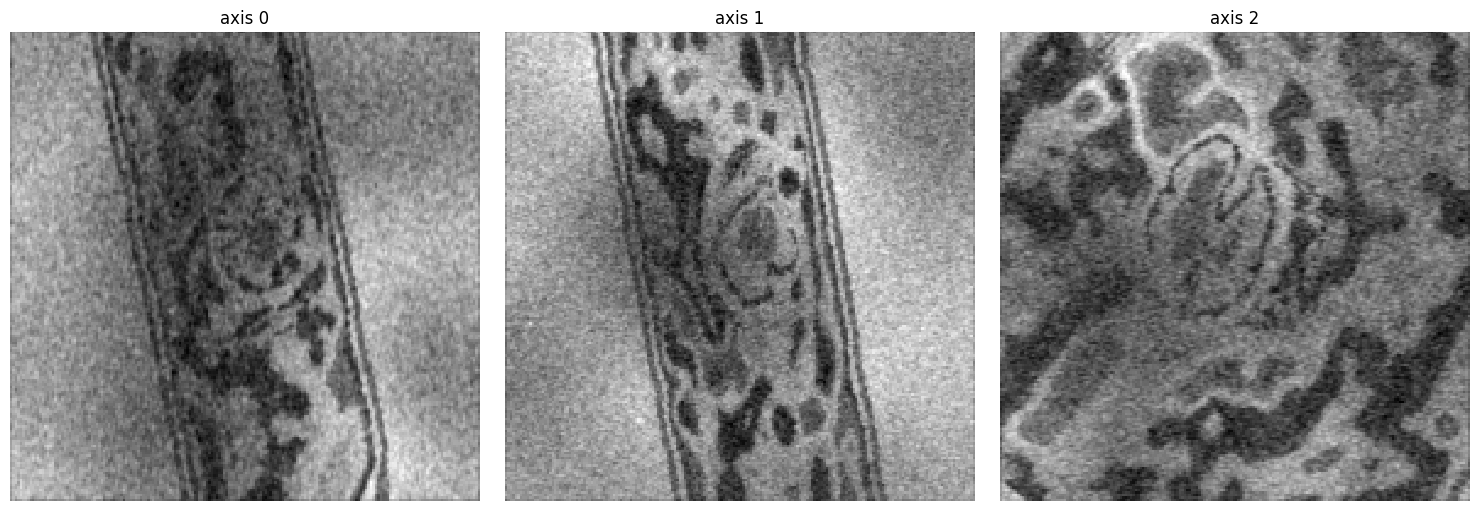

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 0  2 28], shape=(3,), dtype=int64) tf.Tensor([174 172 175], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.071450934, shape=(), dtype=float32)
(192, 192, 192)


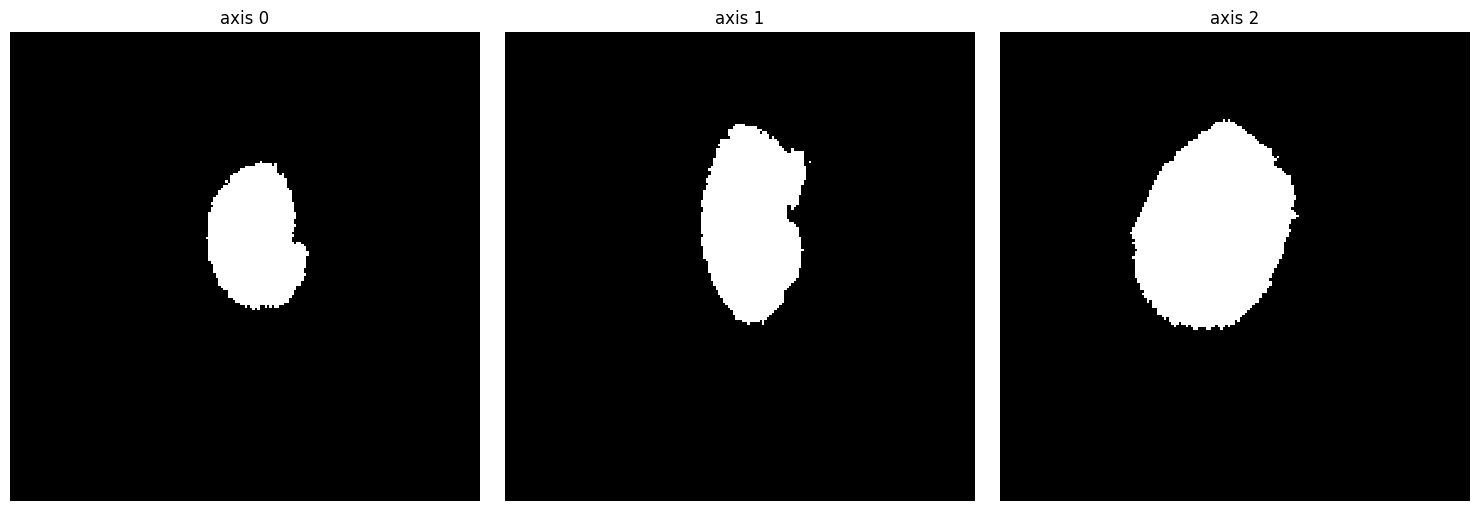

shape after box (1, 192, 192, 192, 2)


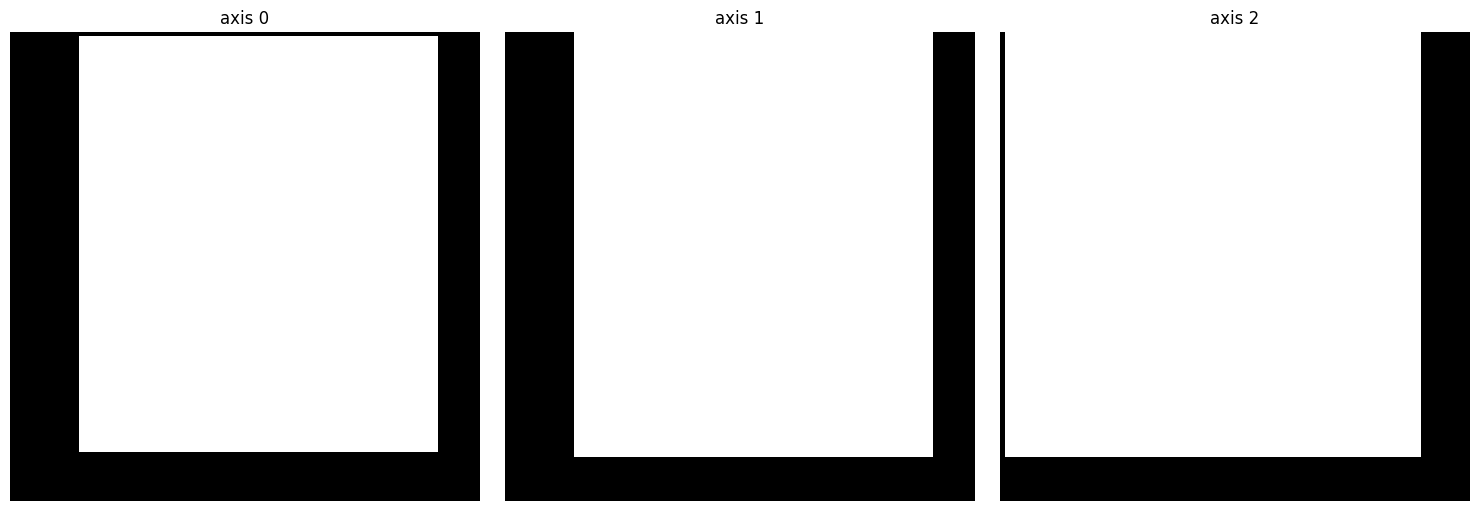

validation_synth/image_2
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


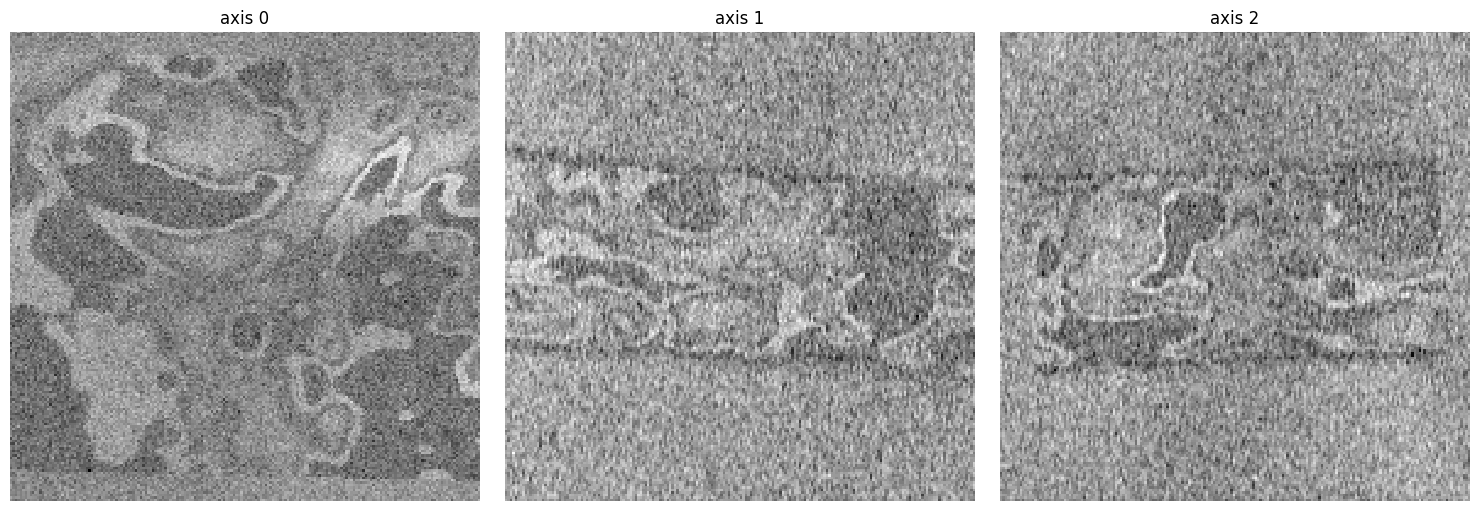

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 0 42  0], shape=(3,), dtype=int64) tf.Tensor([142 191 133], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.03042987, shape=(), dtype=float32)
(192, 192, 192)


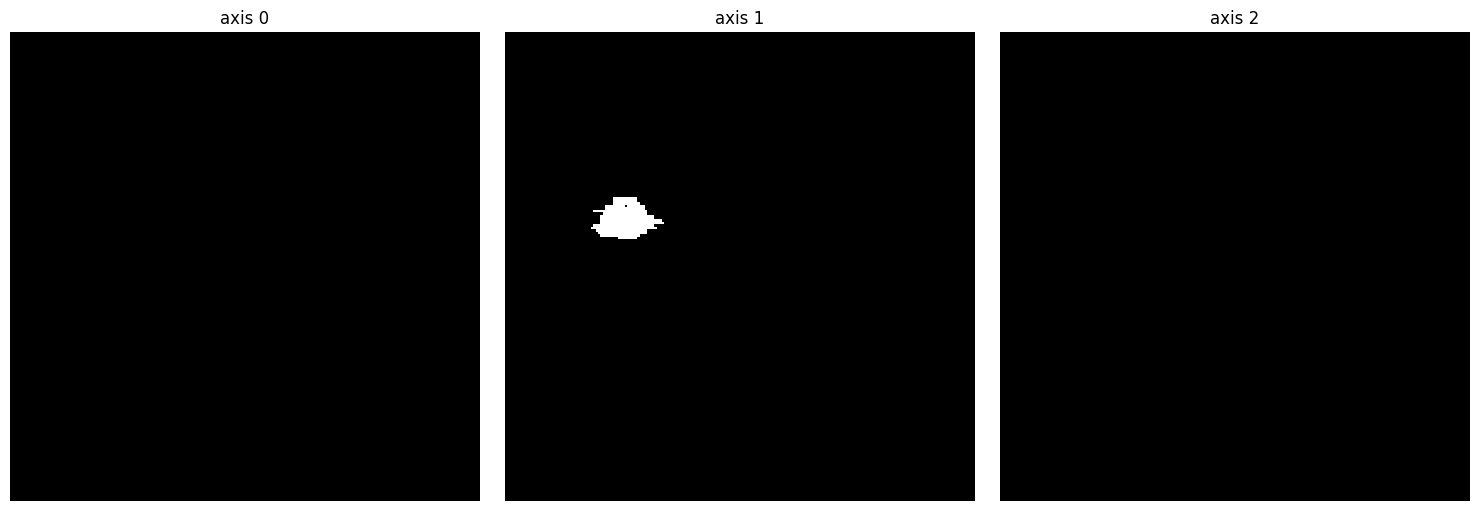

shape after box (1, 192, 192, 192, 2)


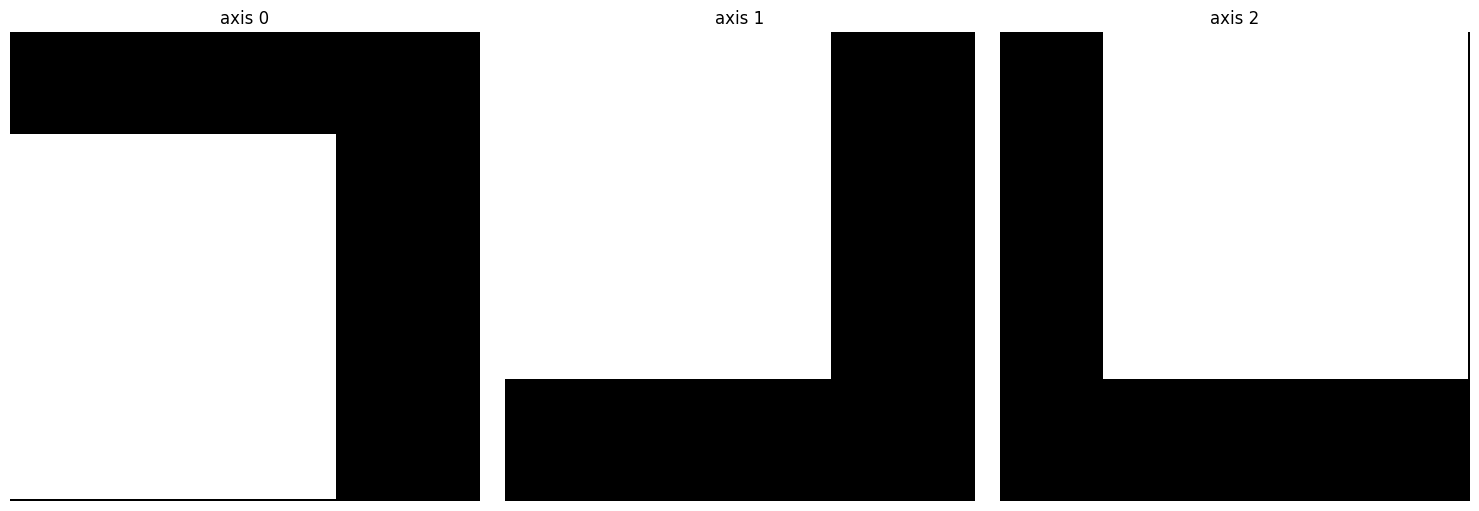

validation_synth/image_3
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


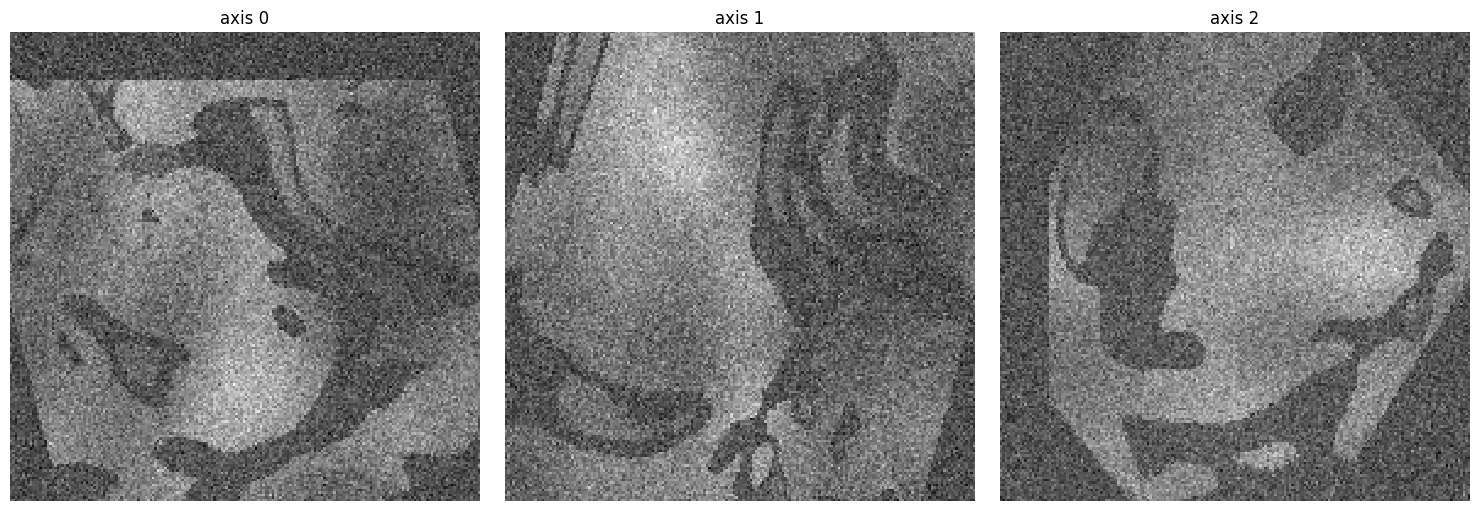

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([14  0  0], shape=(3,), dtype=int64) tf.Tensor([176 142 132], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.035414185, shape=(), dtype=float32)
(192, 192, 192)


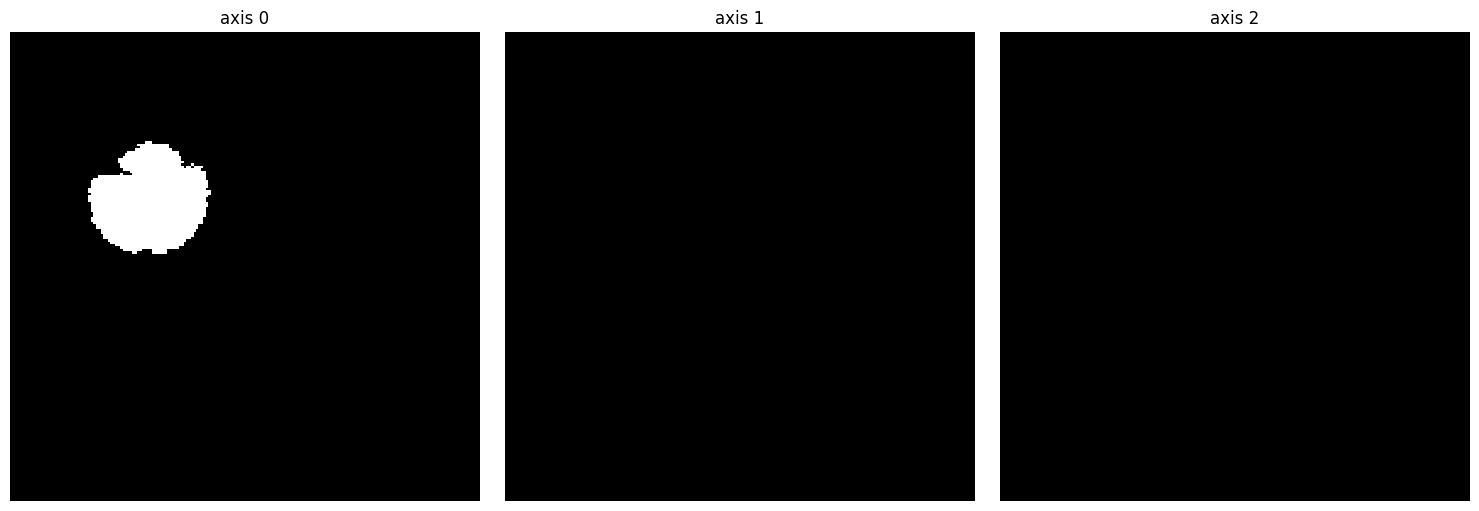

shape after box (1, 192, 192, 192, 2)


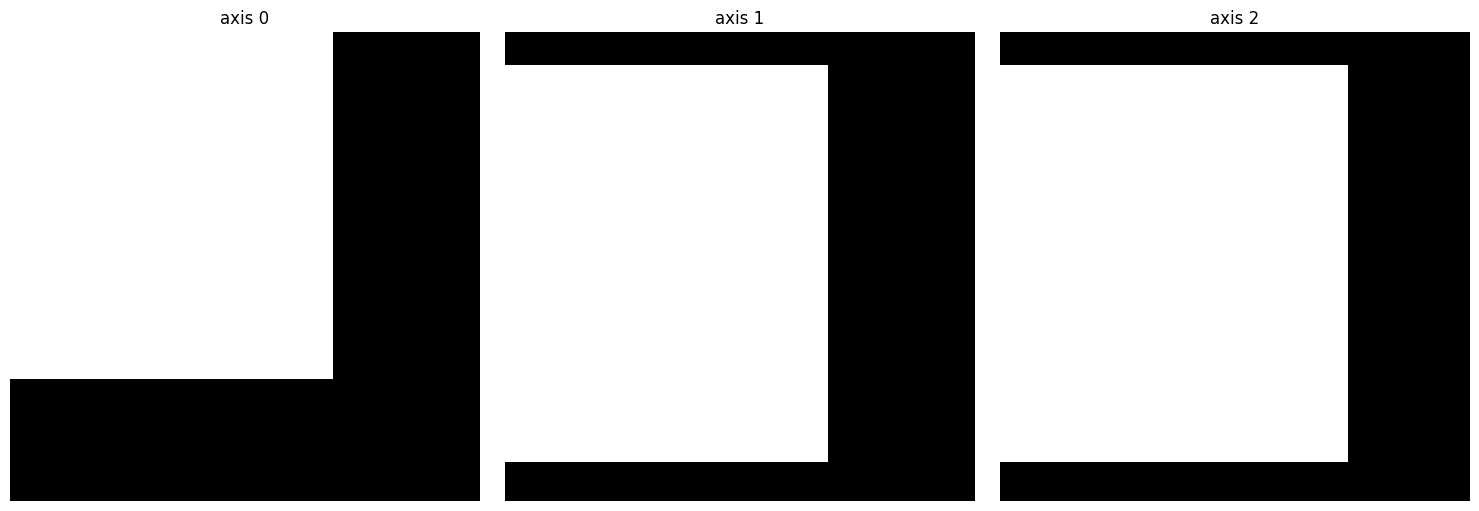

validation_synth/image_4
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


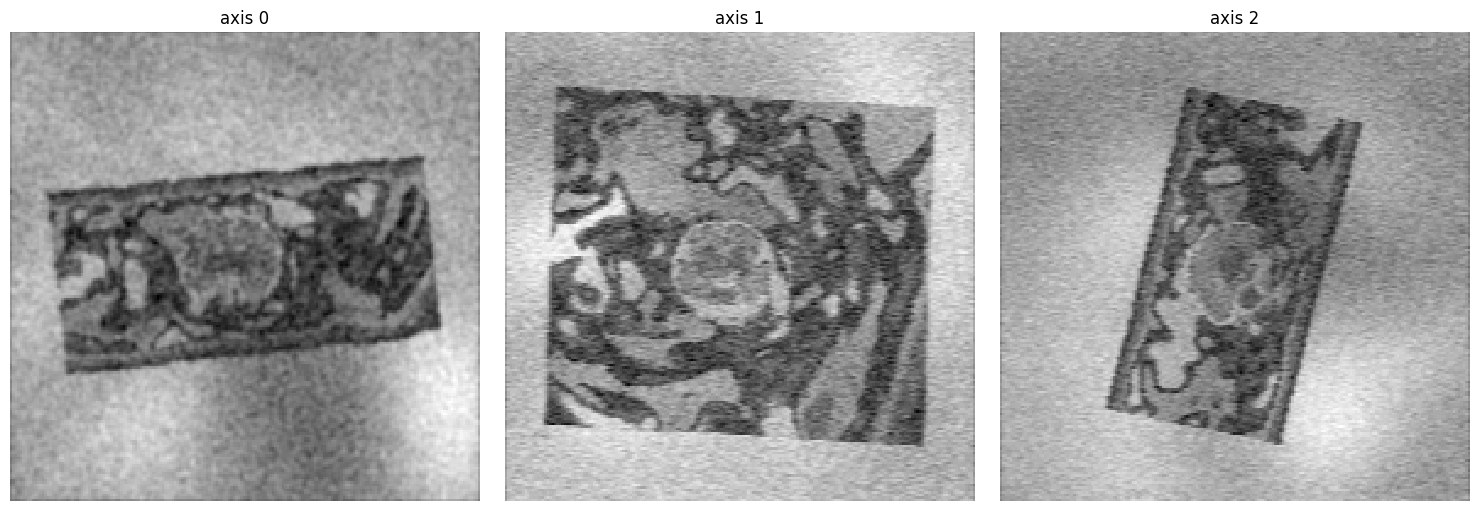

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([27 23 18], shape=(3,), dtype=int64) tf.Tensor([171 161 162], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.031873506, shape=(), dtype=float32)
(192, 192, 192)


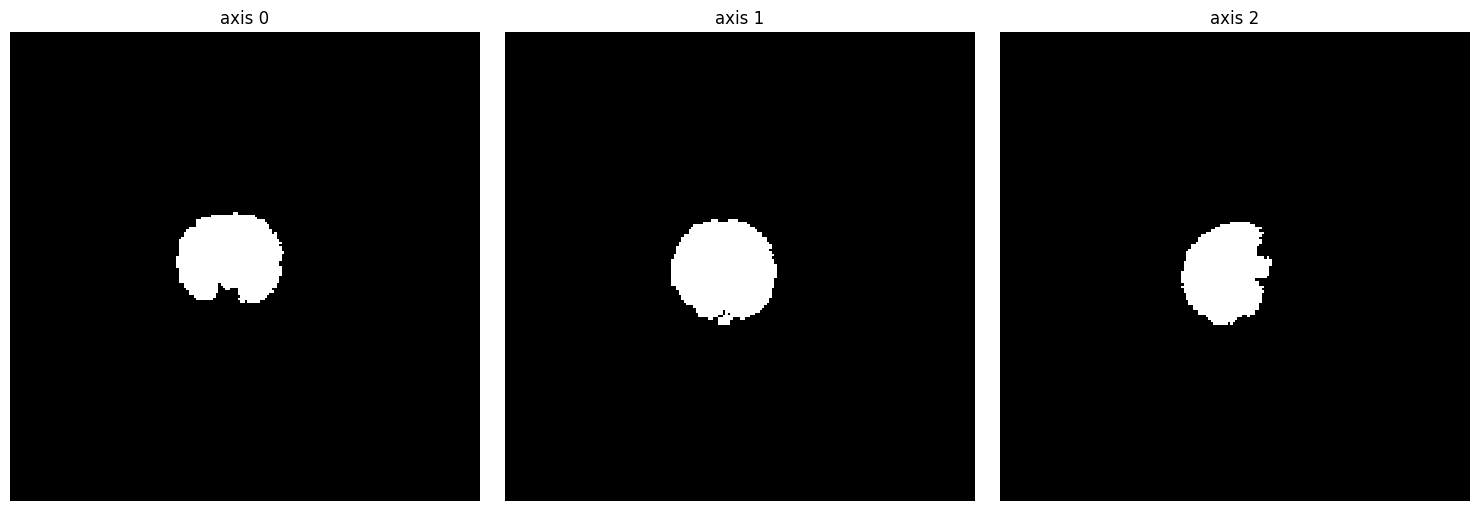

shape after box (1, 192, 192, 192, 2)


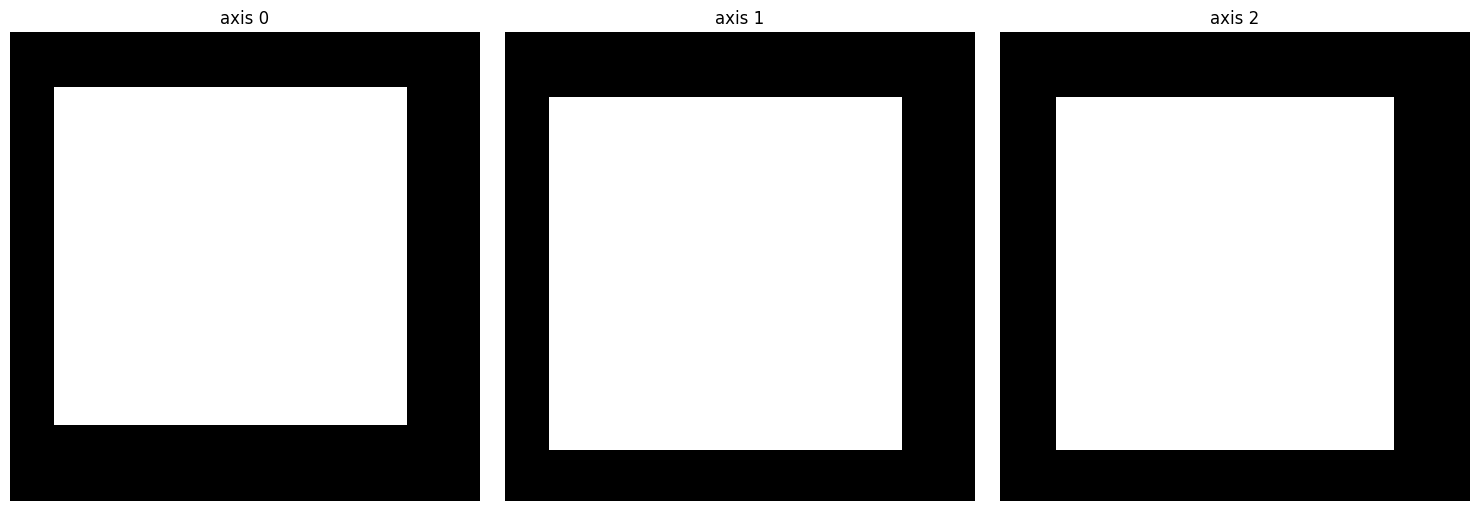

validation_synth/image_5
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


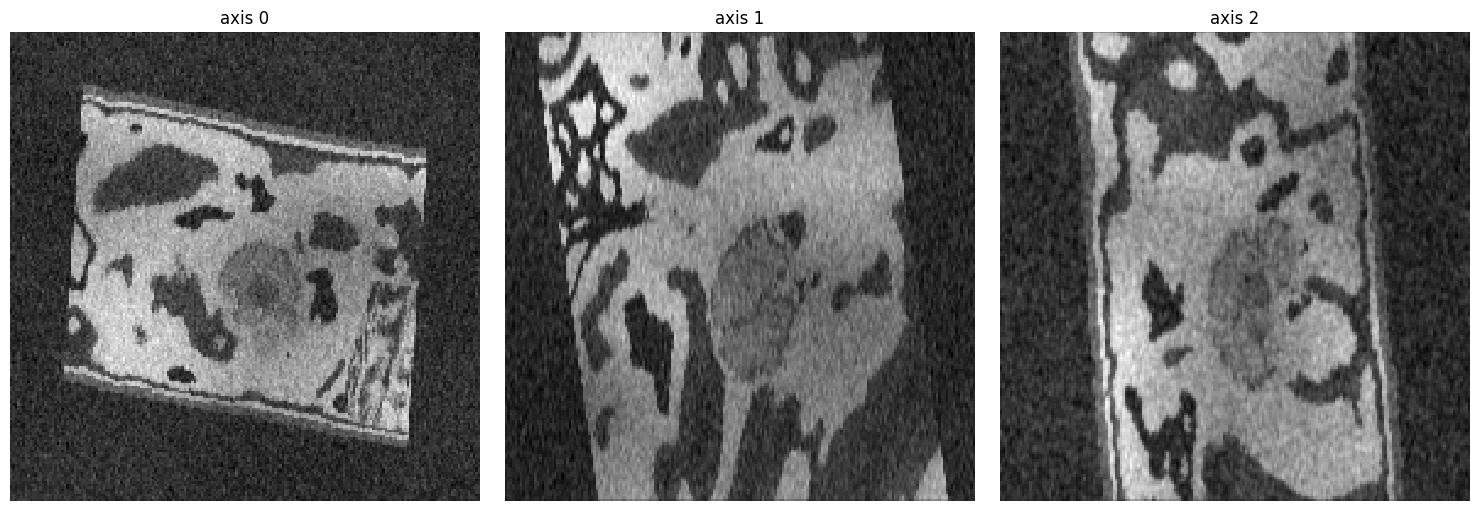

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([17 32 30], shape=(3,), dtype=int64) tf.Tensor([191 191 176], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.06220604, shape=(), dtype=float32)
(192, 192, 192)


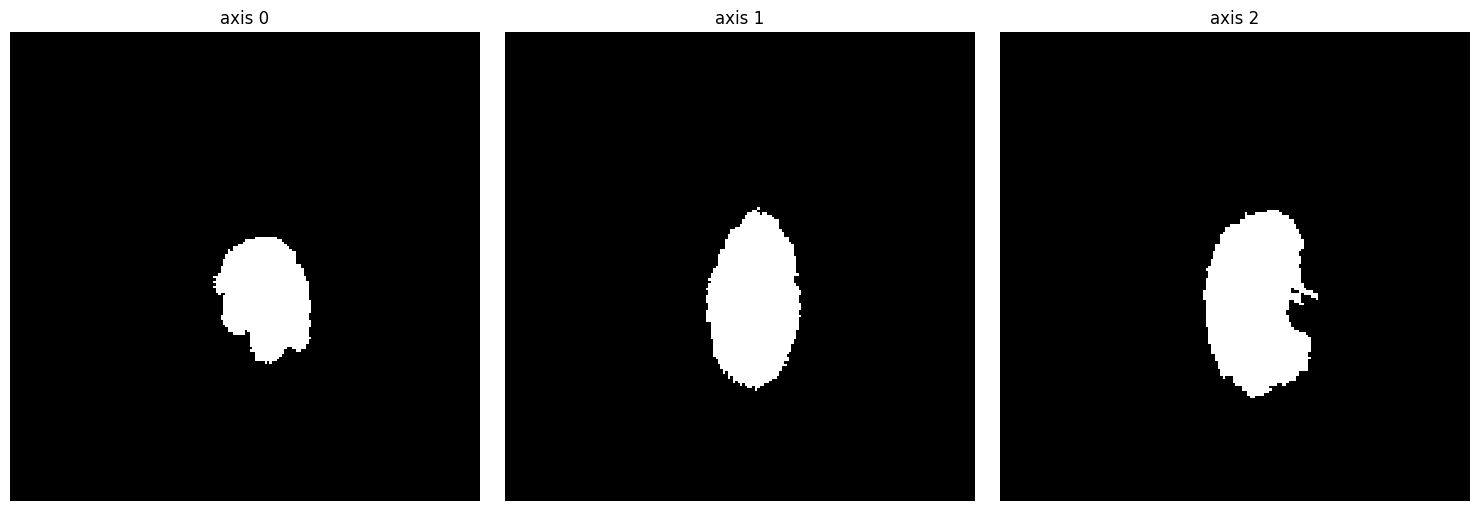

shape after box (1, 192, 192, 192, 2)


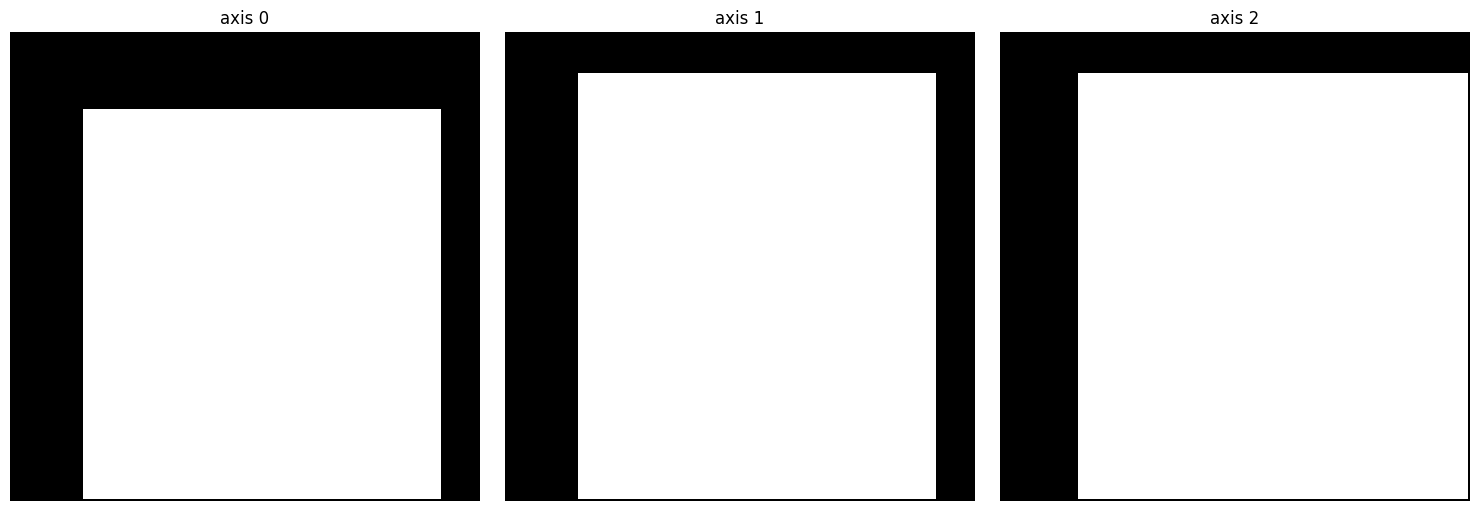

validation_synth/image_6
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


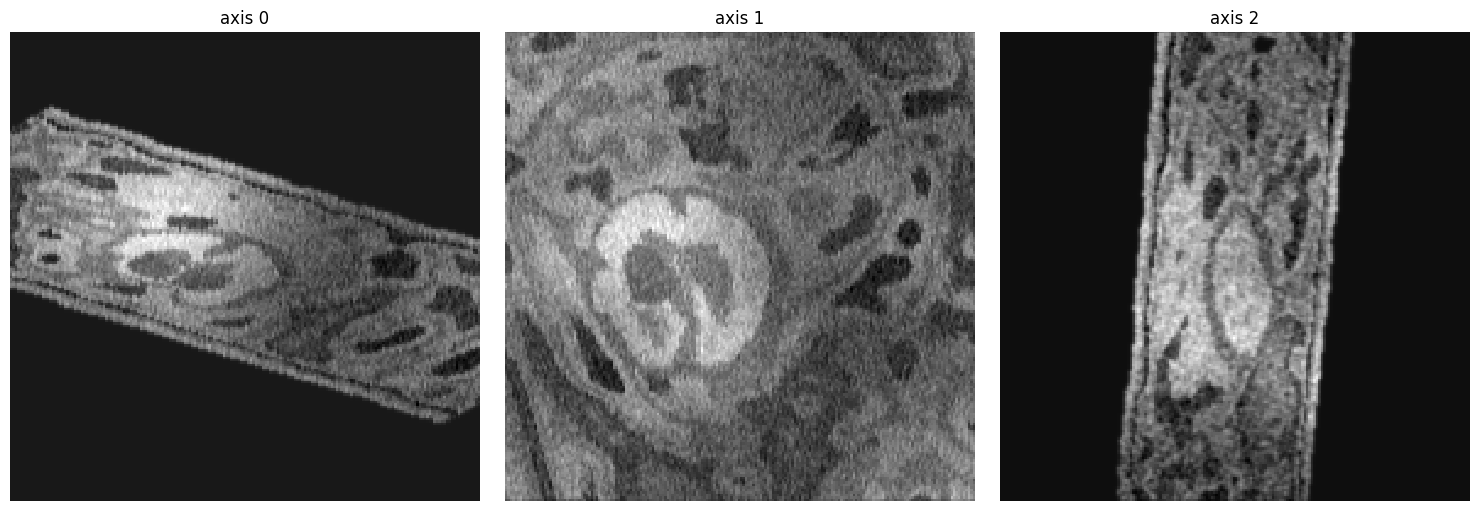

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([13 30  0], shape=(3,), dtype=int64) tf.Tensor([191 165 169], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.062140368, shape=(), dtype=float32)
(192, 192, 192)


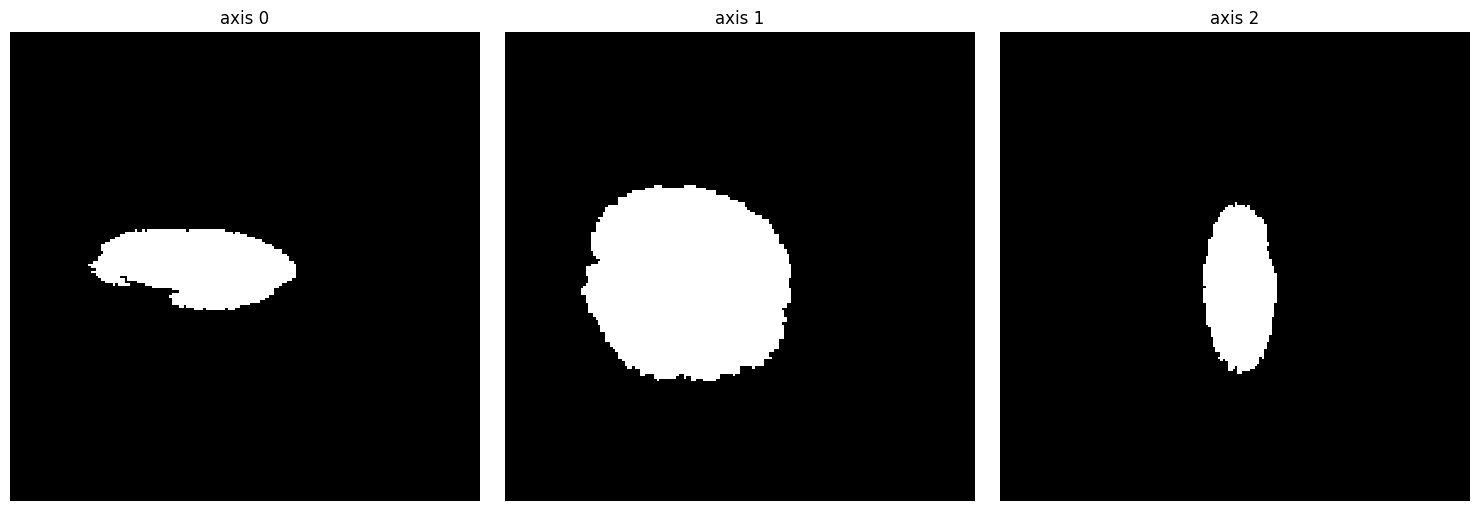

shape after box (1, 192, 192, 192, 2)


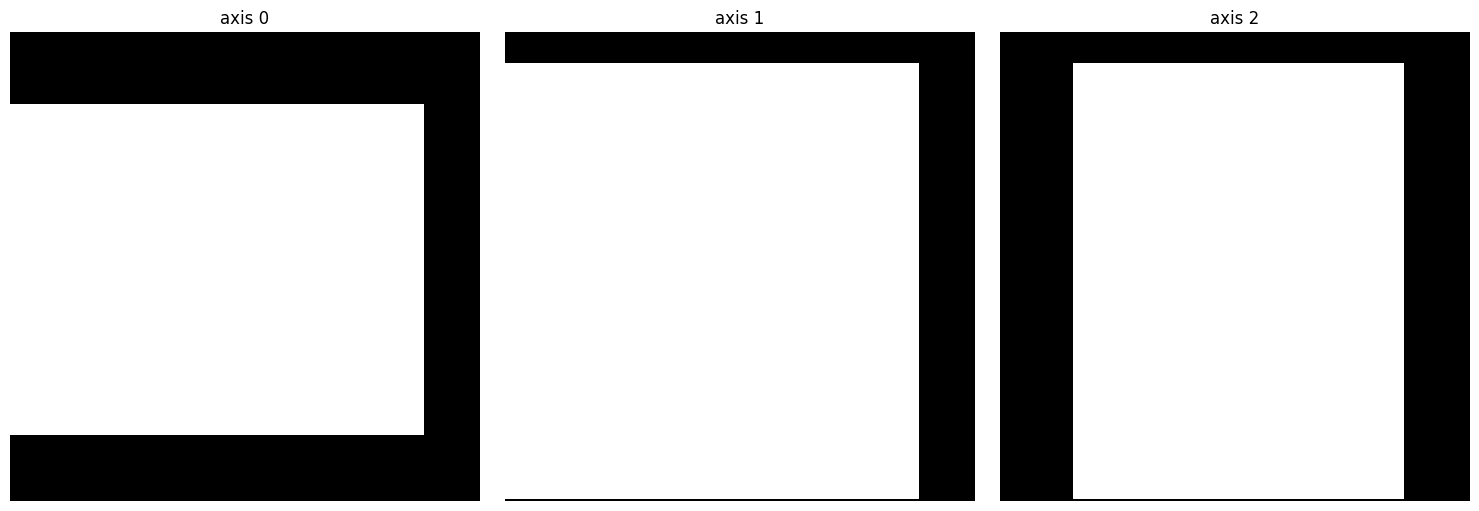

validation_synth/image_7
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


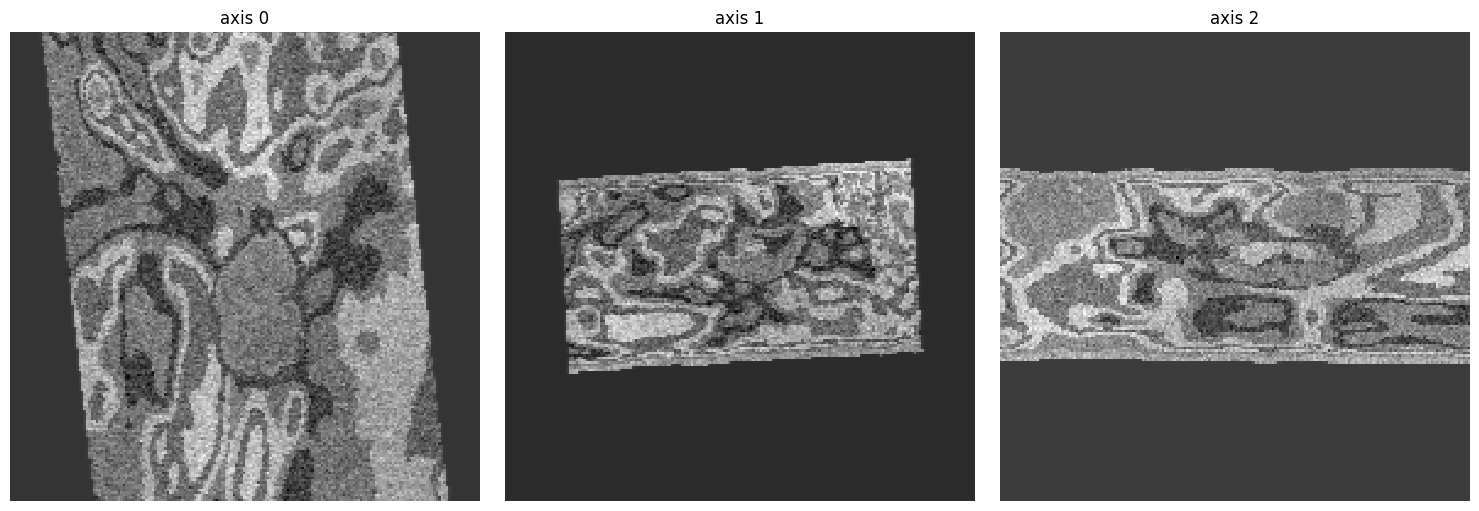

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([20 26 29], shape=(3,), dtype=int64) tf.Tensor([156 191 177], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.04269462, shape=(), dtype=float32)
(192, 192, 192)


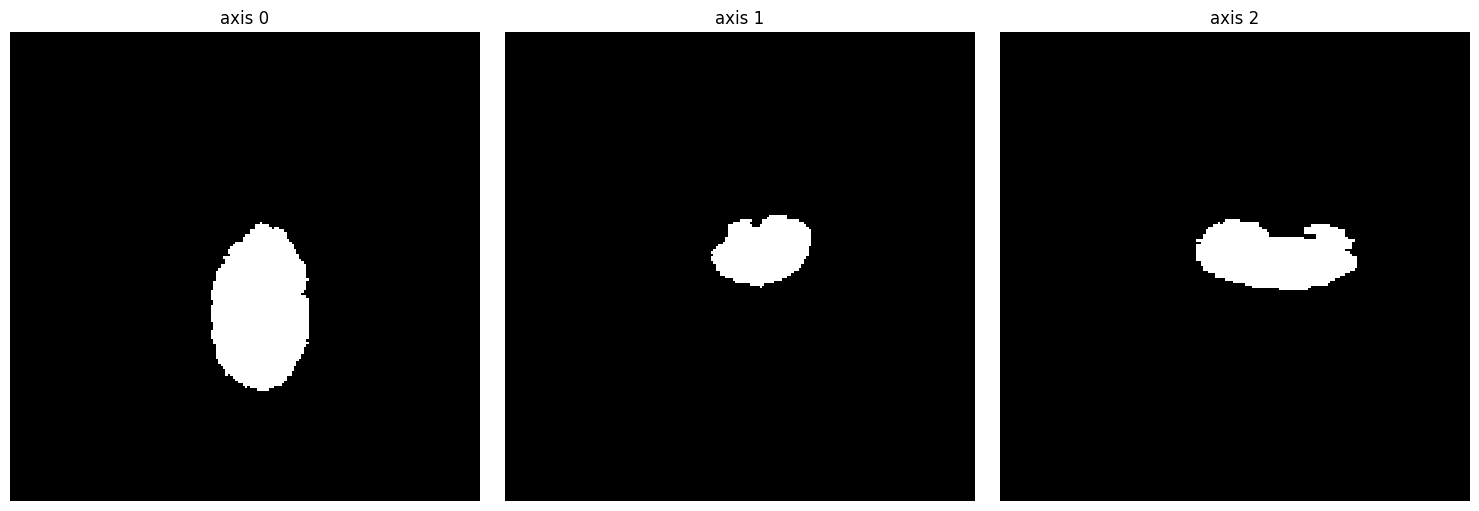

shape after box (1, 192, 192, 192, 2)


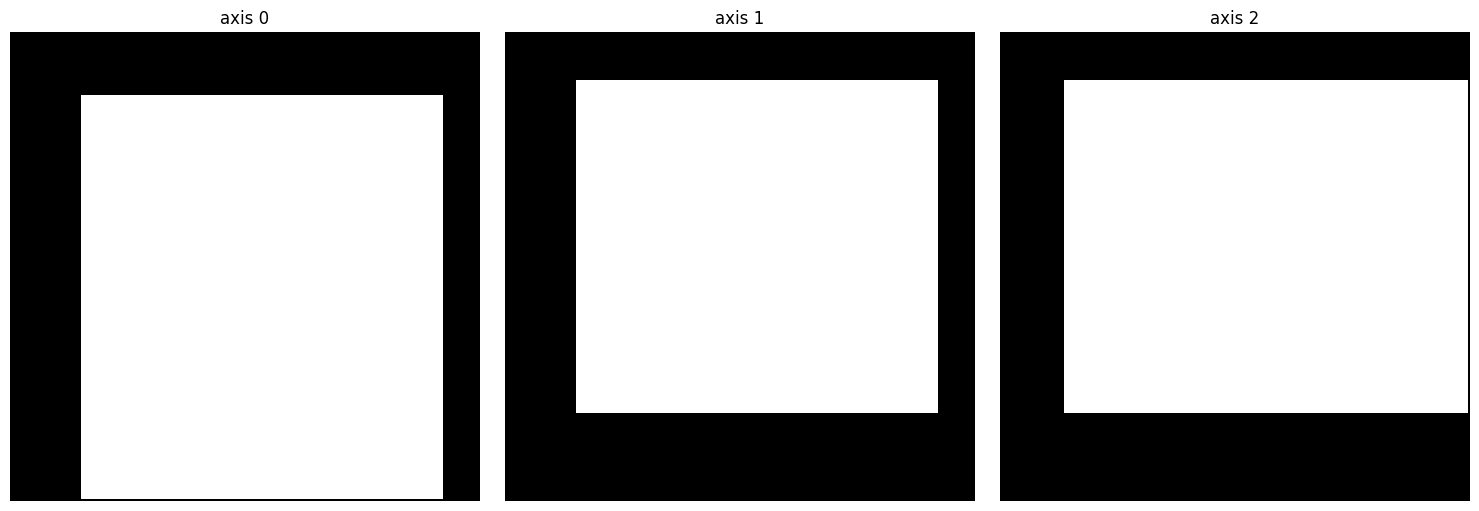

validation_synth/image_8
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


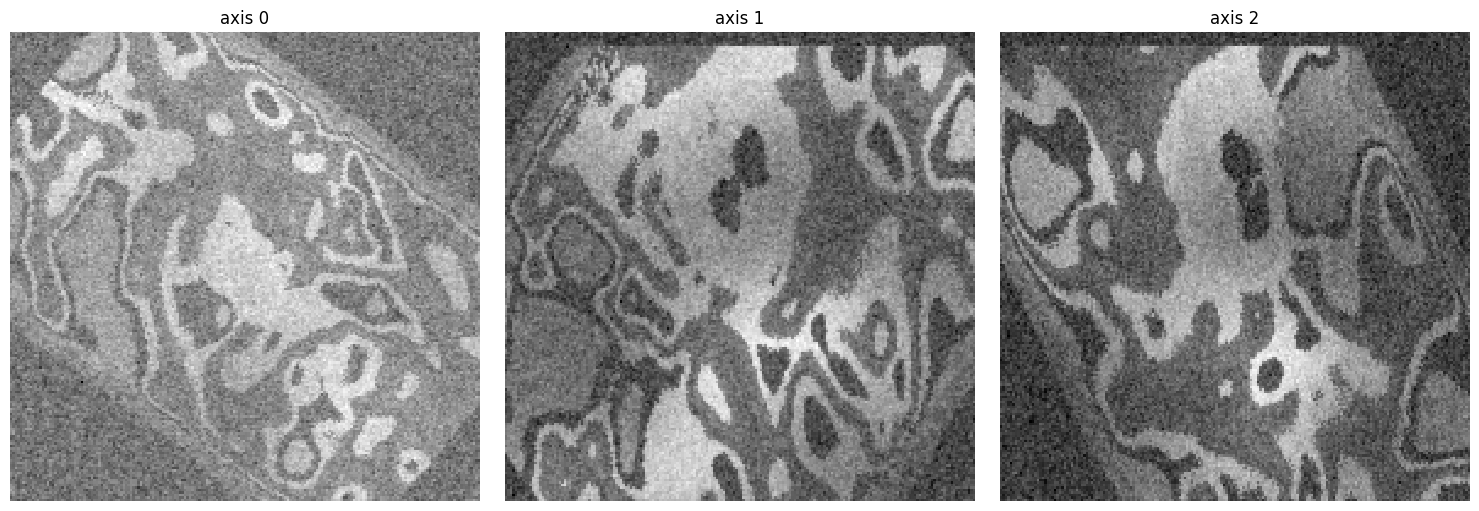

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 0 14 12], shape=(3,), dtype=int64) tf.Tensor([158 177 173], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.06314027, shape=(), dtype=float32)
(192, 192, 192)


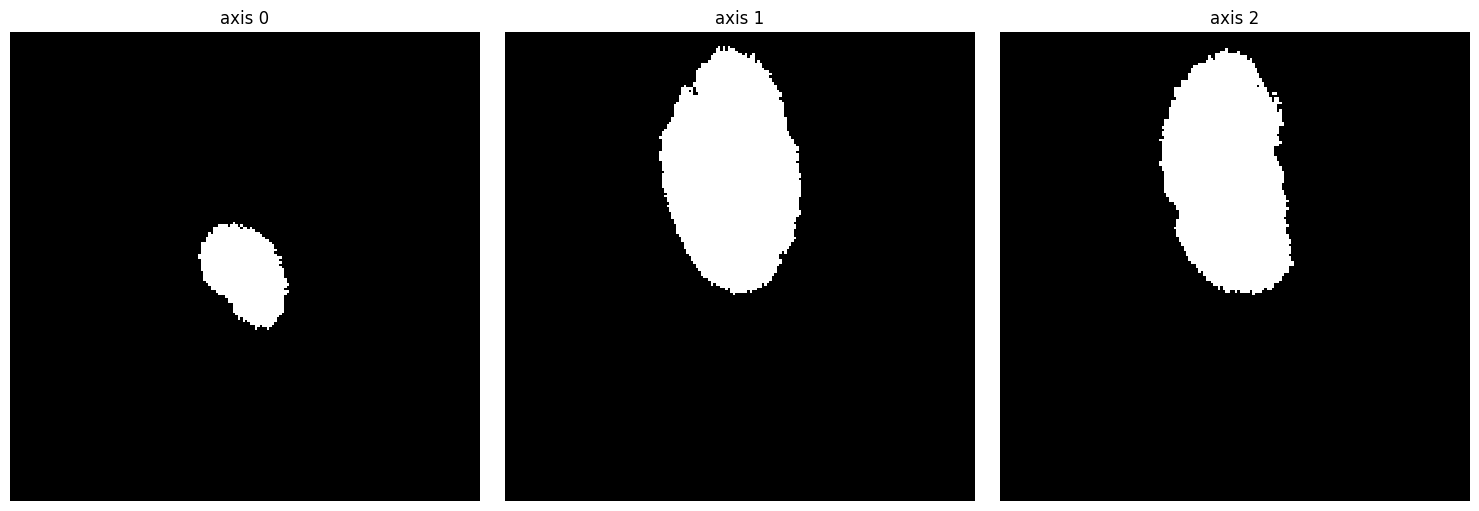

shape after box (1, 192, 192, 192, 2)


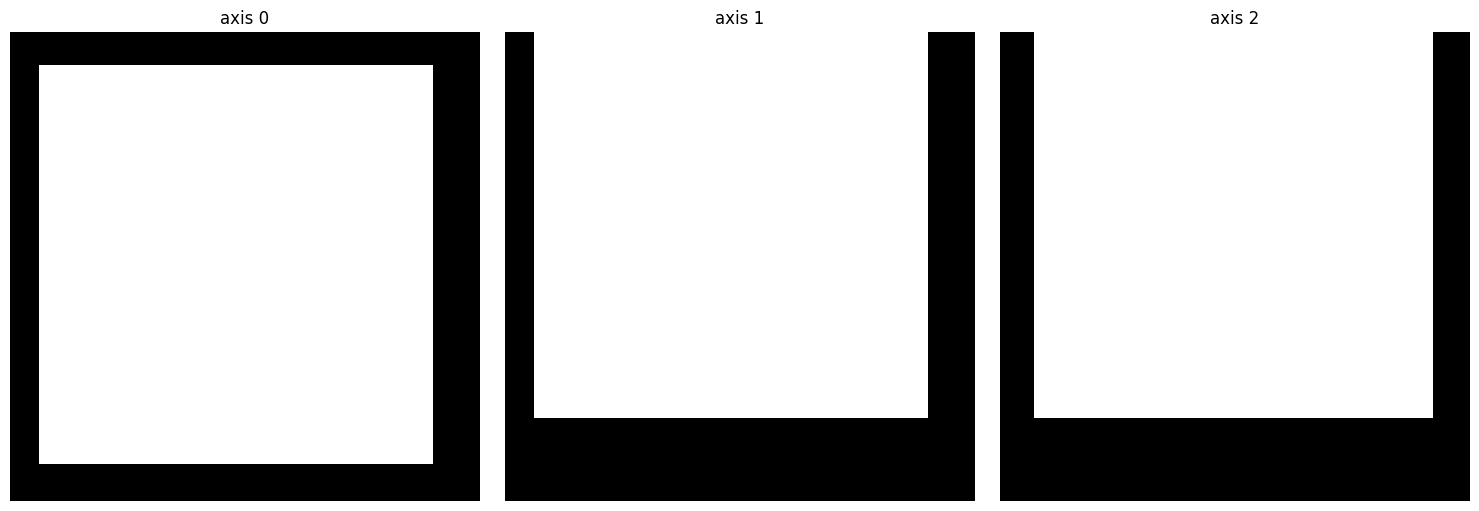

validation_synth/image_9
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


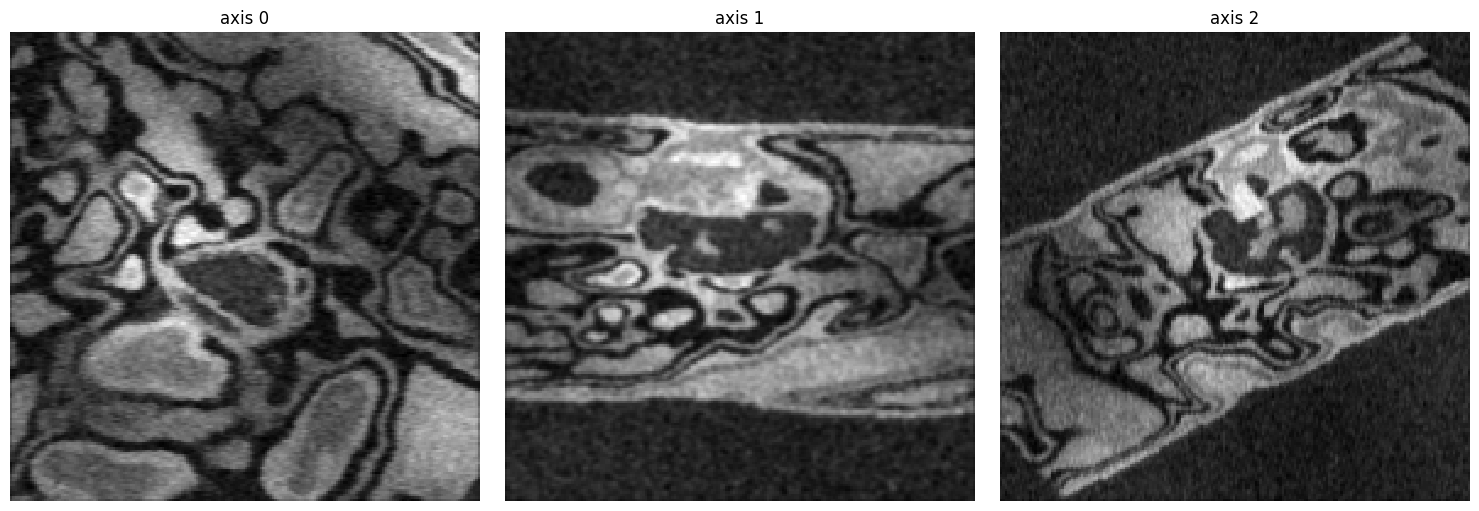

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 2 27  0], shape=(3,), dtype=int64) tf.Tensor([154 190 187], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.08161905, shape=(), dtype=float32)
(192, 192, 192)


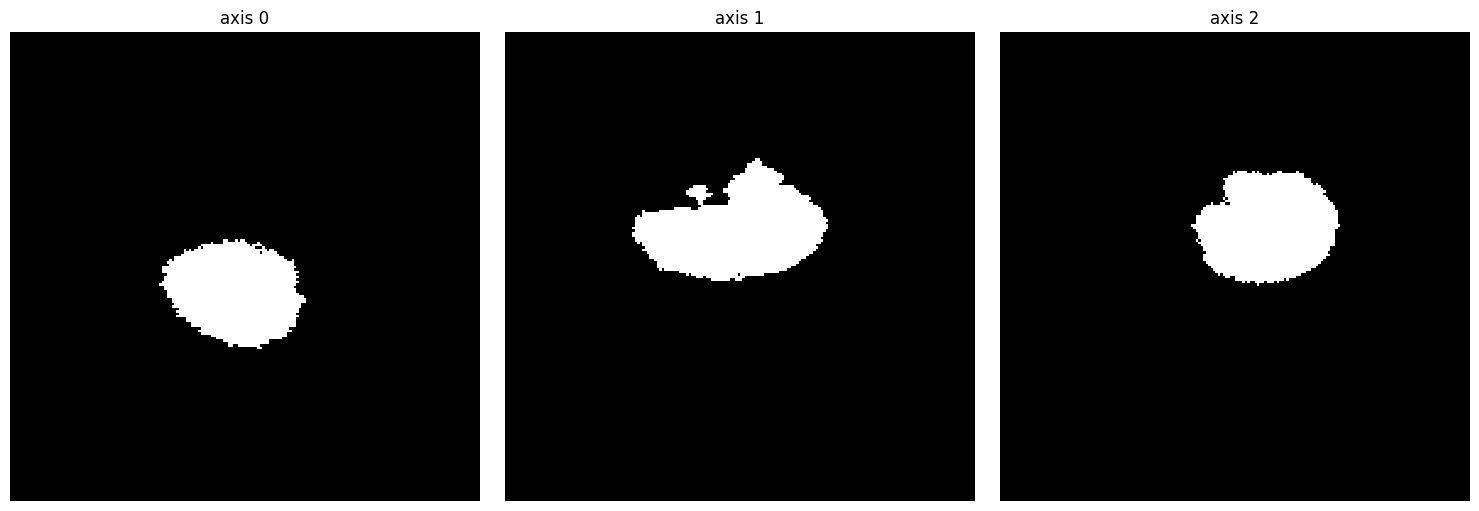

shape after box (1, 192, 192, 192, 2)


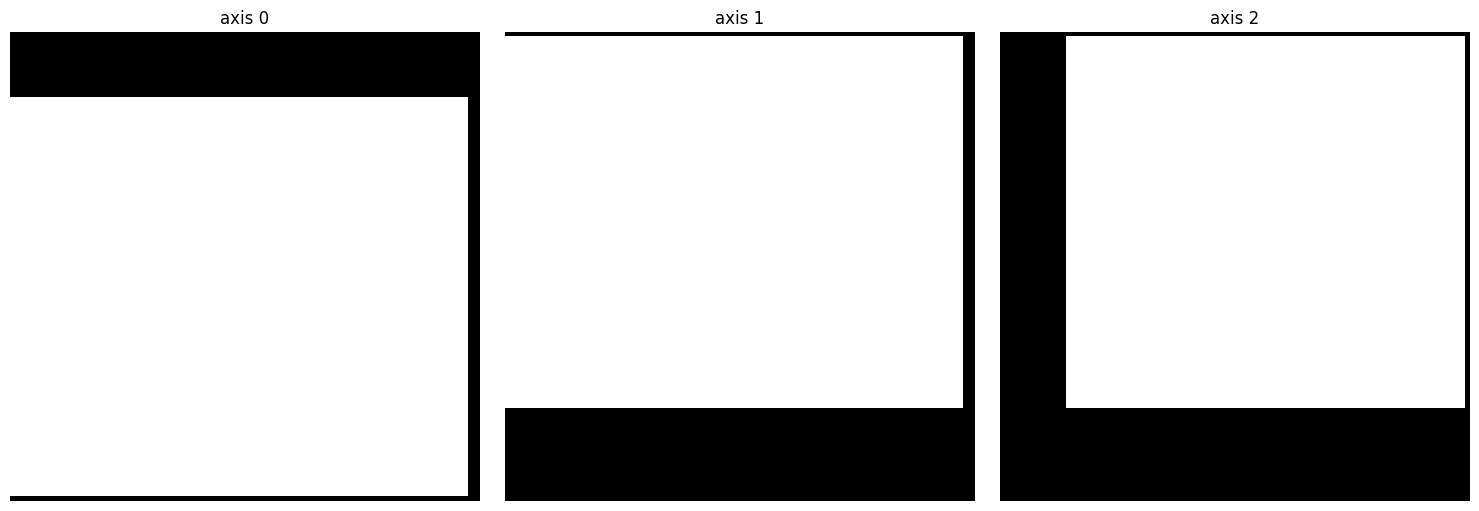

validation_synth/image_10
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


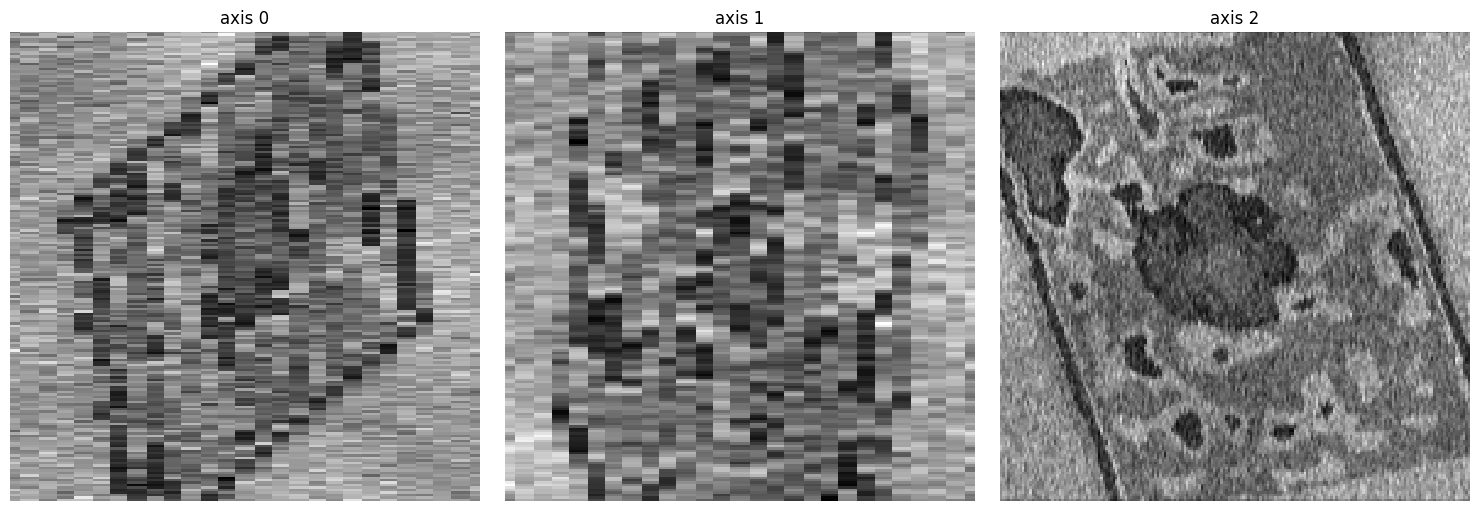

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([11  3 30], shape=(3,), dtype=int64) tf.Tensor([174 172 170], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.057181973, shape=(), dtype=float32)
(192, 192, 192)


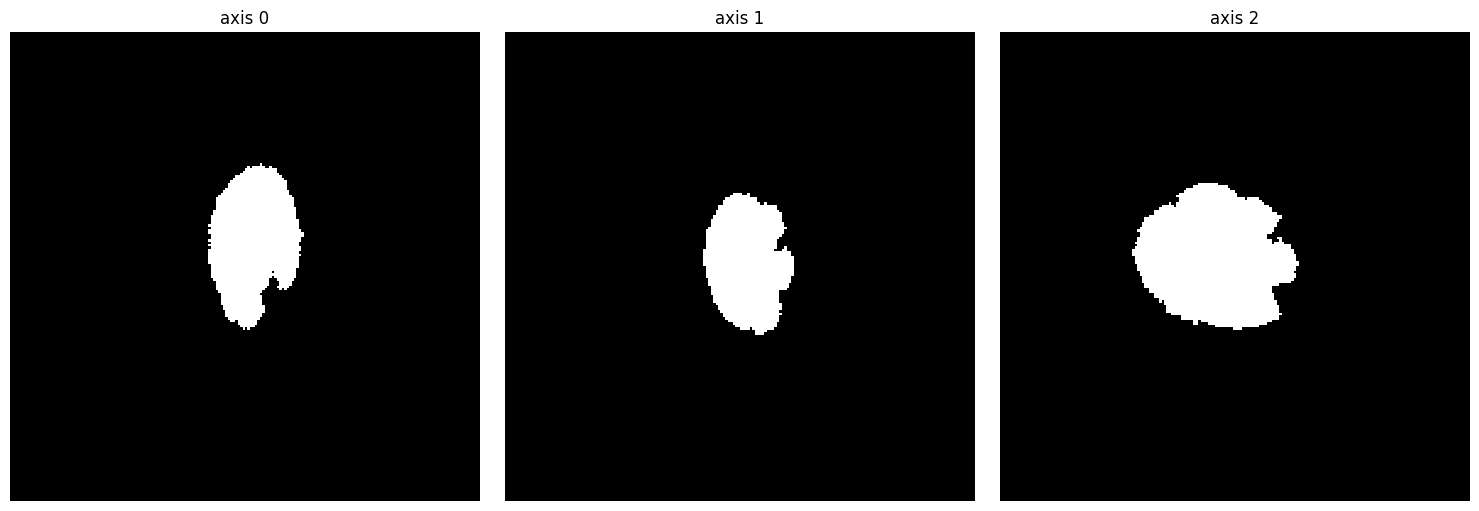

shape after box (1, 192, 192, 192, 2)


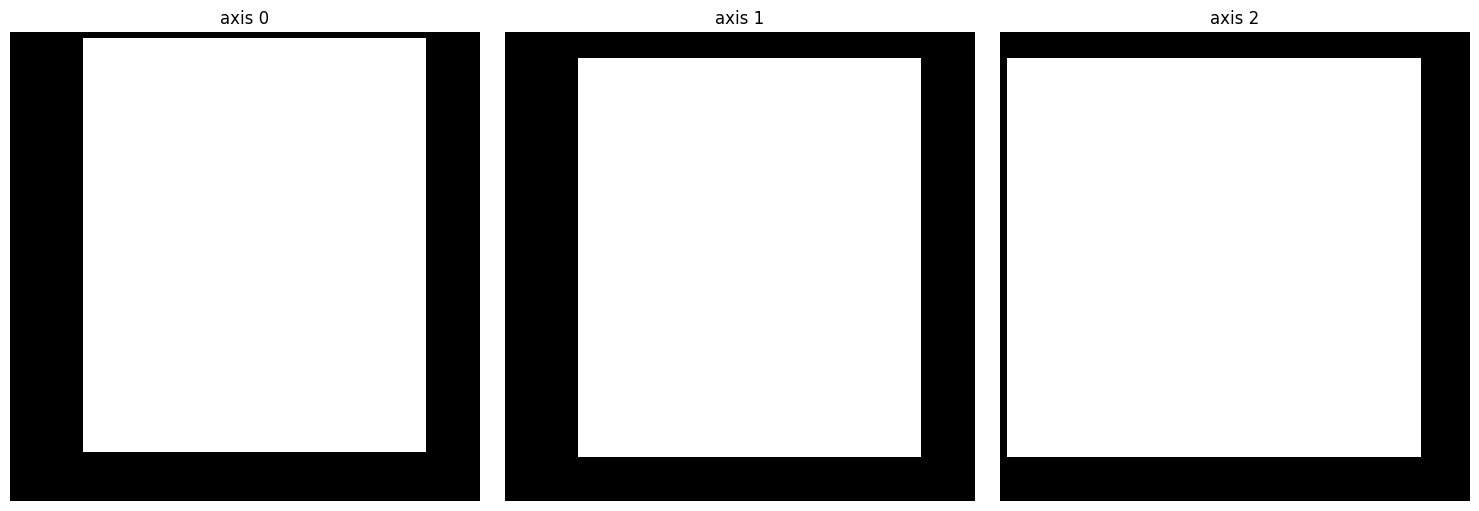

validation_synth/image_11
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


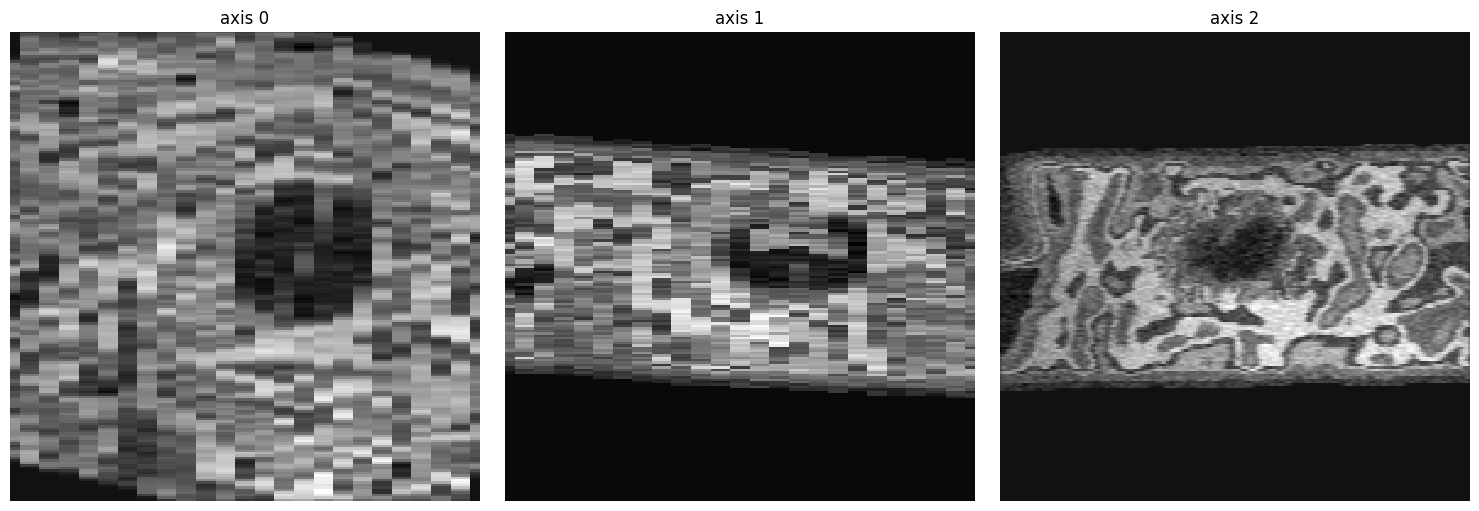

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([21  9 35], shape=(3,), dtype=int64) tf.Tensor([162 176 191], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.05137413, shape=(), dtype=float32)
(192, 192, 192)


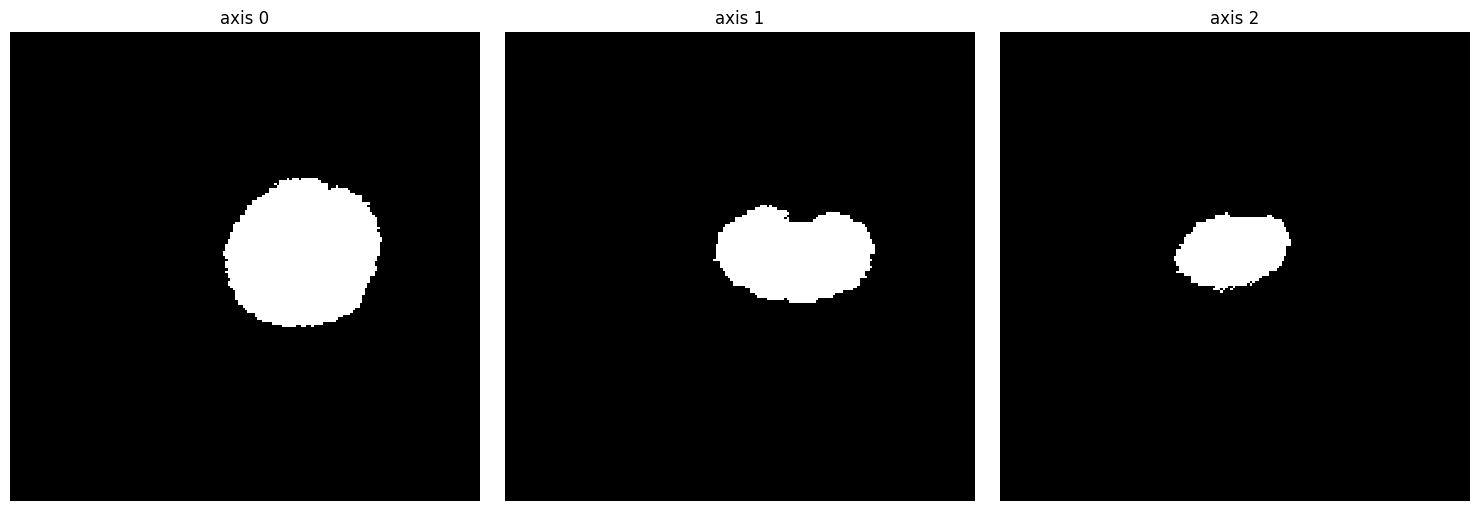

shape after box (1, 192, 192, 192, 2)


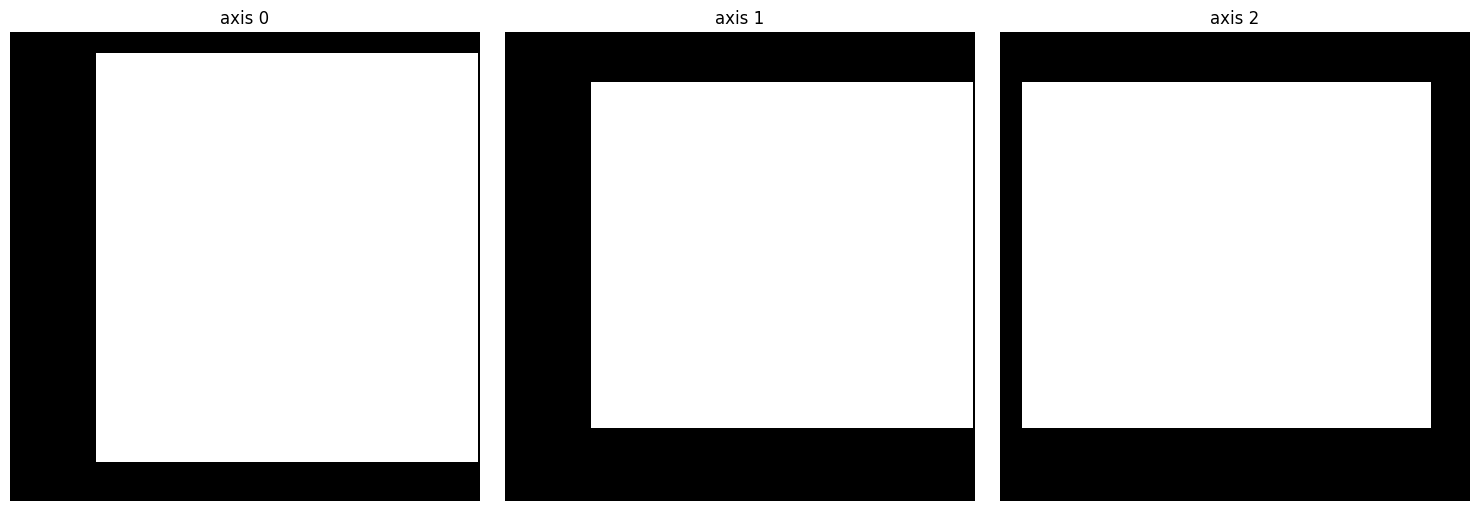

validation_synth/image_12
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


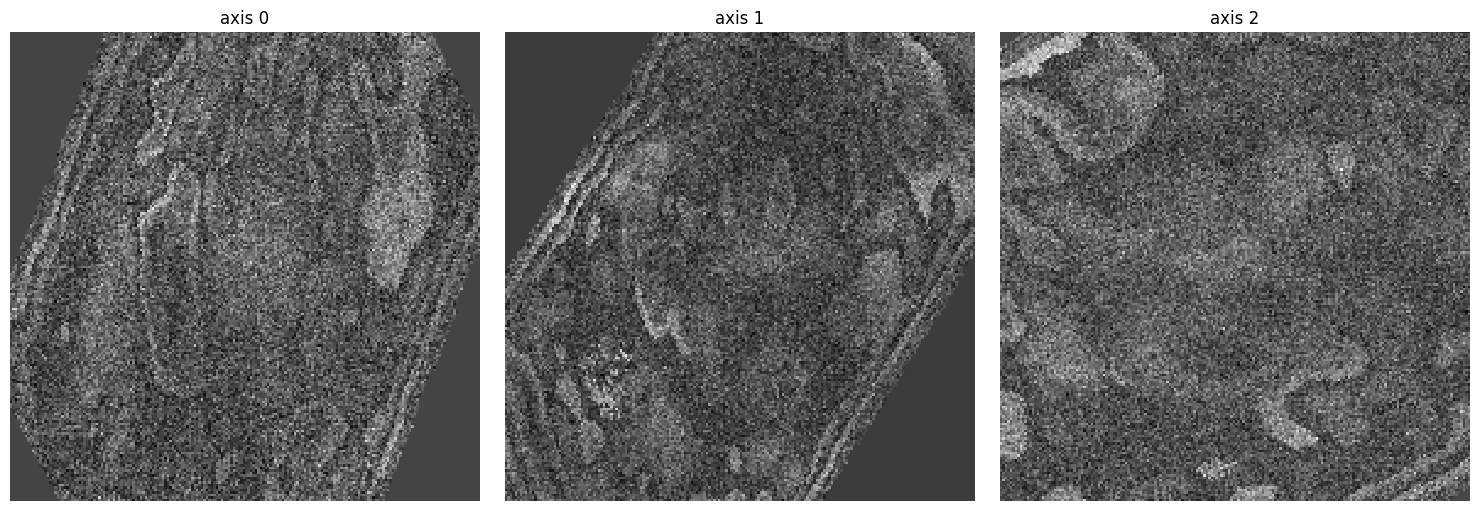

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([24  0 24], shape=(3,), dtype=int64) tf.Tensor([191 191 178], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.08790994, shape=(), dtype=float32)
(192, 192, 192)


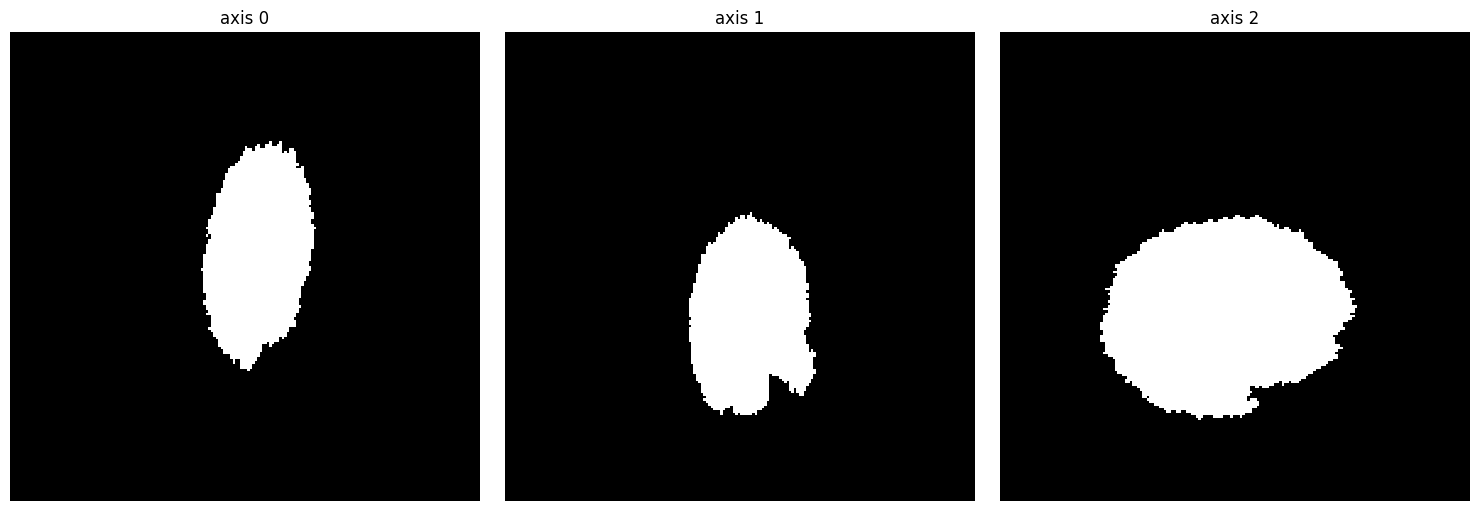

shape after box (1, 192, 192, 192, 2)


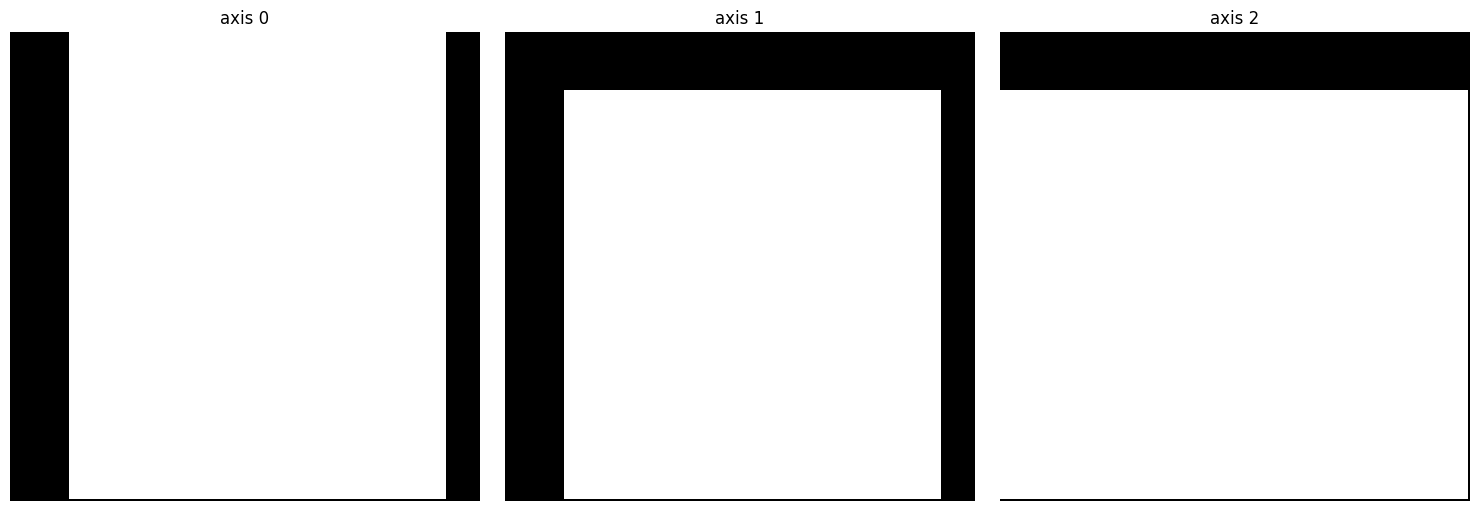

validation_synth/image_13
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


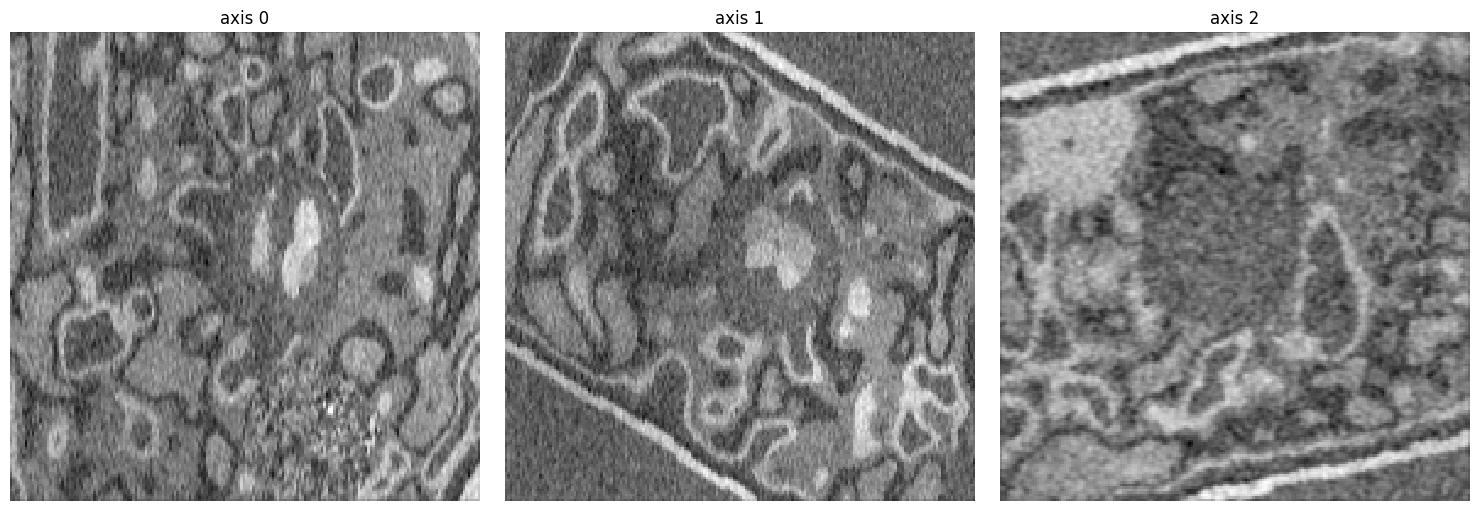

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 6  3 31], shape=(3,), dtype=int64) tf.Tensor([176 180 188], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.08382514, shape=(), dtype=float32)
(192, 192, 192)


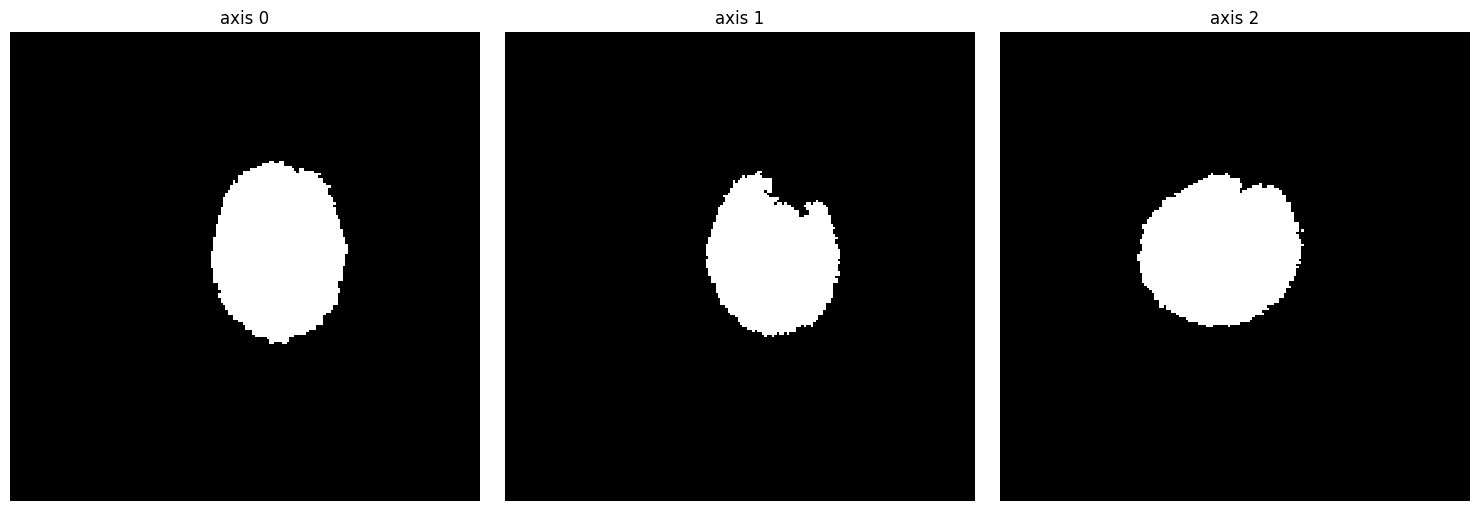

shape after box (1, 192, 192, 192, 2)


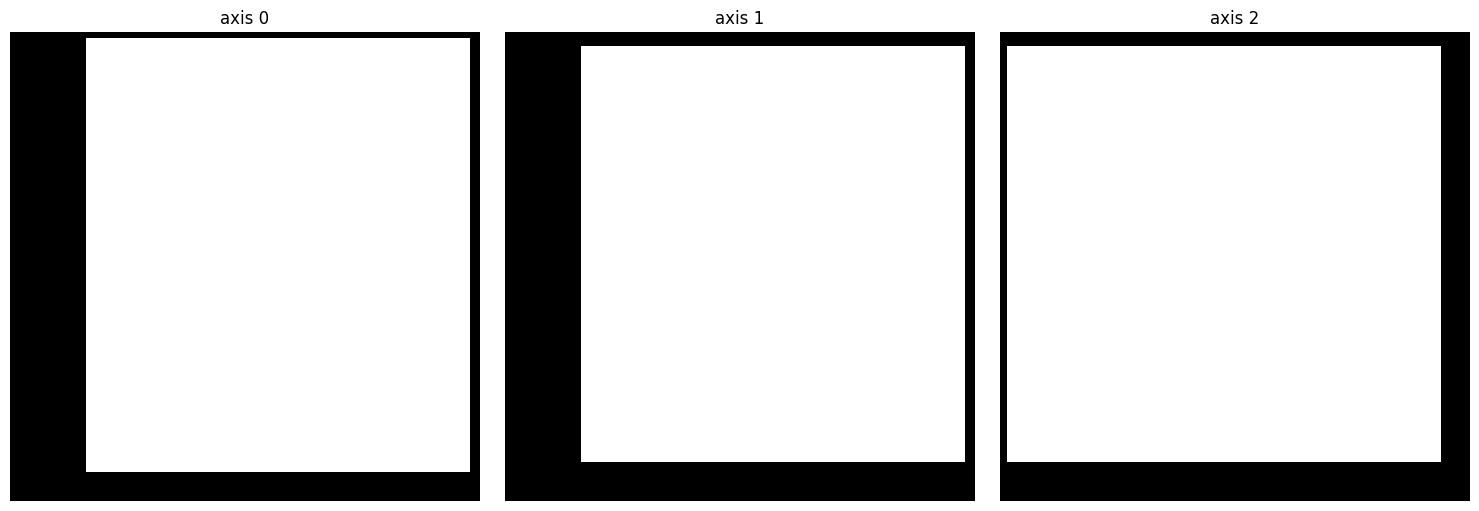

validation_synth/image_14
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


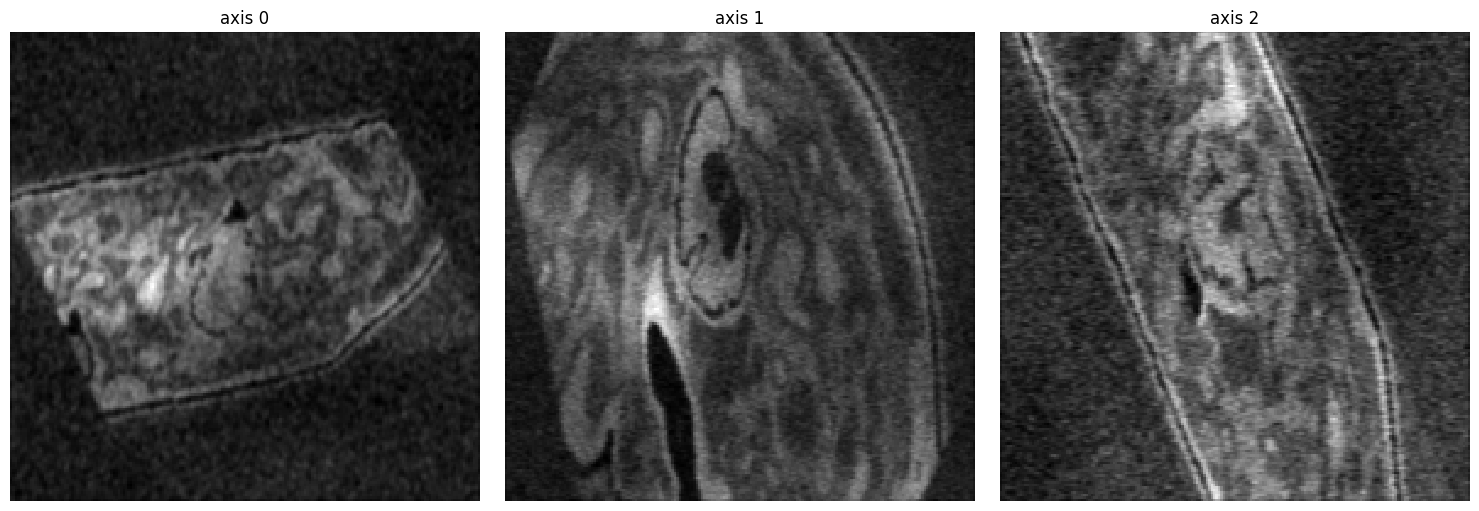

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 0 21 16], shape=(3,), dtype=int64) tf.Tensor([176 182 157], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.06030628, shape=(), dtype=float32)
(192, 192, 192)


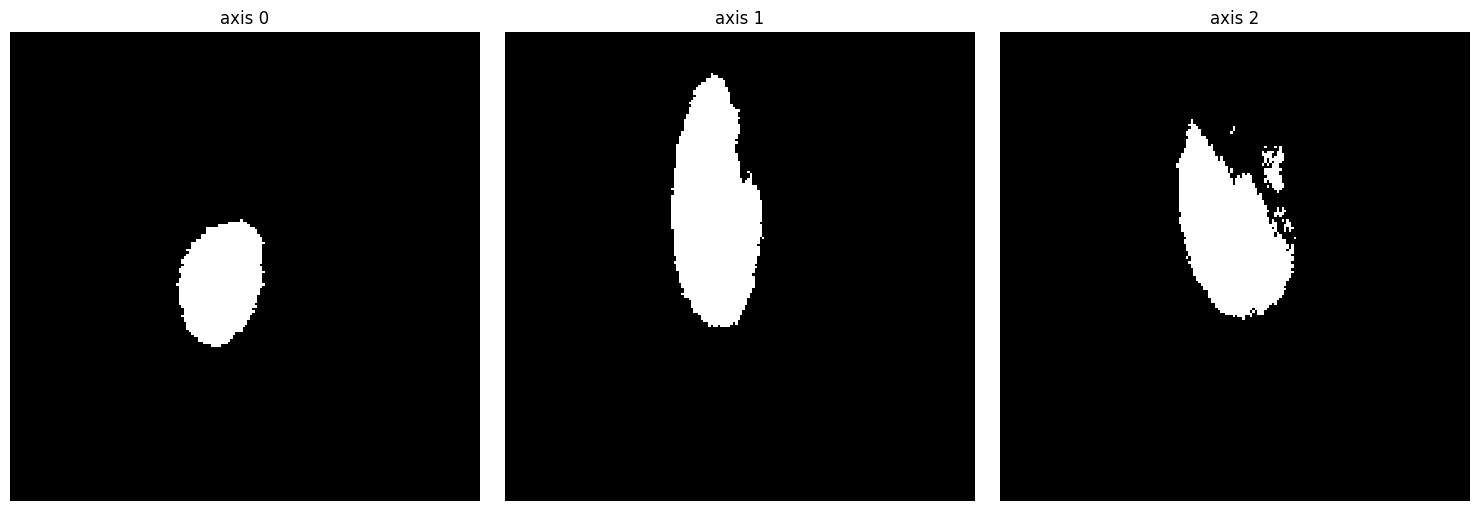

shape after box (1, 192, 192, 192, 2)


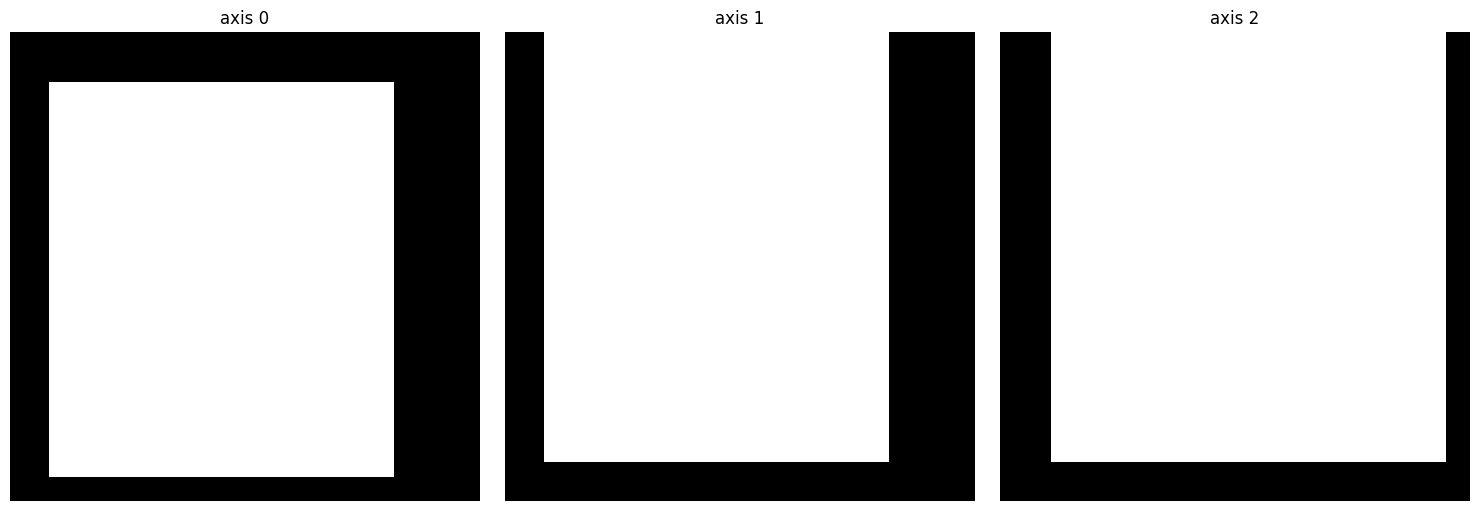

validation_synth/image_15
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


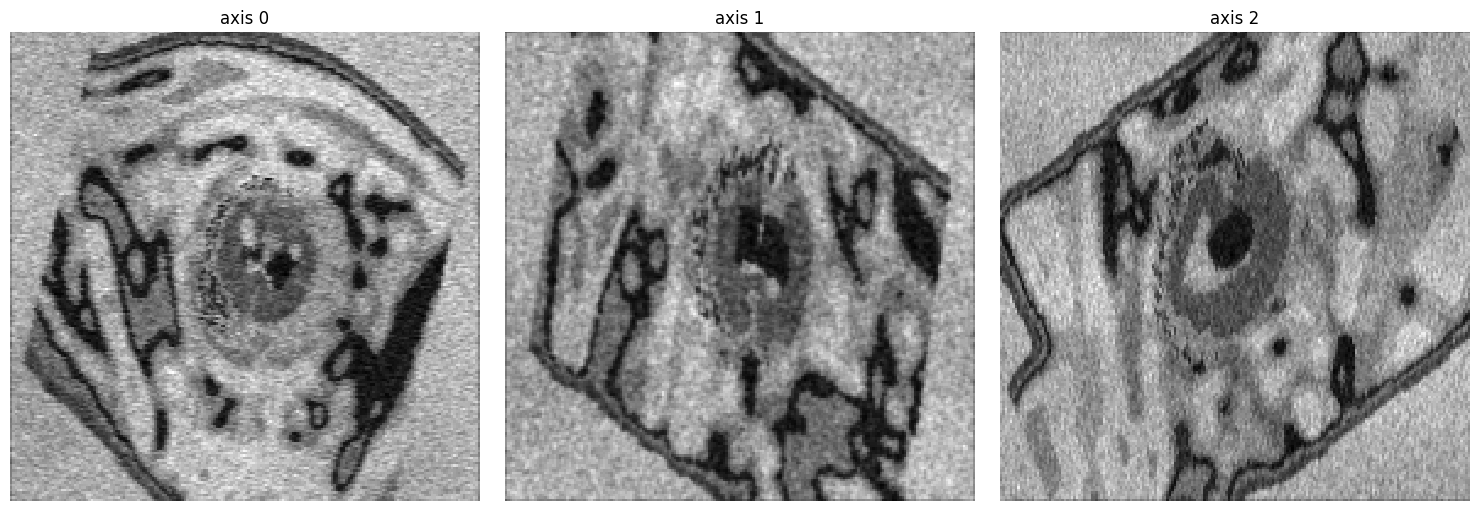

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 0 12 33], shape=(3,), dtype=int64) tf.Tensor([186 174 177], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.07153019, shape=(), dtype=float32)
(192, 192, 192)


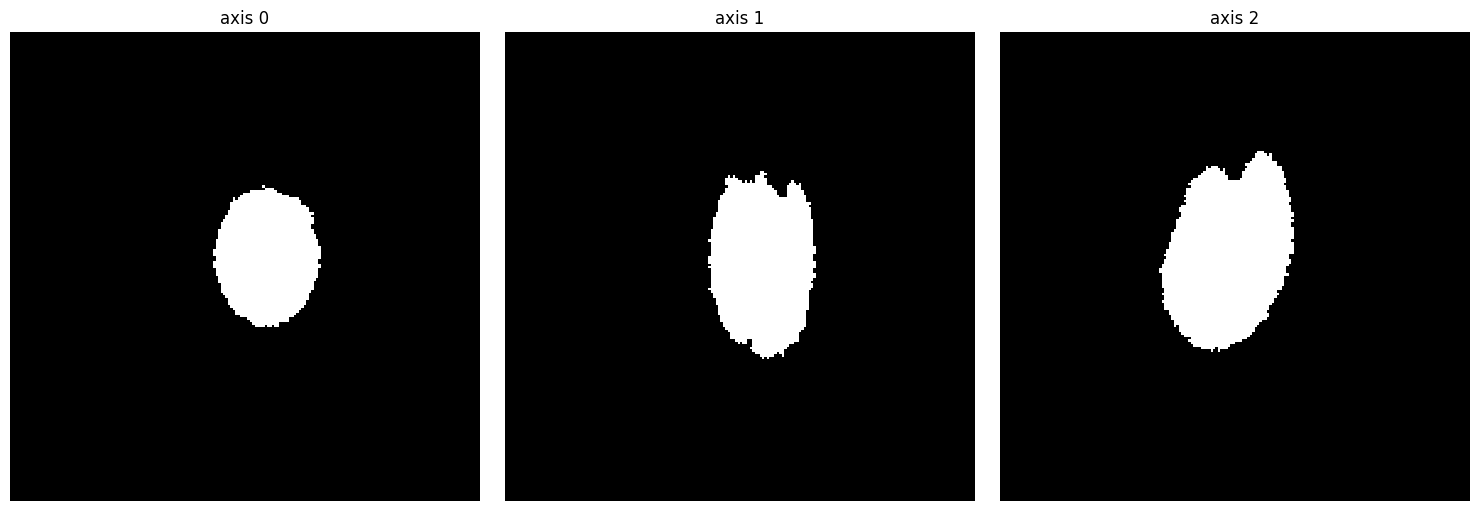

shape after box (1, 192, 192, 192, 2)


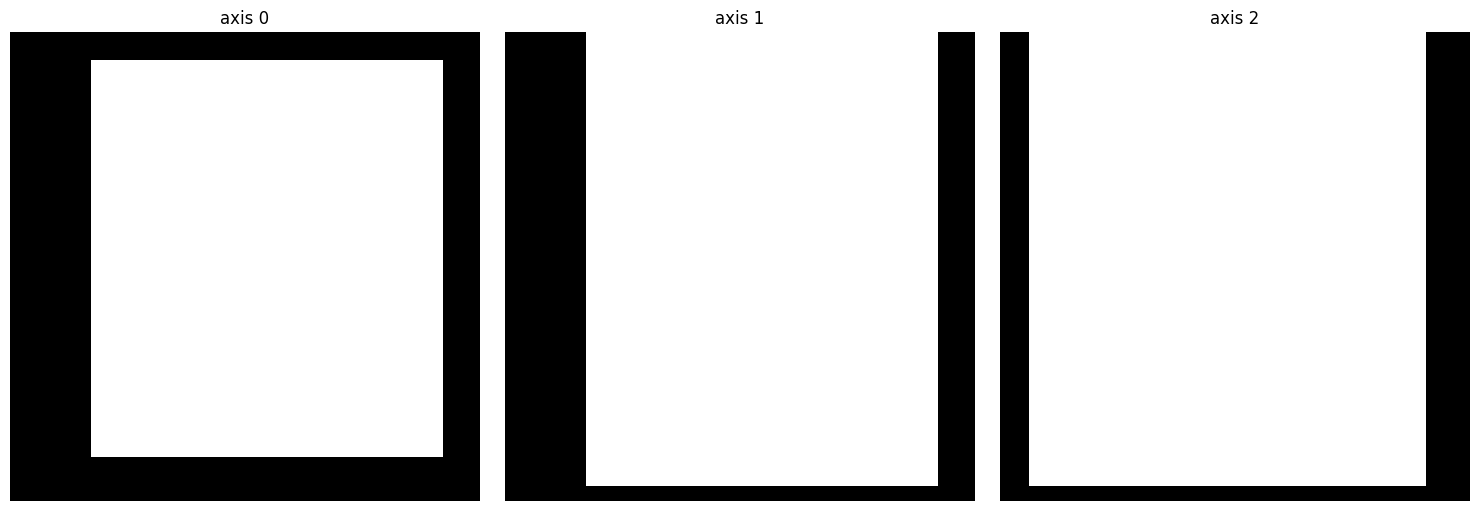

validation_synth/image_16
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


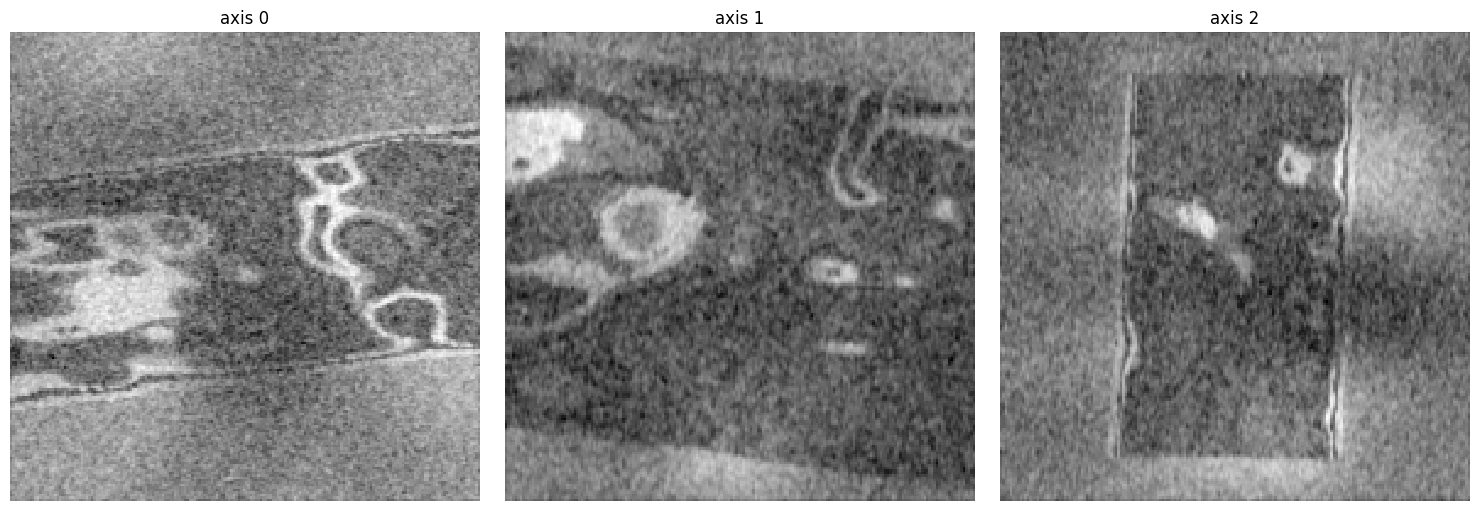

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([0 9 0], shape=(3,), dtype=int64) tf.Tensor([152 150 148], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.038371153, shape=(), dtype=float32)
(192, 192, 192)


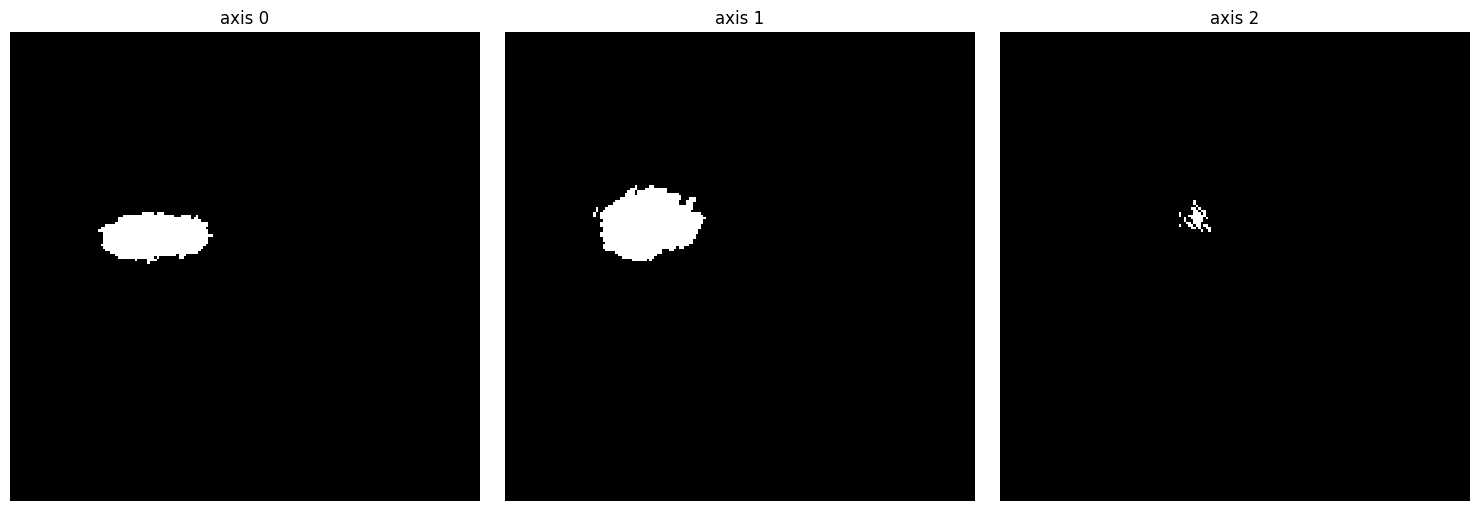

shape after box (1, 192, 192, 192, 2)


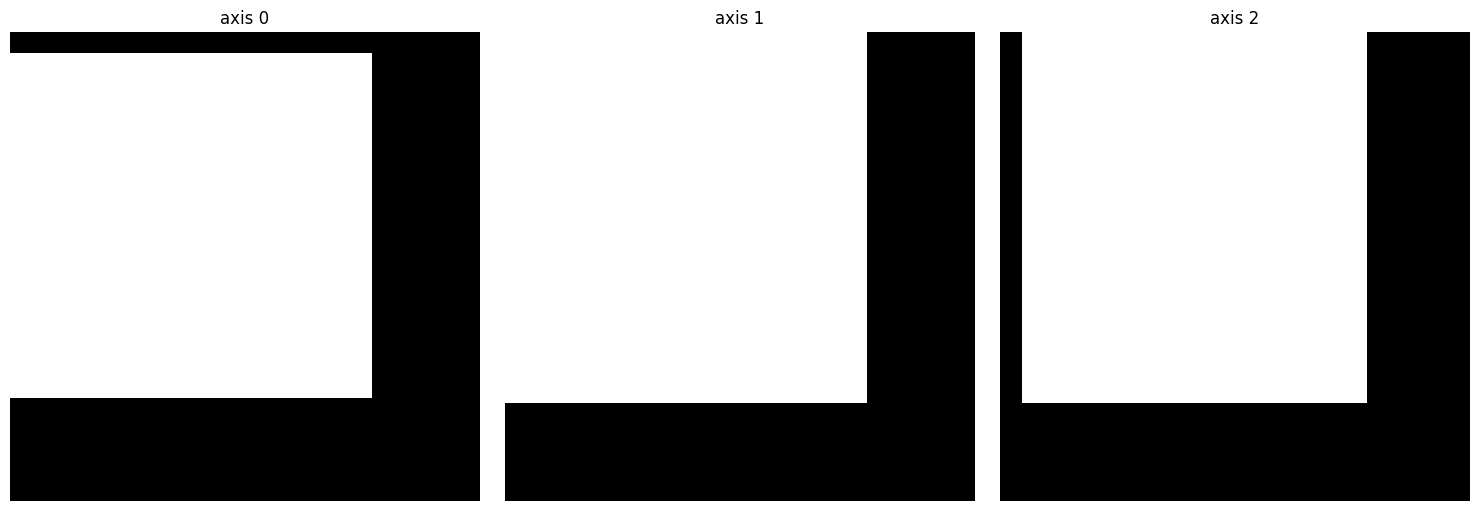

validation_synth/image_17
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


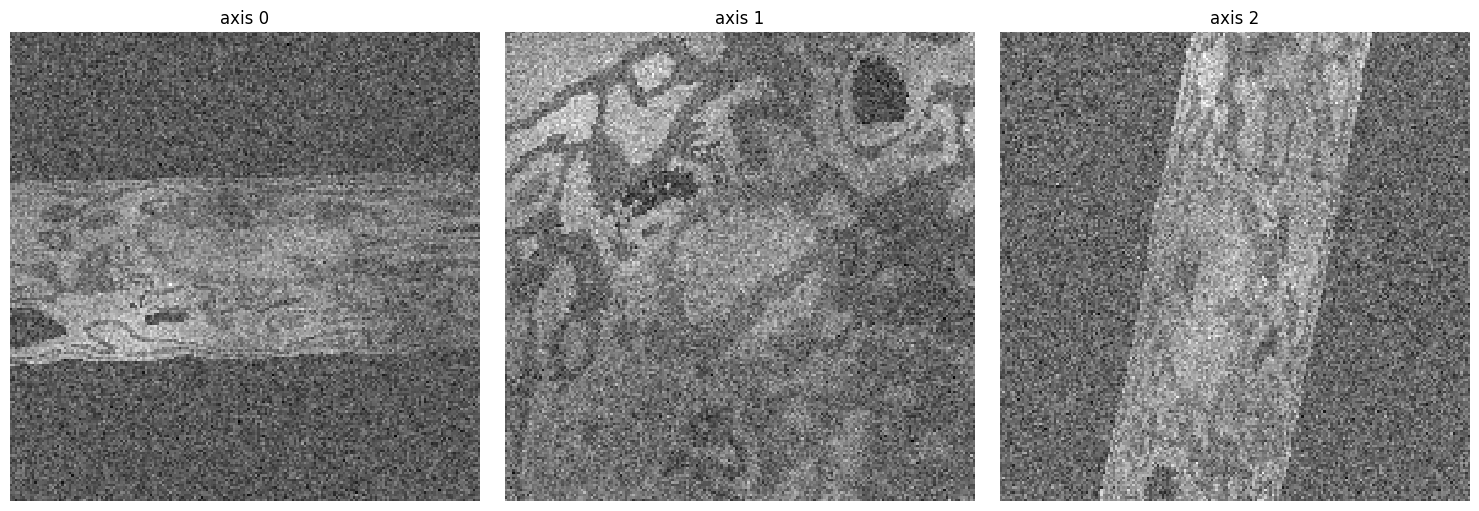

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 3 12  0], shape=(3,), dtype=int64) tf.Tensor([191 155 191], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.09799658, shape=(), dtype=float32)
(192, 192, 192)


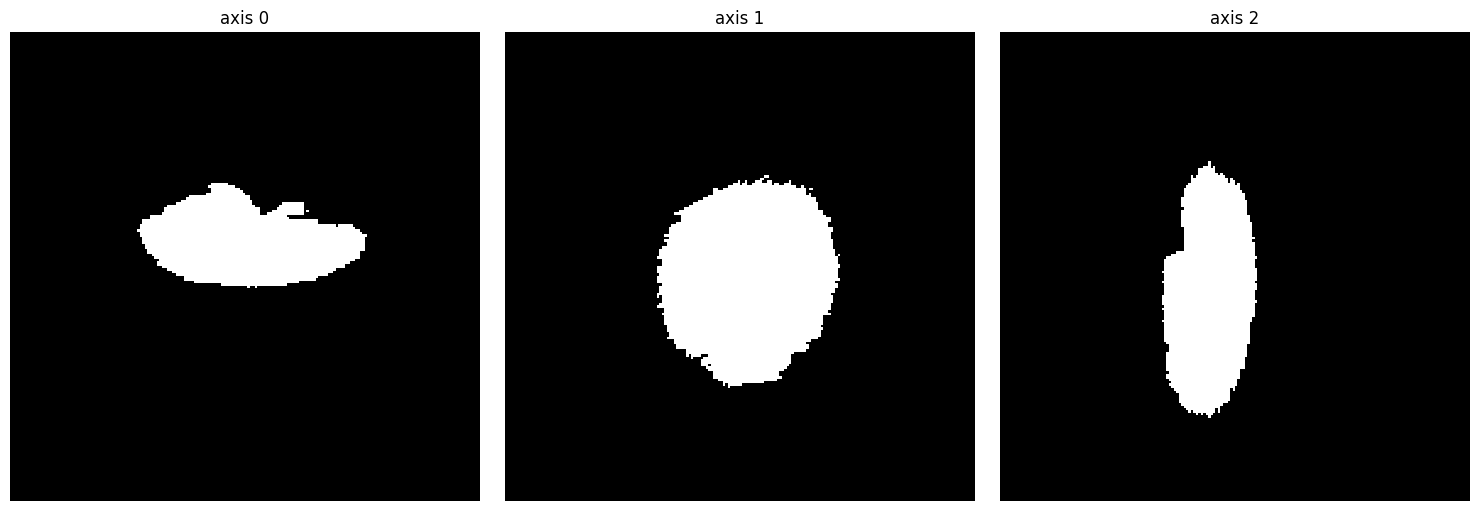

shape after box (1, 192, 192, 192, 2)


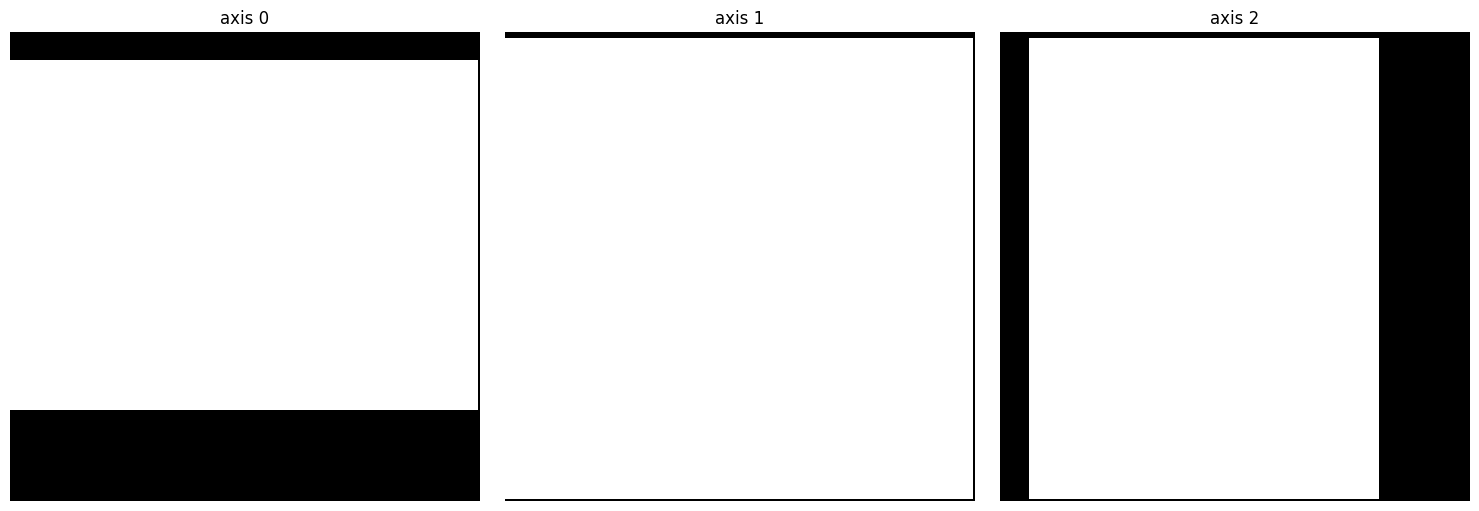

validation_synth/image_18
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


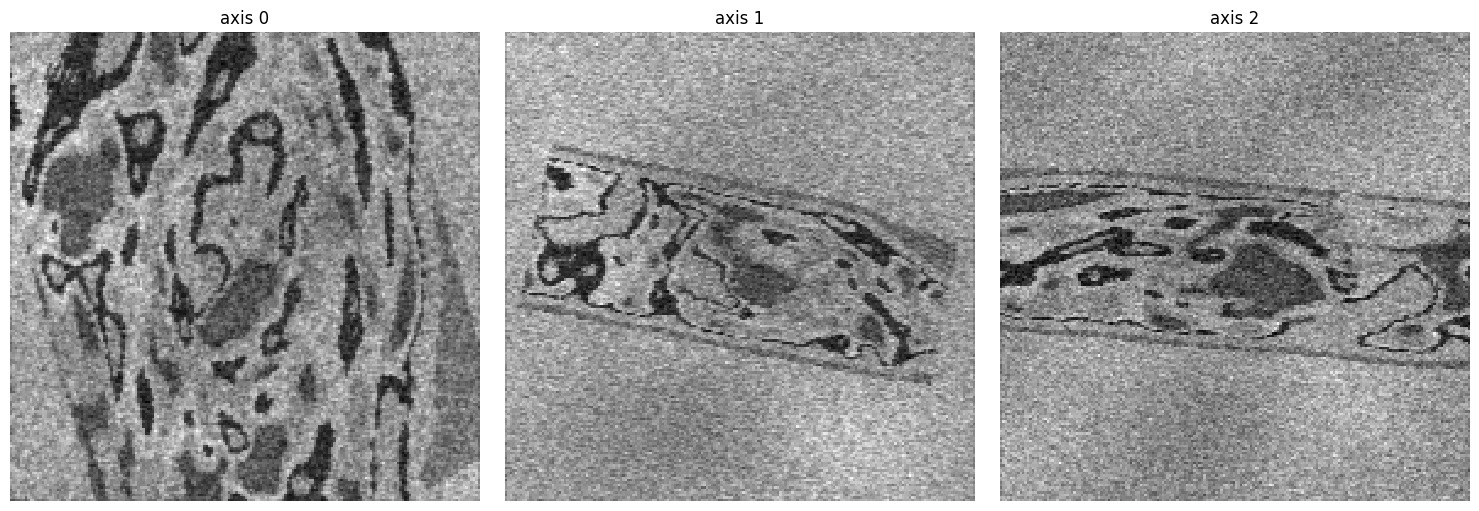

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 9 60 10], shape=(3,), dtype=int64) tf.Tensor([145 191 154], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.025217354, shape=(), dtype=float32)
(192, 192, 192)


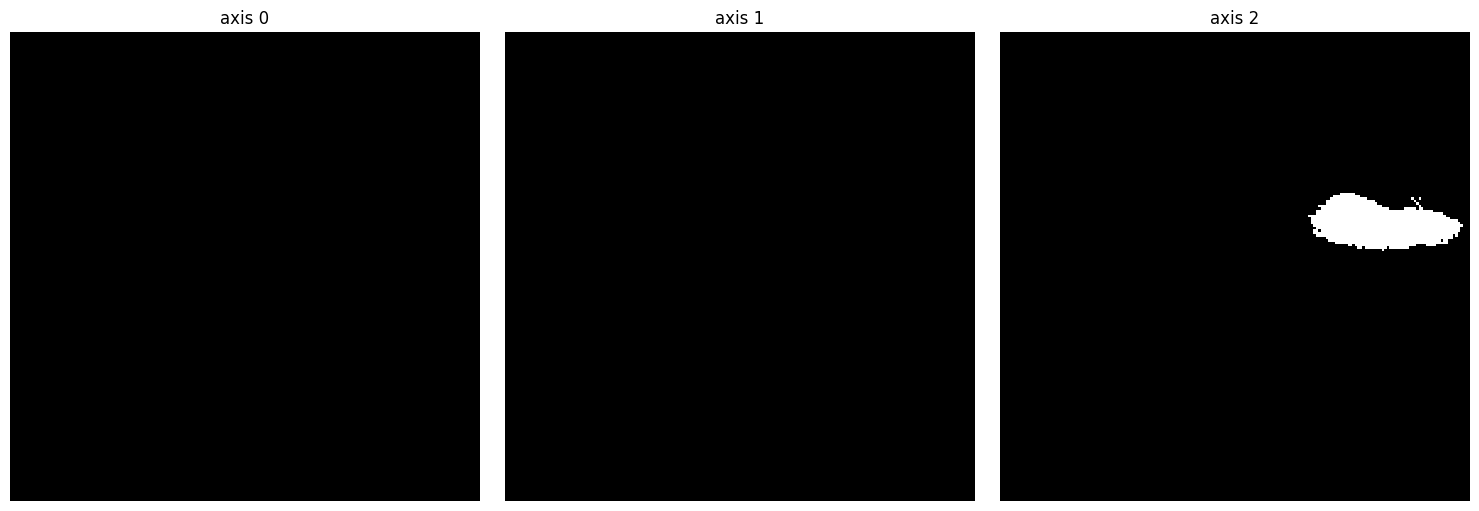

shape after box (1, 192, 192, 192, 2)


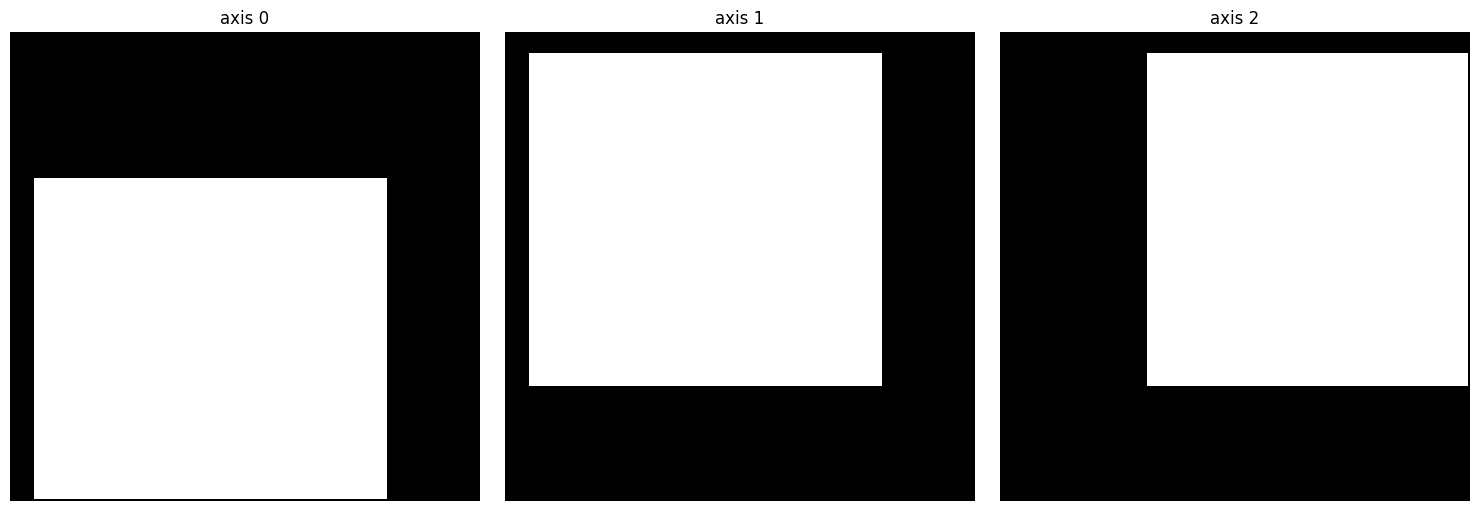

validation_synth/image_19
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


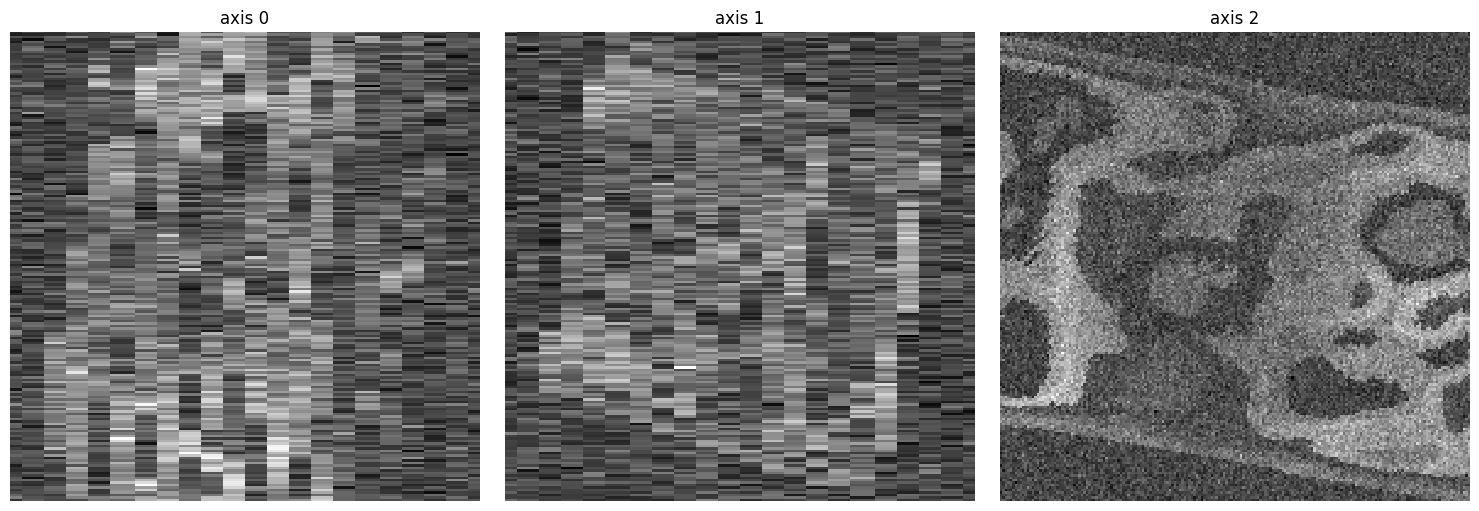

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([26  0 17], shape=(3,), dtype=int64) tf.Tensor([183 177 157], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.057619095, shape=(), dtype=float32)
(192, 192, 192)


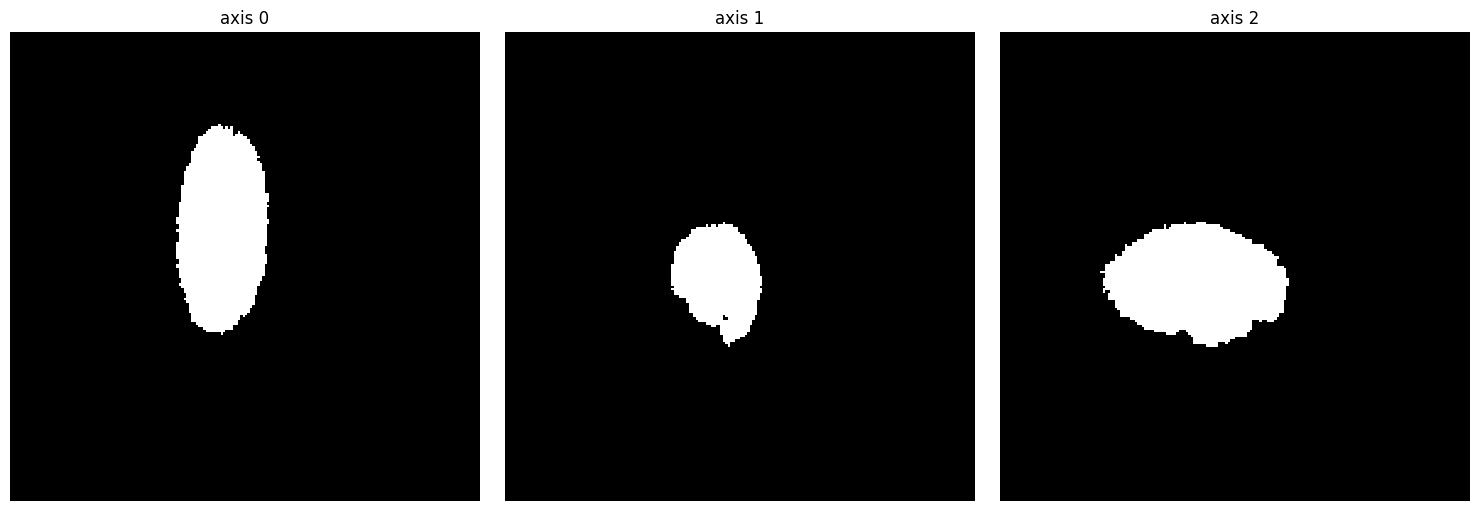

shape after box (1, 192, 192, 192, 2)


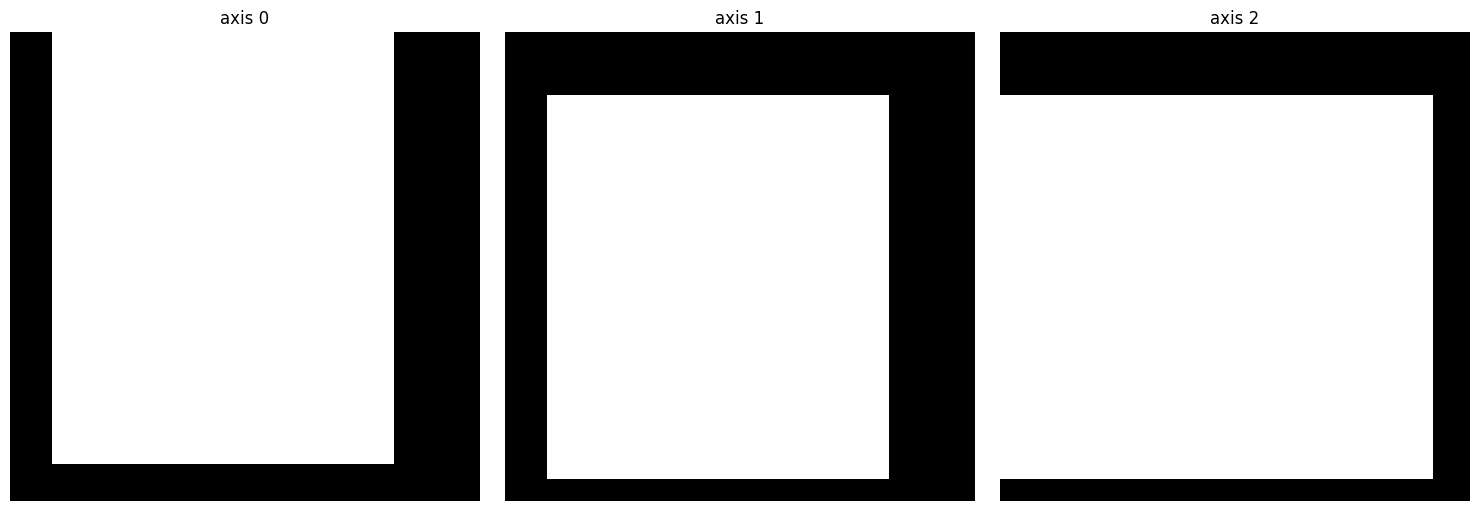

validation_synth/image_20
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


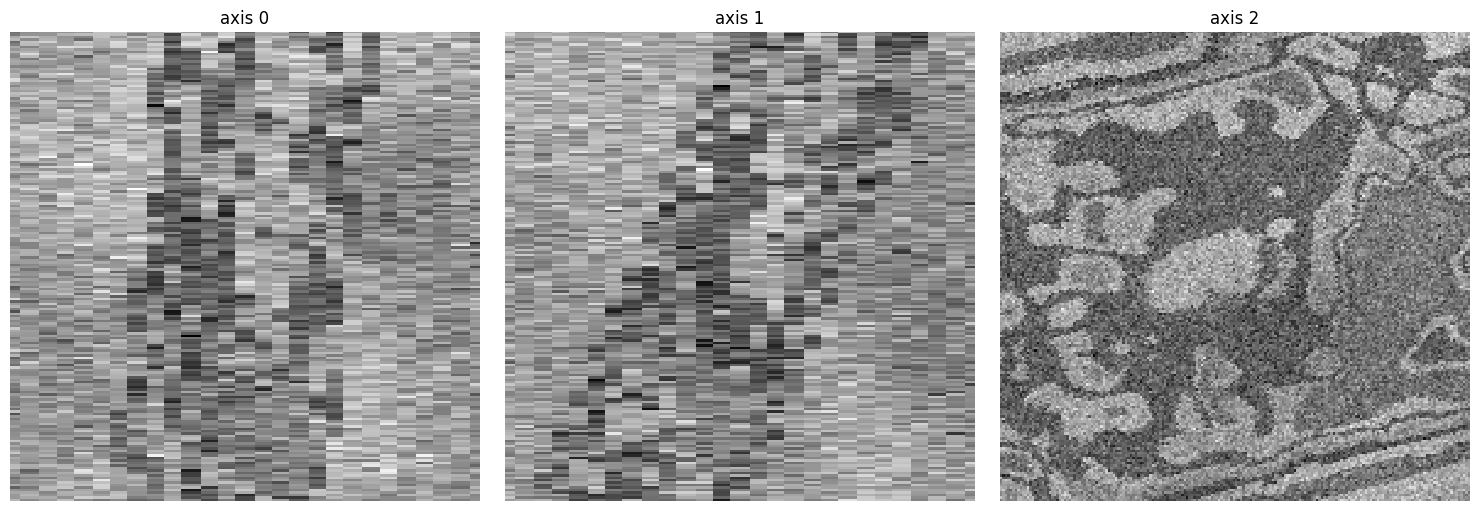

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 9  0 42], shape=(3,), dtype=int64) tf.Tensor([178 191 181], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.07609677, shape=(), dtype=float32)
(192, 192, 192)


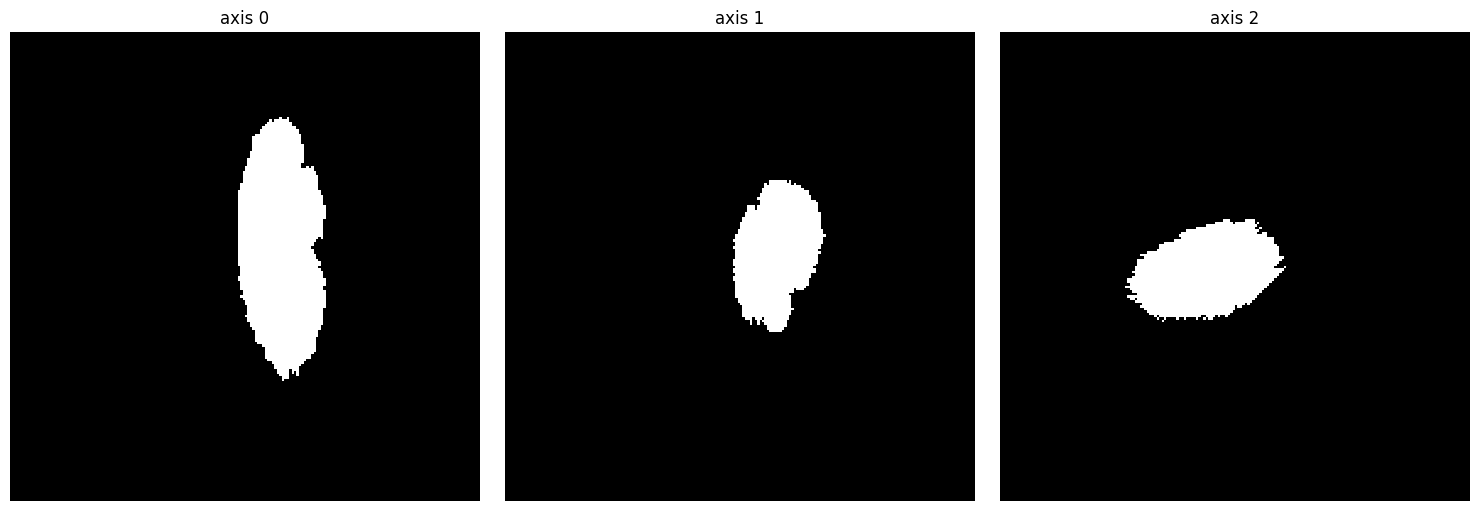

shape after box (1, 192, 192, 192, 2)


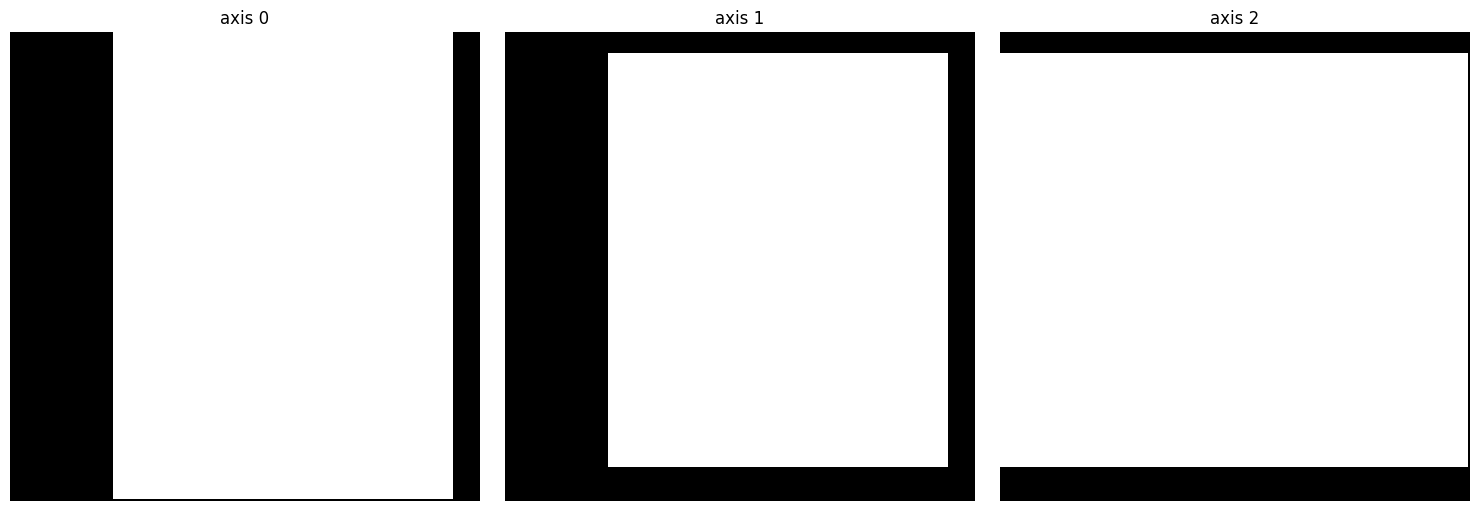

validation_synth/image_21
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


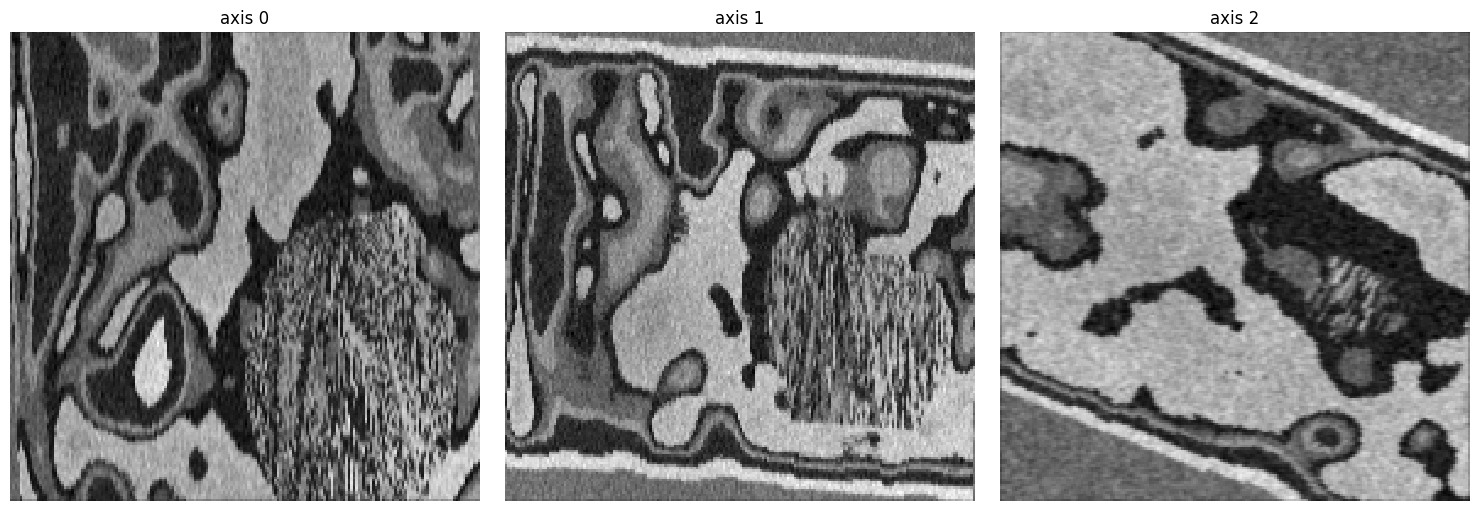

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([ 0  0 62], shape=(3,), dtype=int64) tf.Tensor([127 154 191], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.024203751, shape=(), dtype=float32)
(192, 192, 192)


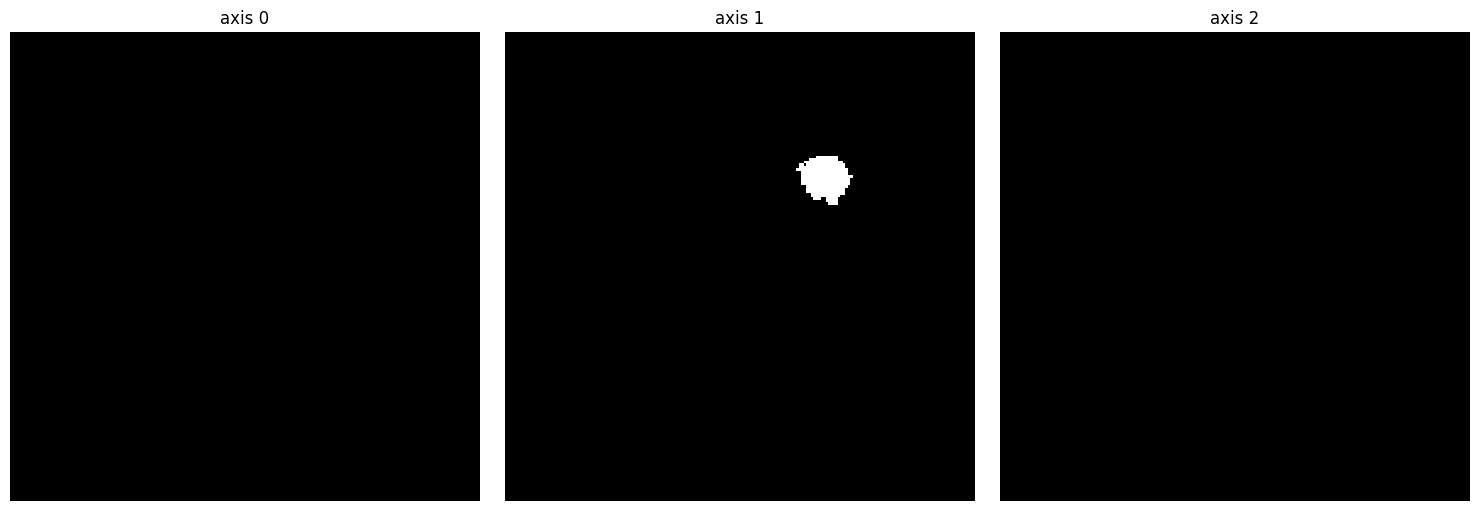

shape after box (1, 192, 192, 192, 2)


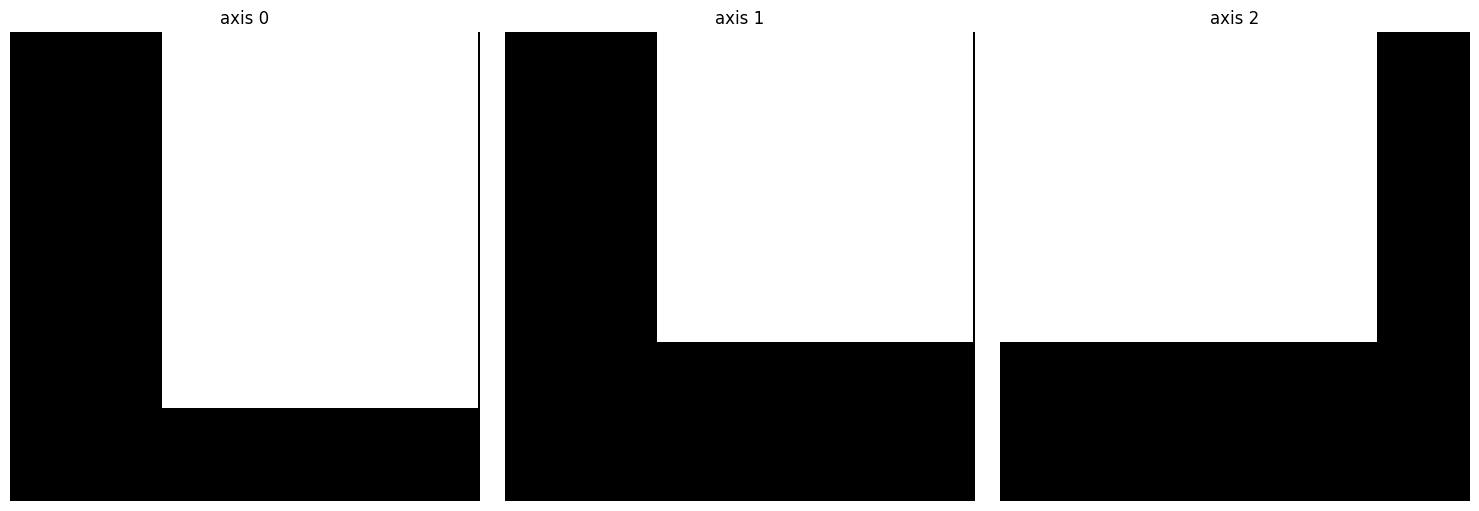

validation_synth/image_22
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


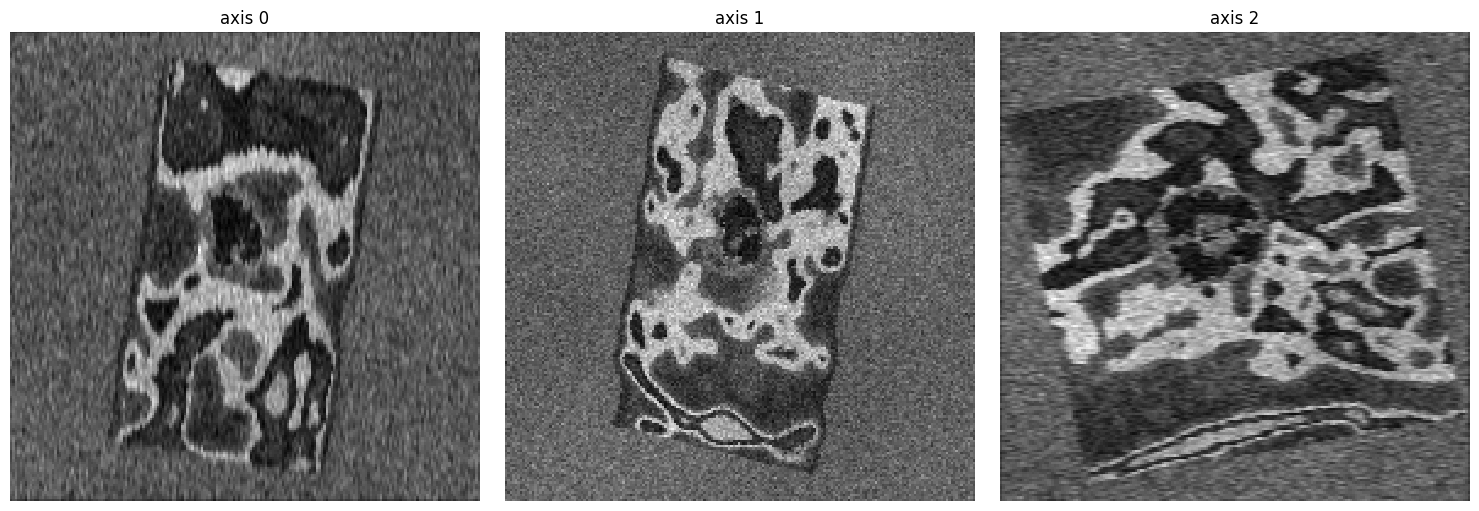

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([13  8 20], shape=(3,), dtype=int64) tf.Tensor([156 161 160], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.03650666, shape=(), dtype=float32)
(192, 192, 192)


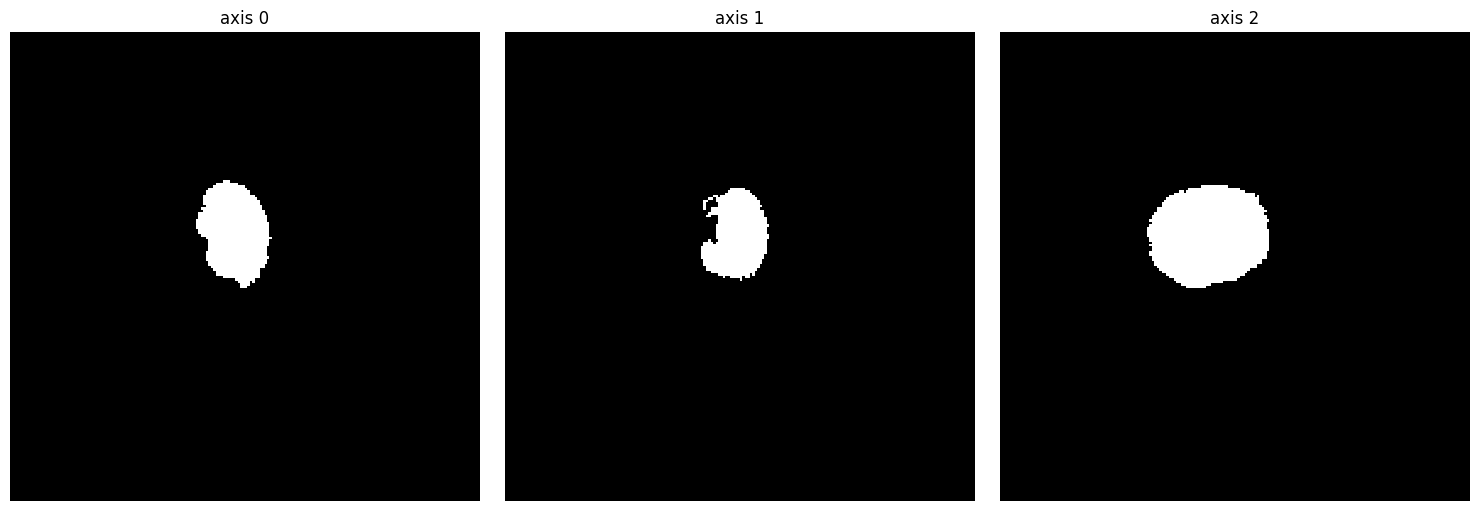

shape after box (1, 192, 192, 192, 2)


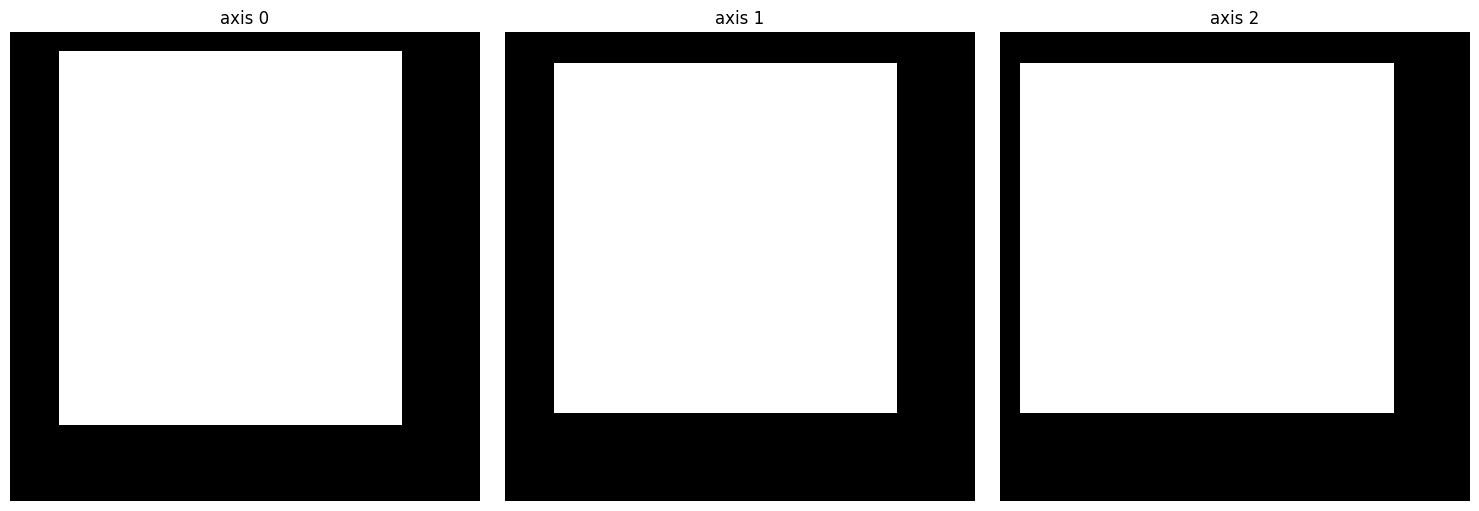

validation_synth/image_23
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


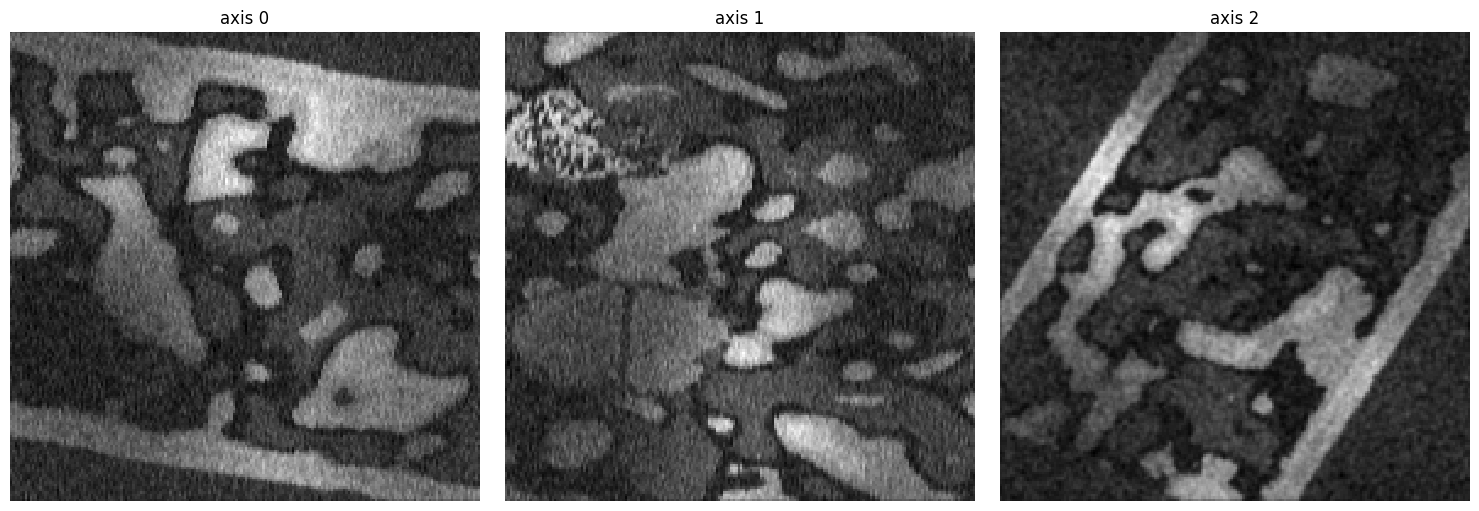

input mask begining: (1, 192, 192, 192, 2)
min/max tf.Tensor([46 24  0], shape=(3,), dtype=int64) tf.Tensor([191 191 146], shape=(3,), dtype=int64)
(1, 192, 192, 192, 2)
center of mass  tf.Tensor(0.04501959, shape=(), dtype=float32)
(192, 192, 192)


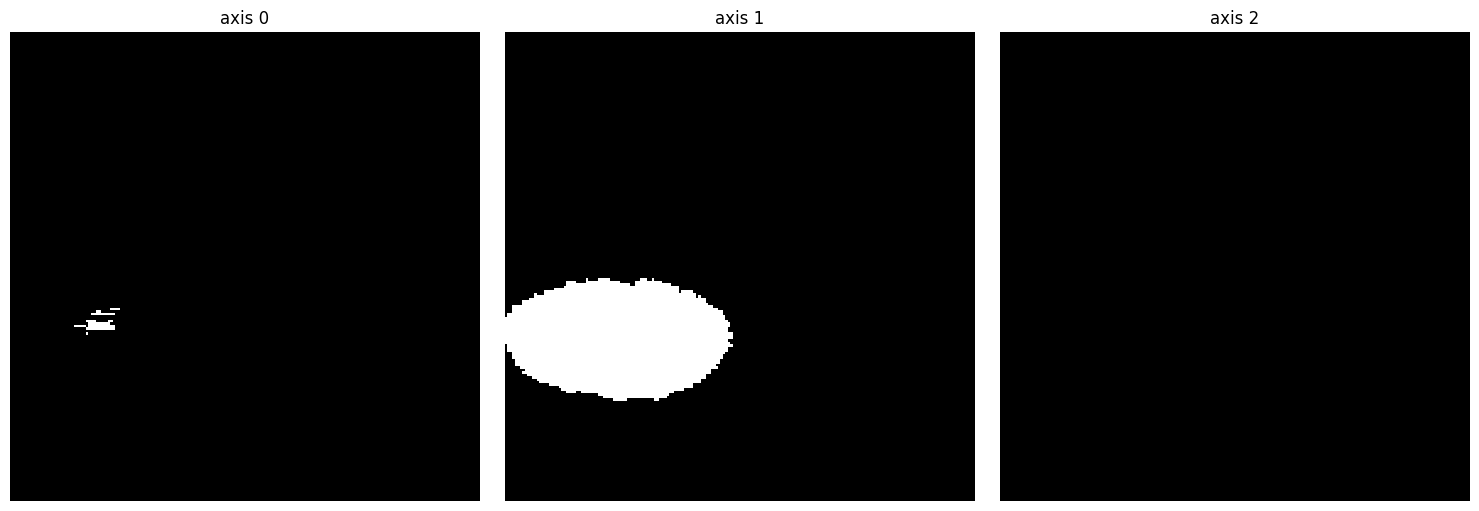

shape after box (1, 192, 192, 192, 2)


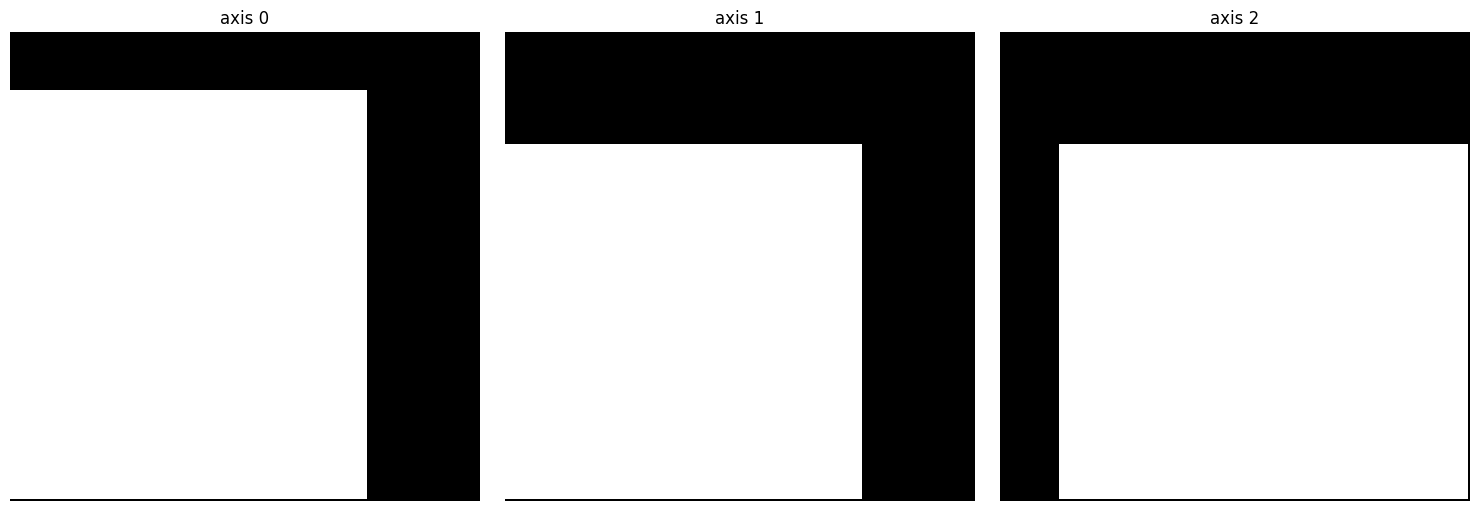

validation_synth/image_24
(192, 192, 192)
(192, 192, 192) (192, 192, 192) (192, 192, 192)


In [15]:
# print(output_brain.shape)
images = []
one_hots = []
slices_at_com = []
images_at_com = []
main_folder = "validation_synth"
import numpy as np
from scipy.ndimage import label

import numpy as np
from tensorflow import keras

import tensorflow as tf
import tensorflow as tf

from scipy.ndimage import binary_dilation


import tensorflow as tf
import numpy as np

import tensorflow as tf


import tensorflow as tf


def center_of_mass(tensor):
    # Find the indices of non-zero elements
    indices = tf.where(tf.not_equal(tensor, 0))
    # Cast indices to float32
    indices = tf.cast(indices, tf.float32)
    # Calculate the center of mass along each axis
    center = tf.reduce_sum(indices, axis=0) / (tf.cast(tf.shape(indices)[0], tf.float32) + 1e-6)
    return center


def center_of_mass_mse(a, b):
    # Calculate the center of mass for tensors a and b
    # center_a = tf.reduce_mean(tf.cast(a, tf.float32), axis=(1, 2, 3))
    # center_b = tf.reduce_mean(tf.cast(b, tf.float32), axis=(1, 2, 3))
    # # Calculate the squared Euclidean distance between the centers of mass
    # distance_squared = tf.reduce_sum(tf.square(center_a - center_b))
    center_a = ne.utils.barycenter(a)
    center_b = ne.utils.barycenter(a)
    # Calculate the mean squared error
    mse = tf.reduce_mean(tf.square(center_a - center_b))
    return mse

    
def create_bounding_box_indices(min_indices, max_indices):
    grid_x, grid_y, grid_z = tf.meshgrid(
        tf.range(min_indices[0], max_indices[0]),
        tf.range(min_indices[1], max_indices[1]),
        tf.range(min_indices[2], max_indices[2]),
        indexing='ij'
    )
    indices = tf.stack([grid_x, grid_y, grid_z], axis=-1)
    return tf.reshape(indices, shape=(-1, 3))

def fit_bounding_rect_box(input_mask,margin=10):
    # Squeeze the first and last dimensions
    print("input mask begining:",input_mask.shape)
    mask = tf.argmax(input_mask, axis=-1, output_type=tf.int32)
    mask = tf.squeeze(mask, axis=0)
    non_zero_indices = tf.where(tf.not_equal(mask, 0))
    
    min_indices = tf.maximum(tf.reduce_min(non_zero_indices, axis=0)-margin, tf.constant([0, 0, 0], dtype=tf.int64))
    max_indices = tf.minimum(tf.reduce_max(non_zero_indices, axis=0) +margin+ 1, tf.constant([191, 191, 191], dtype=tf.int64))
    
    print("min/max",min_indices,max_indices)    
    new_mask = tf.zeros_like(mask, dtype=tf.int32)
    indices = create_bounding_box_indices(min_indices, max_indices)
    updates = tf.ones([tf.shape(indices)[0]], dtype=tf.int32)
    updates = tf.cast(updates, dtype=tf.int32)
    new_mask = tf.tensor_scatter_nd_add(new_mask, indices, updates)
    new_mask = tf.expand_dims(new_mask, axis=0)
    new_mask = tf.one_hot(new_mask, depth=2)
    return new_mask
    
def fit_bounding_box(input_mask):
    # Squeeze the first and last dimensions
    mask = tf.argmax(input_mask, axis=-1, output_type=tf.int32)
    mask = tf.squeeze(mask, axis=0)
    margin = 2
    non_zero_indices = tf.where(tf.not_equal(mask, 0))
    min_indices = tf.maximum(tf.reduce_min(non_zero_indices, axis=0)-margin, tf.constant([0, 0, 0], dtype=tf.int64))
    max_indices = tf.minimum(tf.reduce_max(non_zero_indices, axis=0) +margin+ 1, tf.constant([191, 191, 191], dtype=tf.int64))
    bounding_box_dimensions = max_indices - min_indices
    cube_side_length = tf.reduce_max(bounding_box_dimensions)
    min_indices = min_indices - tf.math.maximum((cube_side_length - bounding_box_dimensions) // 2, 0)
    max_indices = min_indices + tf.math.minimum(cube_side_length,64)
    min_indices = tf.clip_by_value(min_indices, 0, 191)
    max_indices = tf.clip_by_value(max_indices, 0, 191)
    new_mask = tf.zeros_like(mask, dtype=tf.int32)
    indices = create_bounding_box_indices(min_indices, max_indices)
    updates = tf.ones([tf.shape(indices)[0]], dtype=tf.int32)
    updates = tf.cast(updates, dtype=tf.int32)
    new_mask = tf.tensor_scatter_nd_add(new_mask, indices, updates)
    new_mask = tf.expand_dims(new_mask, axis=0)
    new_mask = tf.one_hot(new_mask, depth=2)
    return new_mask

# Example usage:
# mask = your_input_mask
# bounding_box_result = fit_bounding_box(mask)

    
for i in range(num_gen):
    a = output_labels[i]
    subfolder_path = os.path.join(main_folder, f"image_{i}")

    generated_img, y = labels_to_image_model(a)
    generated_img = np.squeeze(generated_img,axis=(0,-1))
    
    # print(generated_img.shape,mask.shape)
    # mask1 = np.squeeze(np.argmax(y,axis=-1),axis=0)

    ne.plot.volume3D(generated_img,cmaps=['gray'])
    mask = fit_bounding_rect_box(y,margin=50)
    print(y.shape)
    z = center_of_mass_mse(mask,y)
    print("center of mass ",z)

    y = tf.argmax(y, axis=-1, output_type=tf.int32)
    y = np.squeeze(y,axis=0)

    print(y.shape)

    ne.plot.volume3D(y,cmaps=['gray'])

    print("shape after box",mask.shape)
    mask = np.argmax(mask,axis=-1)
    mask = np.squeeze(mask,axis=0)

    
    ne.plot.volume3D(mask,cmaps=['gray'])

    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
    print(subfolder_path)
    # Save the images to the subfolder
    print(generated_img.shape)
    # mask_numpy = mask.numpy()
    print(generated_img.shape,mask.shape,y.shape)
    nib.save(nib.Nifti1Image(generated_img, np.eye(4)), f"{subfolder_path}/image.nii.gz")
    nib.save(nib.Nifti1Image(np.int32(mask),np.eye(4)), f"{subfolder_path}/box.nii.gz")

    nib.save(nib.Nifti1Image(np.int32(y),np.eye(4)), f"{subfolder_path}/manual.nii.gz")

In [14]:
mask.shape

(192, 192, 192)

In [7]:
output_label.shape

(1, 256, 256, 256, 1)